In [1]:
import os

os.system('jupyter nbconvert --to html P2_01_notebook.ipynb')

0

# **Analyse marketing vers une expansion internationale**
*Sofia Chevrolat (Mai 2020)*
___
Ce notebook vise à étudier la faisabilité d'exploiter le contenu de la base de données de  l’organisme _“EdStats All Indicator Query” de la Banque mondiale_ contenant près de 4000 indicateurs sur le thème de l'éducation des populations dans le cadre d'un projet d'expansion à l'internationale de la start-up EdTech Academy. 
Basée en France, cette société propose des contenus de formation en ligne pour un public niveau lycée et université.
Academy souhaite explorer les problématiques suivantes:
- Quels sont les pays avec un fort potentiel de clients pour nos services ? 
- Pour chacun de ces pays, quelle sera l'évolution de ce potentiel de clients ?
- Dans quels pays l'entreprise doit-elle opérer en priorité ?

Compte tenu des probléamtiques soulevées, cette pré-analyse se focalisera sur trois points :
- **Accès à un ordinateur ou à internet** : les cours étant en ligne, il s'agit d'un point crucial.
- **Les populations étudiant aux niveaux lycée et université** : les tranches scolaires cibles, sans discrimination d'âge. Il est en effet possible d'étudier des cours niveau université à l'âge adulte (reconversion, montée en compétence).
- **La taille du marché potentiel** : l'ensemble des actifs, à savoir la tranche d'âge 15 ans et plus.

Dans cette étude, nous prendrons pour référence le marché Français. 
En effet, nous partirons du postulat que la société Academy est en mesure de s'intéresser à une expansion car son business model fonctionne dans son pays d'origine. Il sera donc pertinent de rechercher des zones géographiques dont le profil se rapproche de celui de la France.
___
_**Remerciements**:<br>
Merci à mon compagnon [J. Duplan](https://www.linkedin.com/in/julian-duplan-64844a41/) pour les discussions intéressantes.<br>
Merci également à mon mentor [Samia Drappeau](https://www.linkedin.com/in/samiadrappeau) pour les échanges d'idées, les conseils sur les graphiques et les encouragements!_
___
Ce notebook est organisé comme suit:

**0. Mise en place**
- 0.1 Chargement des librairies nécessaires
- 0.2 Définition des fonctions utilisées
- 0.3 Chargement du jeu de données

**1. Description et nettoyage**
- 1.1 Description du jeu de données
- 1.2 Assemblage et nettoyage des données
- 1.3 Qualité du jeu de données
    * 1.3.1 Données descriptives
    * 1.3.2 Données de projection

**2. Pré-Analyse Exploratoire**
- 2.1 Détermination des catégories d'indicateurs pertinentes
- 2.2 Détermination des indicateurs pertinents
    * 2.2.1 Détermination du seuil optimal de manquants (dataframe descriptive)
    * 2.2.2 Sélection des indicateurs
- 2.3 Détermination des zones géographiques d'intérêt
    * 2.3.1 Mise en place
    * 2.3.2 Comparaison des profils des zones géographiques
    * 2.3.3 Sélection des zones géographiques
- 2.4 Détermination des pays d'intérêt
    * 2.4.1 Grandeurs statistiques des pays concernés
    * 2.4.2 Sélection des pays 

**3. Conclusion : validation du jeu de données, recommandations et points d'amélioration**

**4. Annexes : code des fonctions implémentées dans le cadre de la pré-analyse**

___
## 0. MISE EN PLACE

 Dans cette première étape, le cadre de travail est mis en place, c'est-à-dire :
 - Les librairies et packages Python nécessaires sont chargés
 - Les fonctions utiles sont définies 
 - Le jeu de données est chargé
___

___
### 0.1 Chargement des librairies Python nécessaires

In [1]:
import pandas as pd
import numpy as np
import random
from collections import Counter
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns

___
### 0.2 Définition des fonctions utiles

Pour une meilleure clarté du notebook et un plus grand confort de lecture, les fonctions implémentées pour certains calculs ainsi que pour la réalisation des graphiques ont été placées dans le fichier helper_functions.py.

Ces fonctiont sont chargées via la ligne de code ci-dessous:

In [2]:
import helper_functions as hf

_**N.B : Le code de ces fonctions est également disponible en fin de notebook, section "Annexes"**_

___
### 0.3 Chargement du jeu de données

In [3]:
education_data = pd.read_csv('./Sources/EdStatsData.csv')
education_data_series = pd.read_csv('./Sources/EdStatsSeries.csv')
education_data_pays = pd.read_csv('./Sources/EdStatsCountry.csv')
education_data_pays_series = pd.read_csv('./Sources/EdStatsCountry-Series.csv')
education_data_footnote = pd.read_csv('./Sources/EdStatsFootnote.csv')

___
### 1.1 Description du jeu de données

In [4]:
hf.descriptionJeuDeDonnees({'EdStatsData':           [education_data, "Données globales"],
                            'EdStatsSeries':         [education_data_series, "Détail des indicateurs"],
                            'EdStatsCountry':        [education_data_pays, "Détail des pays étudiés"],
                            'EdStatsCountry-Series': [education_data_pays_series, 
                                                      "Informations supplémentaires indicateurs"],
                            'EdStatsFootnote':       [education_data_footnote,
                                                      "Informations supplémentaires indicateurs / pays"]
                          })

Les données se décomposent en 5 fichiers: 



Nom du fichier  Nb de lignes  Nb de colonnes  \
1            EdStatsData        886930              70   
2          EdStatsSeries          3665              21   
3         EdStatsCountry           241              32   
4  EdStatsCountry-Series           613               4   
5        EdStatsFootnote        643638               5   

                                       Description  
1                                 Données globales  
2                           Détail des indicateurs  
3                          Détail des pays étudiés  
4         Informations supplémentaires indicateurs  
5  Informations supplémentaires indicateurs / pays

Durant cette analyse, nous utiliserons uniquement les données situées dans les fichiers:
    - EdStatsData
    - EdStatsSeries
    - EdStatsCountry

___
### 1.2 Assemblage & Nettoyage des données

Le span de temps couvert par les données s'étend de 1970 à 2100.<br>
Un examen rapide du fichier décrivant les indicateurs permet de mettre en lumière que certains indicateurs sont des indicateurs de projection.

Étant donné que:
- la vulgarisation du PC date essentiellement des années 2000
- la population cible est prête à prendre des cours en ligne, et est donc à l'aise avec les technologies informatiques

> **Le span 2000-2020 devrait être suffisamment représentatif pour la partie descriptive de cette pré-
analyse.**

>**Le span 2020-2100 sera considéré pour des projections potentielles.**

On procède donc à l'assemblage et au nettoyage de 2 dataframes : 
- La dataframe descriptive couvrant la période [2000-2020]
- La dataframe de projections couvrant la période [2020-2100]

Pour ce faire, on va :
1. Restreindre les dataframes aux colonnes spannant les années cibles
2. En supprimant toutes les lignes et colonnes entièrement vides
3. En ajoutant les informations de zone géographique
4. En corrigeant les données erronnées
5. En supprimant les lignes dont le champ "Region" est vide
6. En ajoutant les informations indicateurs
7. En supprimant les lignes dont le champ "Topic" est vide

In [5]:
# 1. a) Suppression des colonnes [1970 - 1999]
#-------------------------------------------------------------

education_data.drop(education_data.loc[:,'1970':'1999'].head(0).columns, axis=1, inplace=True)

In [6]:
# 2. Suppression de toutes les lignes et colonnes entièrement 
#    vides
#-------------------------------------------------------------

education_data = education_data.dropna(how='all').dropna(how='all', axis=1)

In [7]:
# 3. Ajout de la notion de région à chaque ligne via une
#    jointure sur le code pays entre education_data et 
#    education_data_pays
#-------------------------------------------------------------

region_education_data = education_data\
                        .join(education_data_pays[['Country Code', 'Region']]\
                              .set_index('Country Code'), 
                              on='Country Code')

In [8]:
# 4. Correction de valeurs mal placées : 
#    Certaines lignes ont une région renseignées dans le 
#    champ "Country Name" au lieu de "Region", qui lui est 
#    vide.
#    a) Si la région fait partie des régions connues, on la place
#       dans la colonne "Region"
#    b) Pour ces mêmes lignes, remplacer le "Country Name" par 
#       NaN.
#-------------------------------------------------------------

regions = {"Arab World":"Middle East & North Africa",
           "Middle East & North Africa": "Middle East & North Africa",
           "East Asia & Pacific":"East Asia & Pacific",
           "Sub-Saharan Africa":"Sub-Saharan Africa",
           "Europe & Central Asia":"Europe & Central Asia",
           "Euro area":"Europe & Central Asia",
           "Latin America & North Africa":"Latin America & North Africa",
           "North America":"North America",
           "South Asia":"South Asia"}

for country_name_error, region in regions.items():
    
    region_education_data.loc[region_education_data['Country Name'] == country_name_error,
                                                          'Region'] = region
    
    region_education_data.loc[region_education_data['Country Name'] == country_name_error,
                                                          'Country Name'] = np.NaN

In [9]:
# 5. Suppression des lignes dont le champ "Region" est vide 
#-------------------------------------------------------------

region_education_data = region_education_data[region_education_data['Region'].notna()]

In [10]:
# Harmonisation des noms de colonnes à travers les différents
# jeux de données en préparation de la jointure
#-------------------------------------------------------------

columns_new_names = {"Series Code": "Indicator Code", 
                     "Indicator Name" : "Indicator Description"}


education_data_series = education_data_series.rename(columns=columns_new_names)

In [11]:
# Ajout des notions détaillées d'indicateur via une
# jointure sur le code indicateur ("Indicator Code") entre 
# region_education_data et education_data_series
#-------------------------------------------------------------

topic_region_education_data = region_education_data.join(education_data_series[['Indicator Code',
                                                               'Topic',
                                                               'Indicator Description',
                                                               'Long definition']]\
                                                            .set_index('Indicator Code'), 
                                                            on='Indicator Code')

In [12]:
# Suppression des lignes dont le champ catégorie ("Topic") est 
# vide
#-------------------------------------------------------------

topic_region_education_data = topic_region_education_data[topic_region_education_data['Topic'].notna()]

In [13]:
# 1. b) Création de la df de projection avec les colonnes 
#.      [2020-2100]
# 1. c) Obtention de la df de description avec les colonnes
#.      [2000-2020]
#-------------------------------------------------------------

prj_topic_reg_ed_data = pd.concat([topic_region_education_data.loc[:,:'Indicator Code'], 
                                   topic_region_education_data.loc[:,'2020':'2100'],
                                   topic_region_education_data.loc[:,'Region':]], 
                                   axis=1)

topic_region_education_data = pd.concat([topic_region_education_data.loc[:,:'Indicator Code'], 
                                   topic_region_education_data.loc[:,'2000':'2020'],
                                   topic_region_education_data.loc[:,'Region':]], 
                                   axis=1)

In [14]:
# Keep only projection indicators in projection dataframe and
# only descriptive indicators in descriptive dataframe
#------------------------------------------------------------
prj_topic_reg_ed_data = prj_topic_reg_ed_data[prj_topic_reg_ed_data['Indicator Code'].str.startswith('PRJ')]

topic_region_education_data = topic_region_education_data[~topic_region_education_data['Indicator Code']\
                                                          .str.startswith('PRJ')]

Nous obtenons donc la dataframe contenant l'ensemble des données pour l'analyse.

___
### 1.3 Qualité du jeu de données

Nous pouvons maintenant analyser le jeu de données complet de façon qualitative en considérant, pour chaque dataframe :
- le taux de valeurs manquantes pour chaque région du globe
- le taux de valeurs manquantes pour chaque catégorie d'indicateurs

___
#### 1.3.1 DONNÉES DESCRIPTIVES

___
##### 1.3.1.1 <u>Proportion de valeurs manquantes par zones géographiques</u>

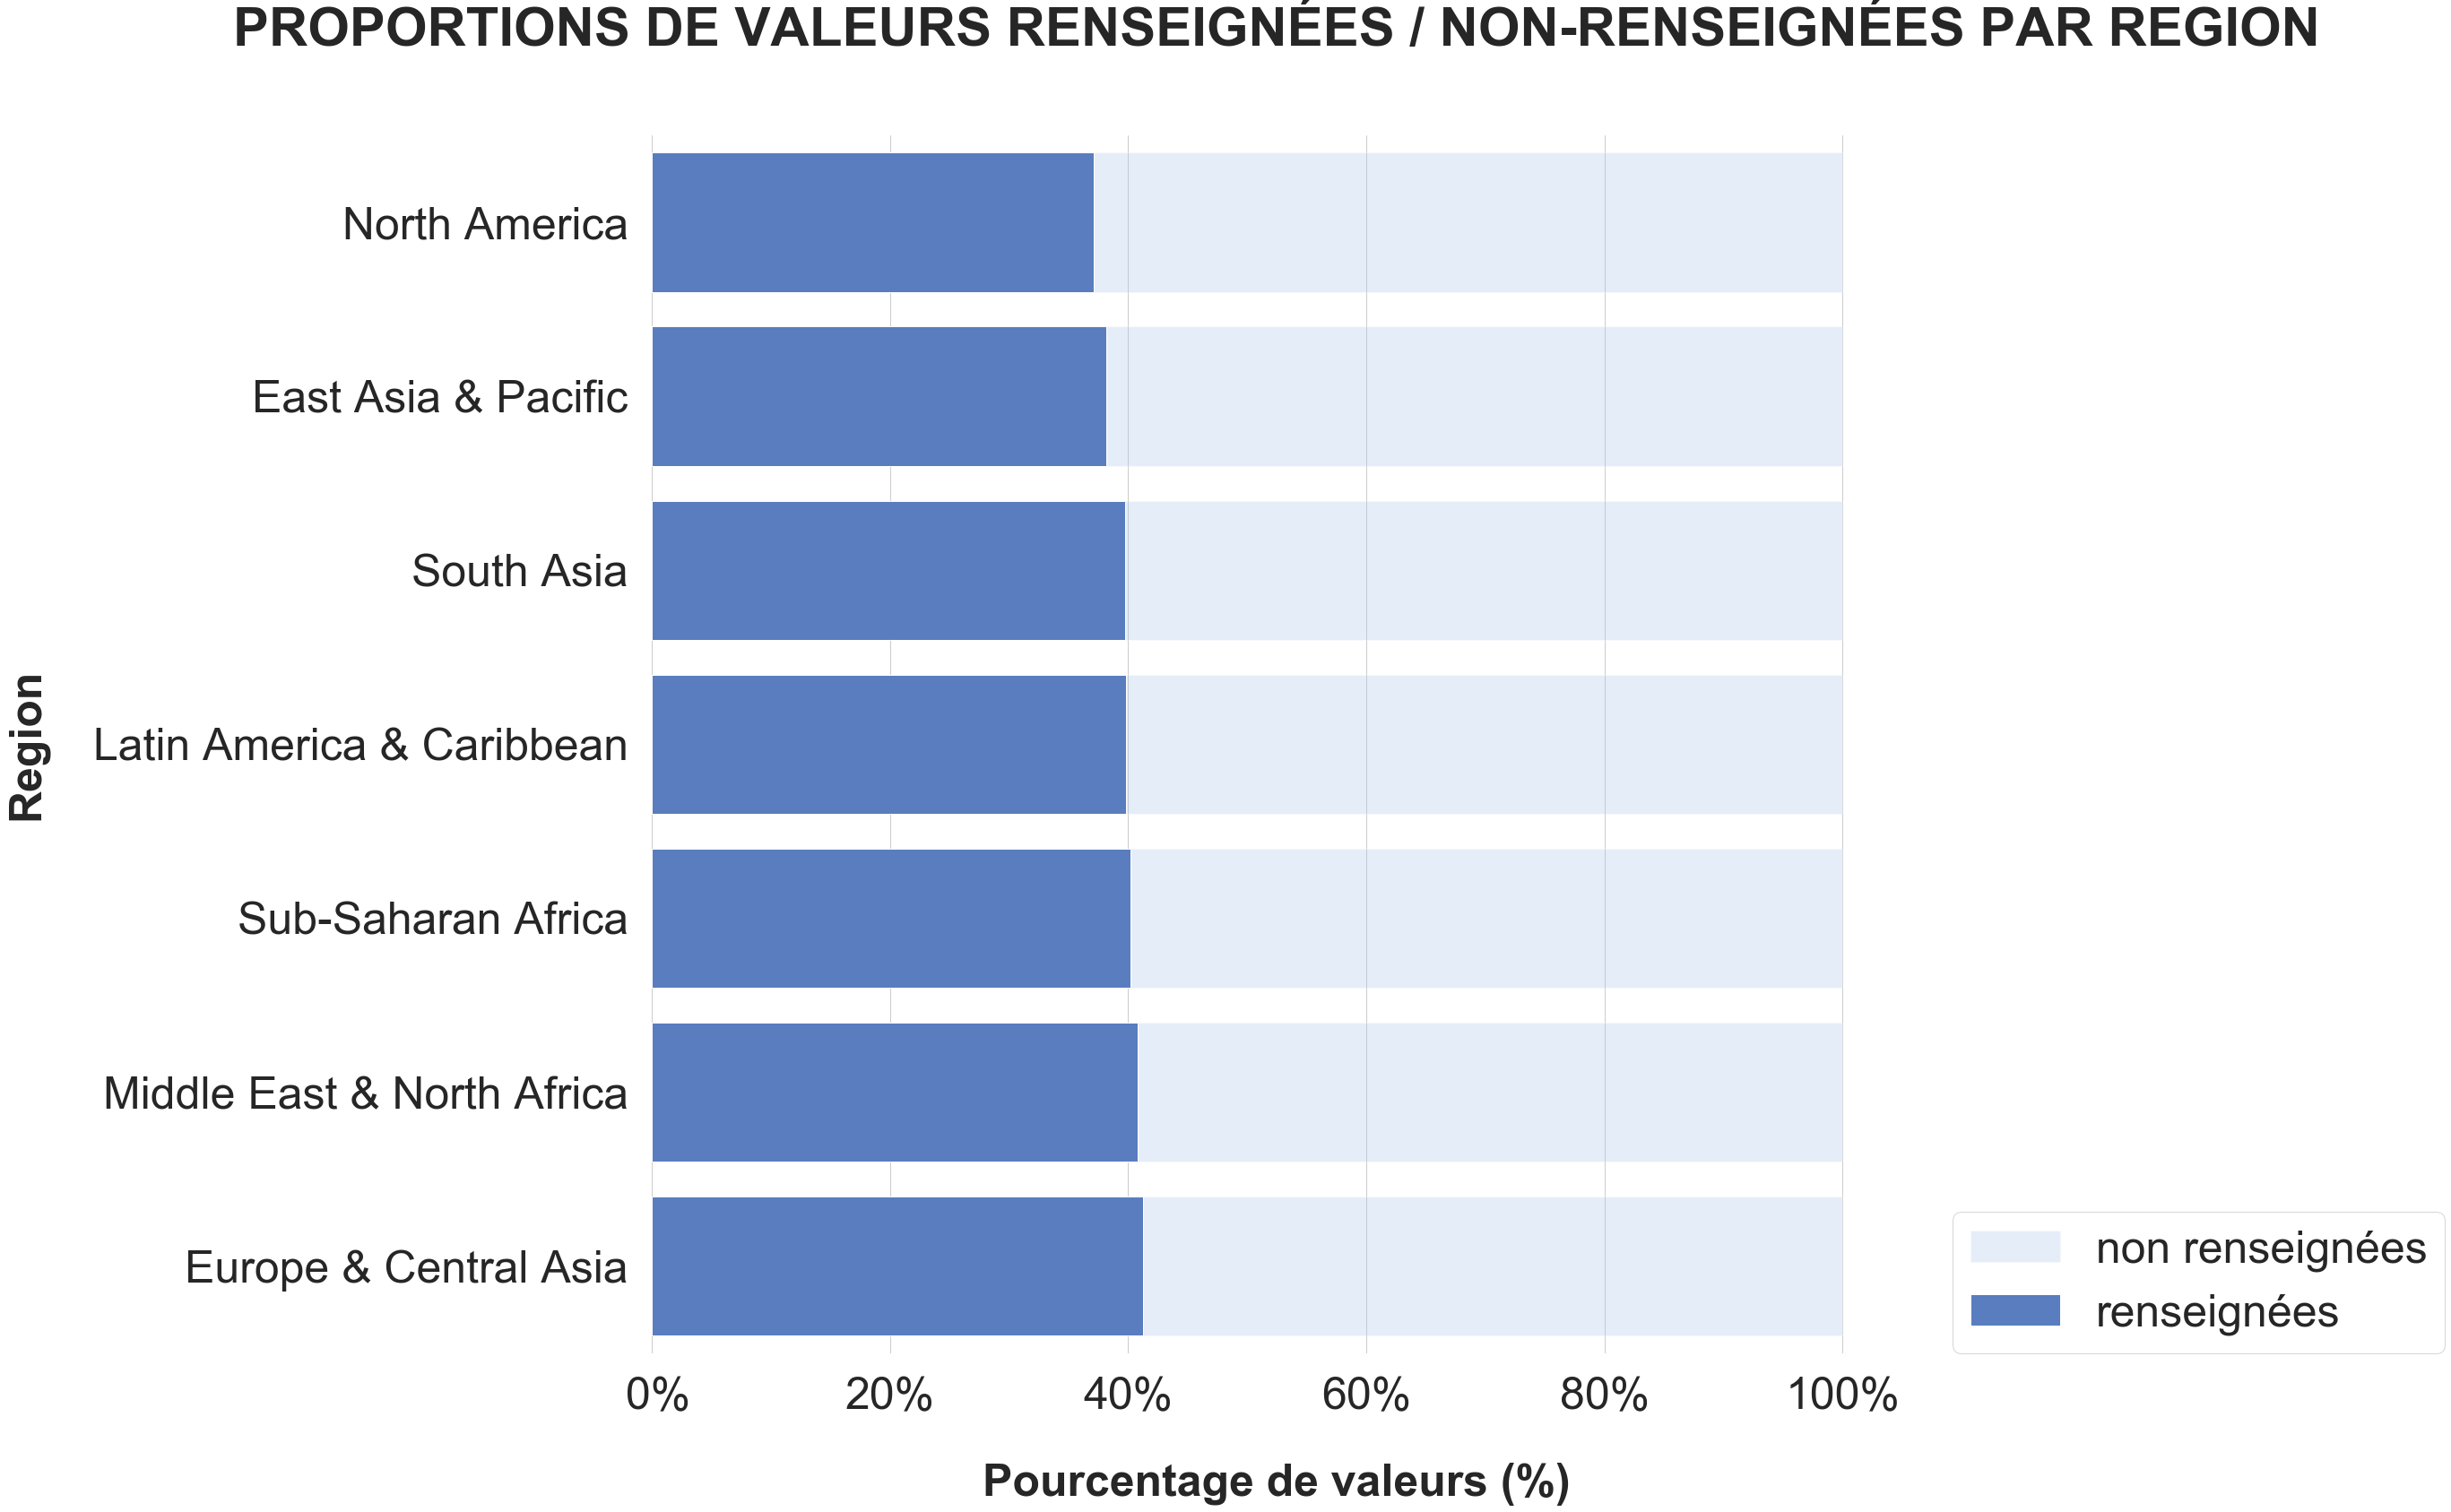

In [15]:
hf.plotPercentageMissingValuesFor(topic_region_education_data, "Region", 25, 25)

> **Moins de la moitié de l'ensemble des indicateurs descriptifs sont renseignés pour chaque région**

___
##### 1.3.1.2 <u>Proportion de valeurs manquantes par catégorie d'indicateurs</u>

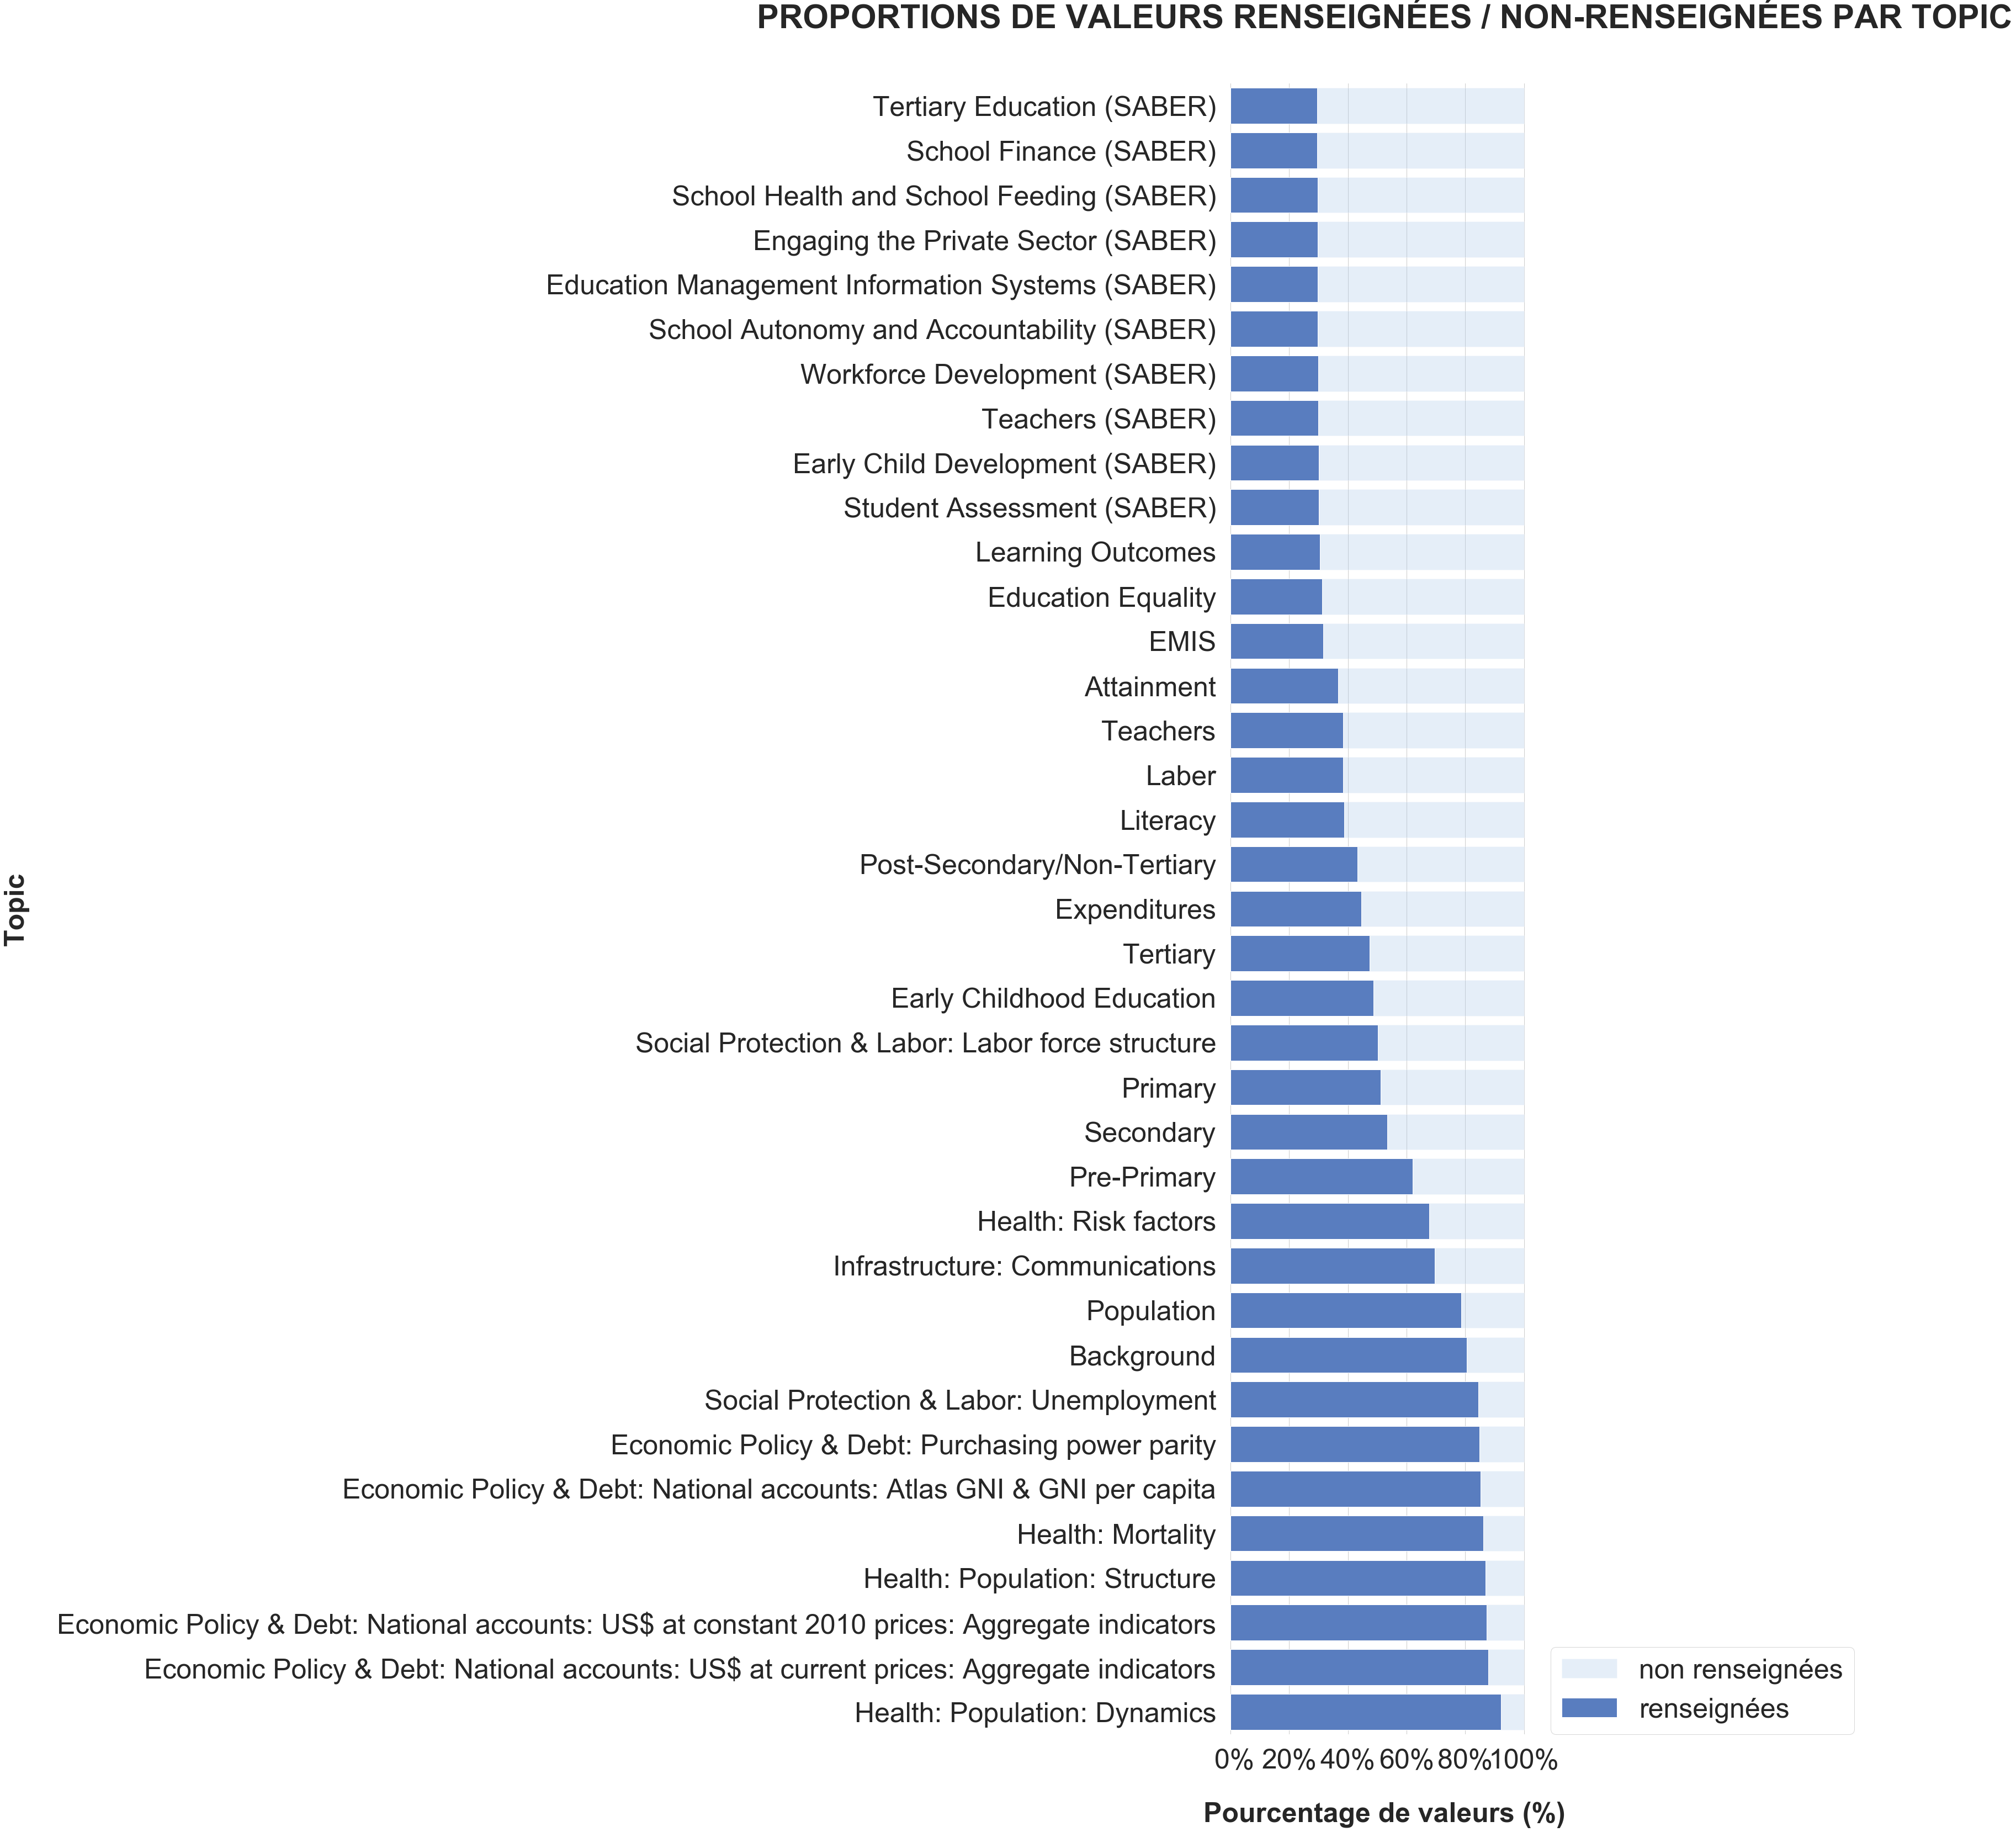

In [16]:
hf.plotPercentageMissingValuesFor(topic_region_education_data, "Topic", 10, 55)

> **Le taux de remplissage varie du simple au double entre certaines catégories d'indicateurs. 
<br>Un certain nombre de catégories d'indicateurs est relativement bien renseigné ( % de remplissage > 60% ).**

___
#### 1.3.2 DONNÉES DE PROJECTION

___
##### 1.3.2.1 <u>Proportion de valeurs manquantes par zones géographiques</u>

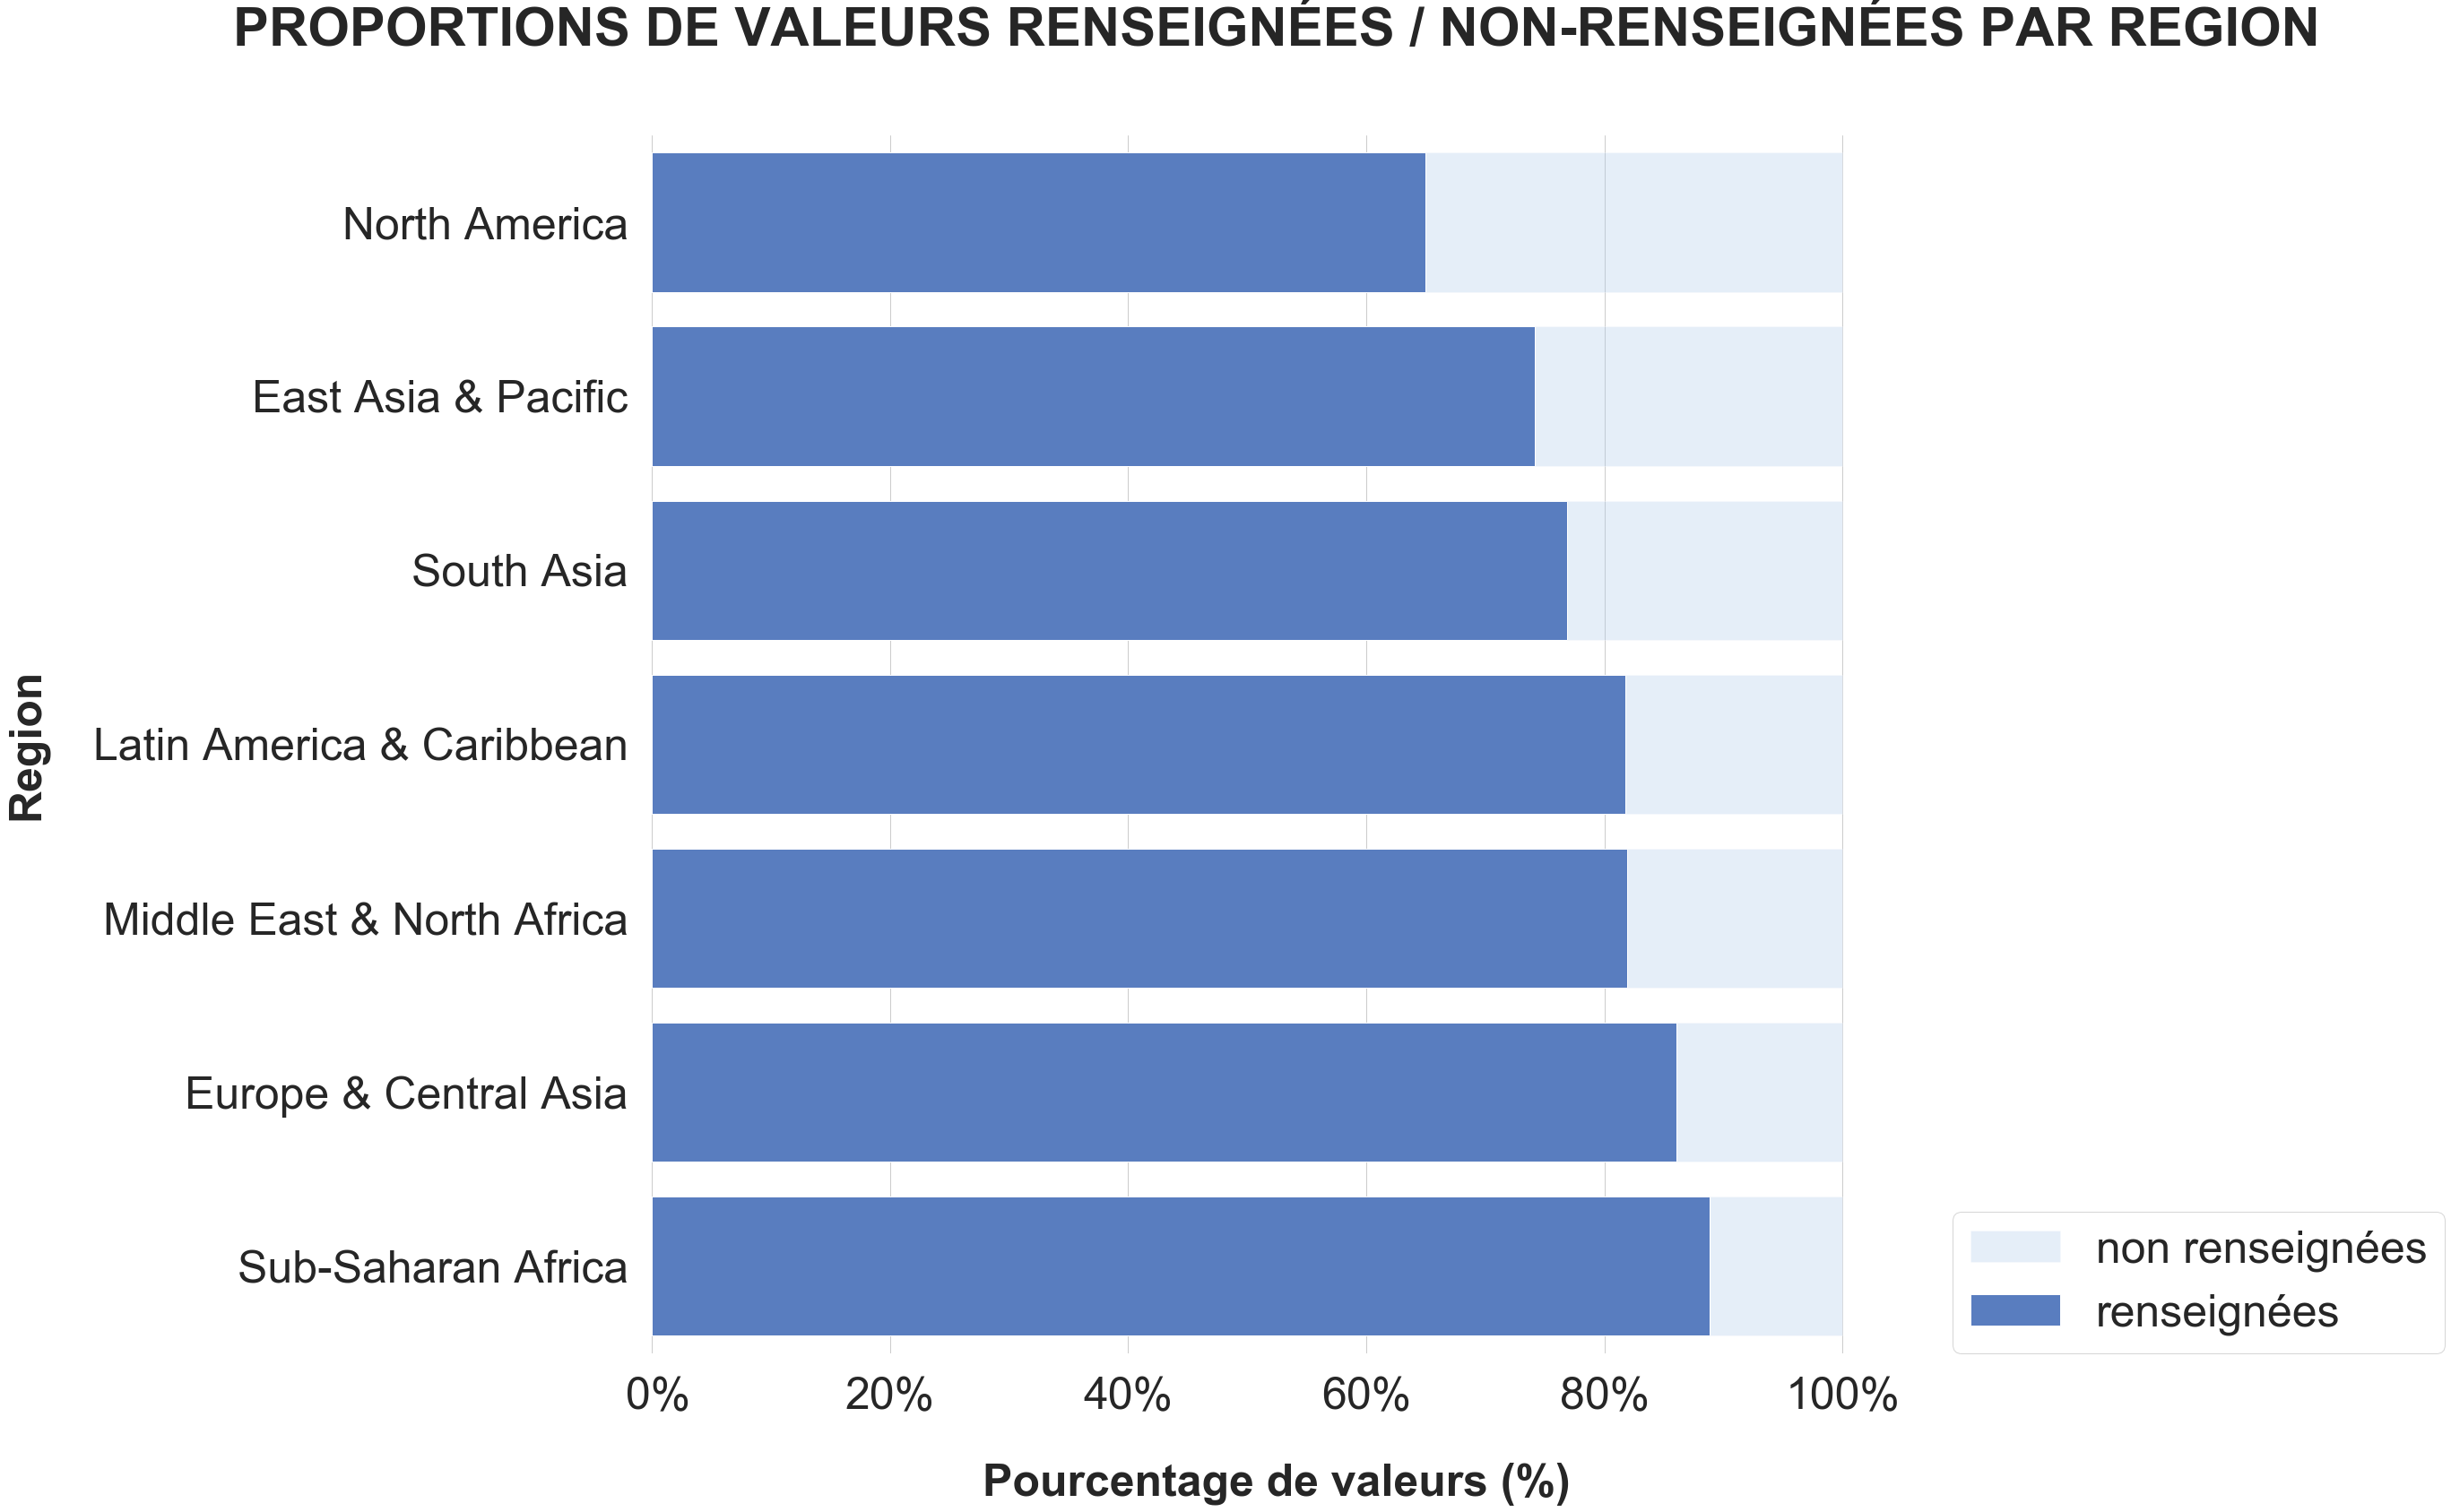

In [17]:
hf.plotPercentageMissingValuesFor(prj_topic_reg_ed_data, "Region", 25, 25)

> **Plus de la moitié de l'ensemble des indicateurs de projection sont renseignés pour chaque région**

___
##### 1.3.2.2 <u>Proportion de valeurs manquantes par catégorie d'indicateurs</u>

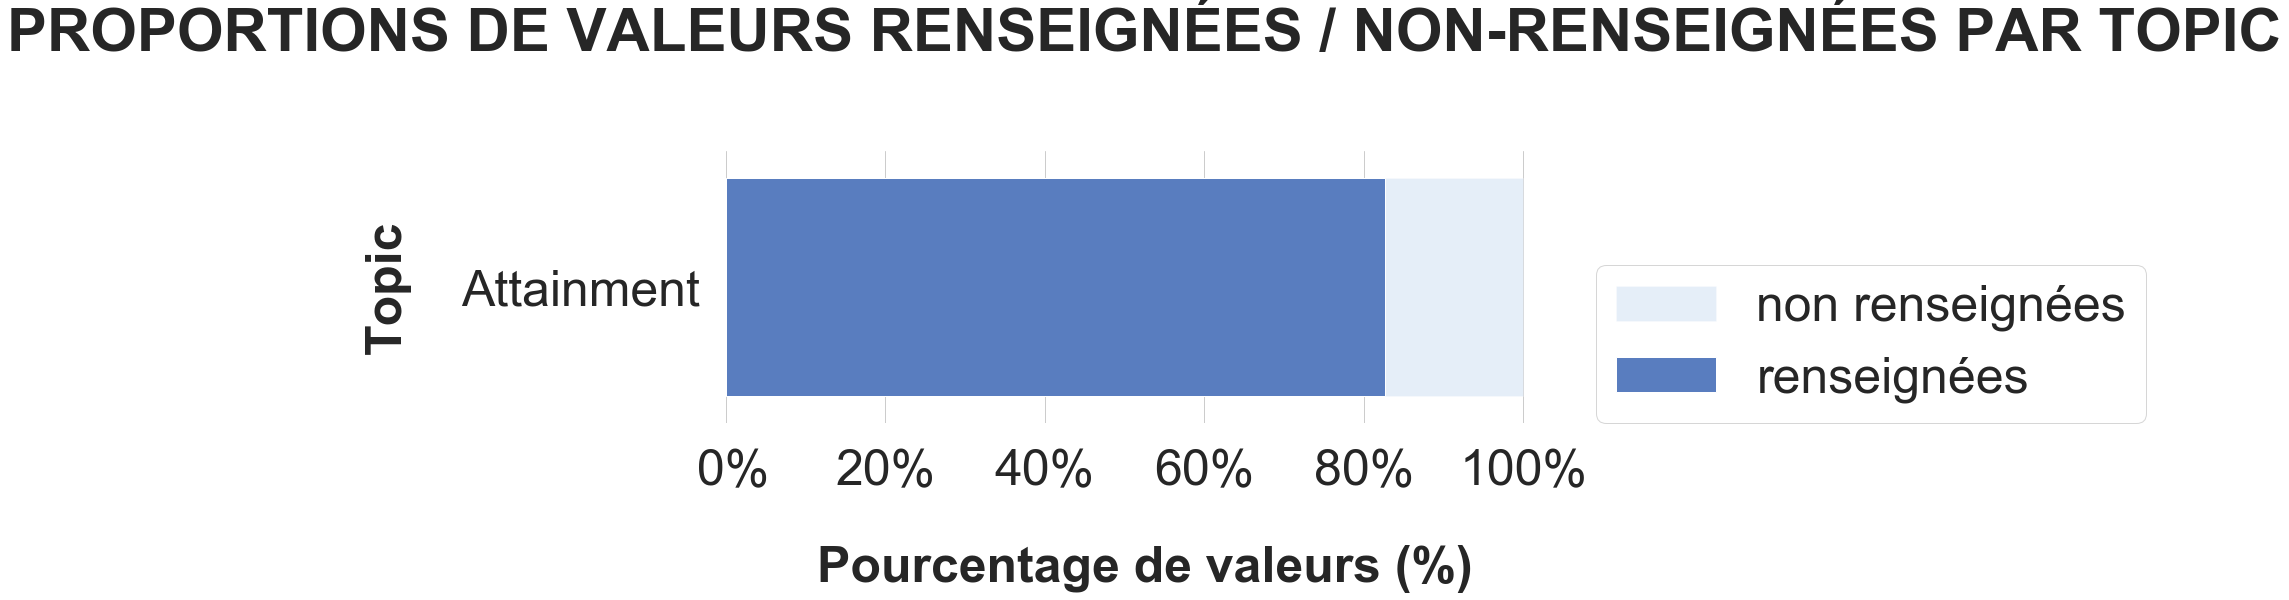

In [18]:
hf.plotPercentageMissingValuesFor(prj_topic_reg_ed_data, "Topic", 15, 5)

In [19]:
prj_m_m_val_ind = hf.getMissingValuesPercentPer(prj_topic_reg_ed_data,'Indicator Code')\
                    .sort_values(by=['Percent Missing'])
prj_m_m_val_ind['Percent Filled'] = 100 - prj_m_m_val_ind['Percent Missing']
prj_m_m_val_ind.drop(columns=['Percent Missing'], inplace=True)

pres_df = pd.DataFrame({'mean':prj_m_m_val_ind.mean(), 
                        'standard dev':prj_m_m_val_ind.std(), 
                        'median':prj_m_m_val_ind.median()})

pres_df

mean  standard dev     median
Percent Filled  82.702703  3.985515e-13  82.702703

> - **L'ensemble des indicateurs de projection sont regroupés dans la catégorie "Attainment"**
> - **Ils sont tous renseignés à hauteur de près de 83%.**

___
### Conclusion
- **<u>Données descriptives</u>**
    * Le jeu de données descriptive semble relativement peu rempli dans l'ensemble.
    * Aucune zone géographique ne se démarque en termes de complétude des données. 
    * Toutefois, un certain nombre de topics relativement bien renseignés sont présents, qui devraient  permettre de répondre aux problématiques.


- **<u>Données de projection</u>**
    * Le jeu de données de projection semble relativement bien rempli dans l'ensemble. 
    * Tous les indicateurs sont renseignés à hauteur de 77%.

___
## 2. PRÉ-ANALYSE EXPLORATOIRE
<br>
<br>
<br>

___

___
### 2.1 Détermination des catégories d'indicateurs pertinentes

- Au regard des problématiques posées, nous pouvons réduire le jeu de données aux topics pertinents, à savoir : 
    * les topics qui s'intéressent à la structure de la population, et en particulier les tranches secondaires ("lycée") et tertiaire ("université").
    * les topics qui s'intéressent au pouvoir d'achat des populations
    * les topics qui s'intéressent à l'accès à internet des populations.
<br>
<br>
- On remarque également des catégories de topics qui semblent recouper des sujets similaires: 
    * "Tertiary Education (SABER), "Tertiary"
    * l'ensemble des topics dont l'intitulé commence par "Economic Policy & Debt"
    * "Workforce development (SABER)", "Laber", "Social Protection & Labor : Labor force structure"
    * "Teachers (SABER)", "Teachers"
    * "Learning Outcomes", "Attainment", "EMIS"
    * "Health : Population : Structure", "Health : Population : Dynamics", "Population"
 

Pour ces raisons :
> - **Seuls seront considérés les topics pertinents à la problématique, dont le taux de remplissage dépasse les 60%.**
<br>
> - **Dans le cas de topics couvrant les mêmes sujets, seul le topic au taux de remplissage maximal sera conservé.**

On obtient ainsi la liste de topics suivante:

In [20]:
selected_topics = [
    'Attainment',
    'Tertiary',
    'Social Protection & Labor: Labor force structure',
    'Secondary',
    'Infrastructure: Communications',
    'Population',
    'Social Protection & Labor: Unemployment',
    'Economic Policy & Debt: National accounts: US$ at current prices: Aggregate indicators',
    'Health: Population: Dynamics',
    'Health: Population: Structure'
]

On restreint donc les données à ces seuls topics :

In [21]:
data = topic_region_education_data[topic_region_education_data['Topic'].isin(selected_topics)]

prj_data = prj_topic_reg_ed_data[prj_topic_reg_ed_data['Topic'].isin(selected_topics)]

___
### 2.2 Détermination des indicateurs pertinents

Afin d'avoir une analyse aussi fiable que possible, nous recherchons à obtenir des indicateurs au sein des topics choisis:
- ayant un taux de remplissage maximum
- couvrant un large spectre de topics
- commun à un maximum de zones géographiques

La dataframe de projection possèdant un taux de remplissage de plus de 70%, nous serons en mesure d'y sélectionner tout indicateur pertinent.

Pour la dataframe descriptive, il convient donc de déterminer un seuil de remplissage optimal par rapport aux trois points ci-dessus afin de discriminer les indicateurs que nous conserverons.

___
#### 2.2.1 DÉTERMINATION DU SEUIL OPTIMAL DE MANQUANTS (dataframe descriptive)

Pour déterminer le seuil optimal, nous allons dans un premier temps faire varier le seuil sur différentes valeurs. 
<br>
Pour chacune de ces valeurs, nous récupèrerons les indicateurs valides sur l'ensemble des régions
(taux de remplissage > seuil sur chaque région).

In [22]:
#-------------------------------------------------------------
# Pour chaque seuil, récupérer les indicateurs valides:
# - taux de manquants <= tr%
# - pour toutes les zones géographiques. 
#-------------------------------------------------------------

# nombre de zones géographiques
nb_of_regions = len(data['Region'].unique())

# Les différents seuils
thresholds = [30, 40, 50, 60, 70, 80]

common_valid_indicators = {}

# Pour chaque seuil
for threshold in thresholds:
    
    indicators = []
        
    # Pour chaque région
    for region, data_df in data.groupby('Region'): 
        
        indicators_per_region = {}
        
        # Calculer le % de manquants par indicateur
        missing_data_df = hf.getMissingValuesPercentPer(data_df,'Indicator Code')
        
        # Récupérer les indicateurs dont le % de manquants est < seuil
        a = missing_data_df[missing_data_df['Percent Missing'] <= threshold].reset_index()
        
        # Stocker dans la liste des indicators
        indicators.extend(a['Indicator Code'])

    #---------------------------------------------------------
    # Conserver uniquement les indicateurs valides sur toutes 
    # les zones géographiques : ils apparaissent exactement 
    # nb_of_regions fois dans la liste et les stocker dans un 
    # dictionnaire avec le seuil pour clé
    #---------------------------------------------------------

    common_valid_indicators[threshold] = [indicator for (indicator, occurrence) \
                                          in Counter(indicators).items() \
                                          if occurrence == nb_of_regions]

Le jeu de données est ensuite restreint aux seules données ayant trait aux indicateurs sélectionnées pour chaque seuil.

In [23]:
#-------------------------------------------------------------
# Pour chaque seuil, récupérer les données ayant trait aux
# indicateurs valides du seuil et les stocker dans un 
# dictionnaire avec le seuil pour clé.
#-------------------------------------------------------------

common_valid_indicators_data = {}

for seuil in thresholds:
    common_valid_indicators_data[seuil] = data[data['Indicator Code'].isin(common_valid_indicators[seuil])]

Nous pouvons ensuite récupérer et afficher le nombre d'indicateurs par topic pour chaque seuil.

In [24]:
#-------------------------------------------------------------
# Pour chaque seuil, déterminer le nombre d'indicateurs par
# topic.
#-------------------------------------------------------------
dataframe_dict = dict.fromkeys(selected_topics,[0] * len(thresholds))
list_counts_tmp = []

for idx_seuil, seuil in enumerate(thresholds):
    data_seuil = common_valid_indicators_data[seuil]
    
    for topic, list_counts in dataframe_dict.items():
        list_counts_tmp = list_counts.copy()
        
        data_seuil_topic = data_seuil[data_seuil['Topic']==topic]
                    
        list_counts_tmp[idx_seuil] = len(data_seuil_topic['Indicator Code'].unique())
            
        dataframe_dict[topic] = list_counts_tmp

In [25]:
#-------------------------------------------------------------
# Assembler les données pour les afficher dans un tableau
#-------------------------------------------------------------

data_to_plot_df = pd.DataFrame.from_dict(dataframe_dict,orient='index').T
data_to_plot_df['Seuil'] = thresholds

##### 2.2.1.1 <u>**Répartition des indicateurs par topic pour chaque seuil de manquants**</u>

In [26]:
data_to_plot_df.set_index("Seuil")

Attainment  Tertiary  Social Protection & Labor: Labor force structure  \
Seuil                                                                           
30              0         0                                                 2   
40              0         1                                                 2   
50              0        20                                                 2   
60              0        37                                                 2   
70            416       148                                                11   
80            425       148                                                11   

       Secondary  Infrastructure: Communications  Population  \
Seuil                                                          
30             3                               1          27   
40            36                               1         207   
50            70                               1         213   
60           117                               2         213   
70           161                               2         213   
80           248                               2         213   

       Social Protection & Labor: Unemployment  \
Seuil                                            
30                                           3   
40                                           3   
50                                           3   
60                                           3   
70                                           3   
80                                           3   

       Economic Policy & Debt: National accounts: US$ at current prices: Aggregate indicators  \
Seuil                                                                                           
30                                                     3                                        
40                                                     3                                        
50                                                     3                                        
60                                                     3                                        
70                                                     3                                        
80                                                     3                                        

       Health: Population: Dynamics  Health: Population: Structure  
Seuil                                                               
30                                1                             13  
40                                1                             13  
50                                1                             13  
60                                1                             13  
70                                1                             13  
80                                1                             13

In [27]:
#-------------------------------------------------------------
# Assembler les données pour les afficher sous forme de 
# graphique
#-------------------------------------------------------------

data_to_plot_df['Total'] = data_to_plot_df.iloc[:,:-1].sum(axis=1)

nb_indicators_per_seuil = data_to_plot_df[['Total', 'Seuil']]

data_to_plot_df = data_to_plot_df.drop(columns=['Seuil']).div(data_to_plot_df["Total"], axis=0)*100

data_to_plot_df = data_to_plot_df.cumsum(axis=1)

data_to_plot_df['Seuil'] = thresholds

data_to_plot_df = data_to_plot_df.set_index('Seuil').drop(columns=['Total'])

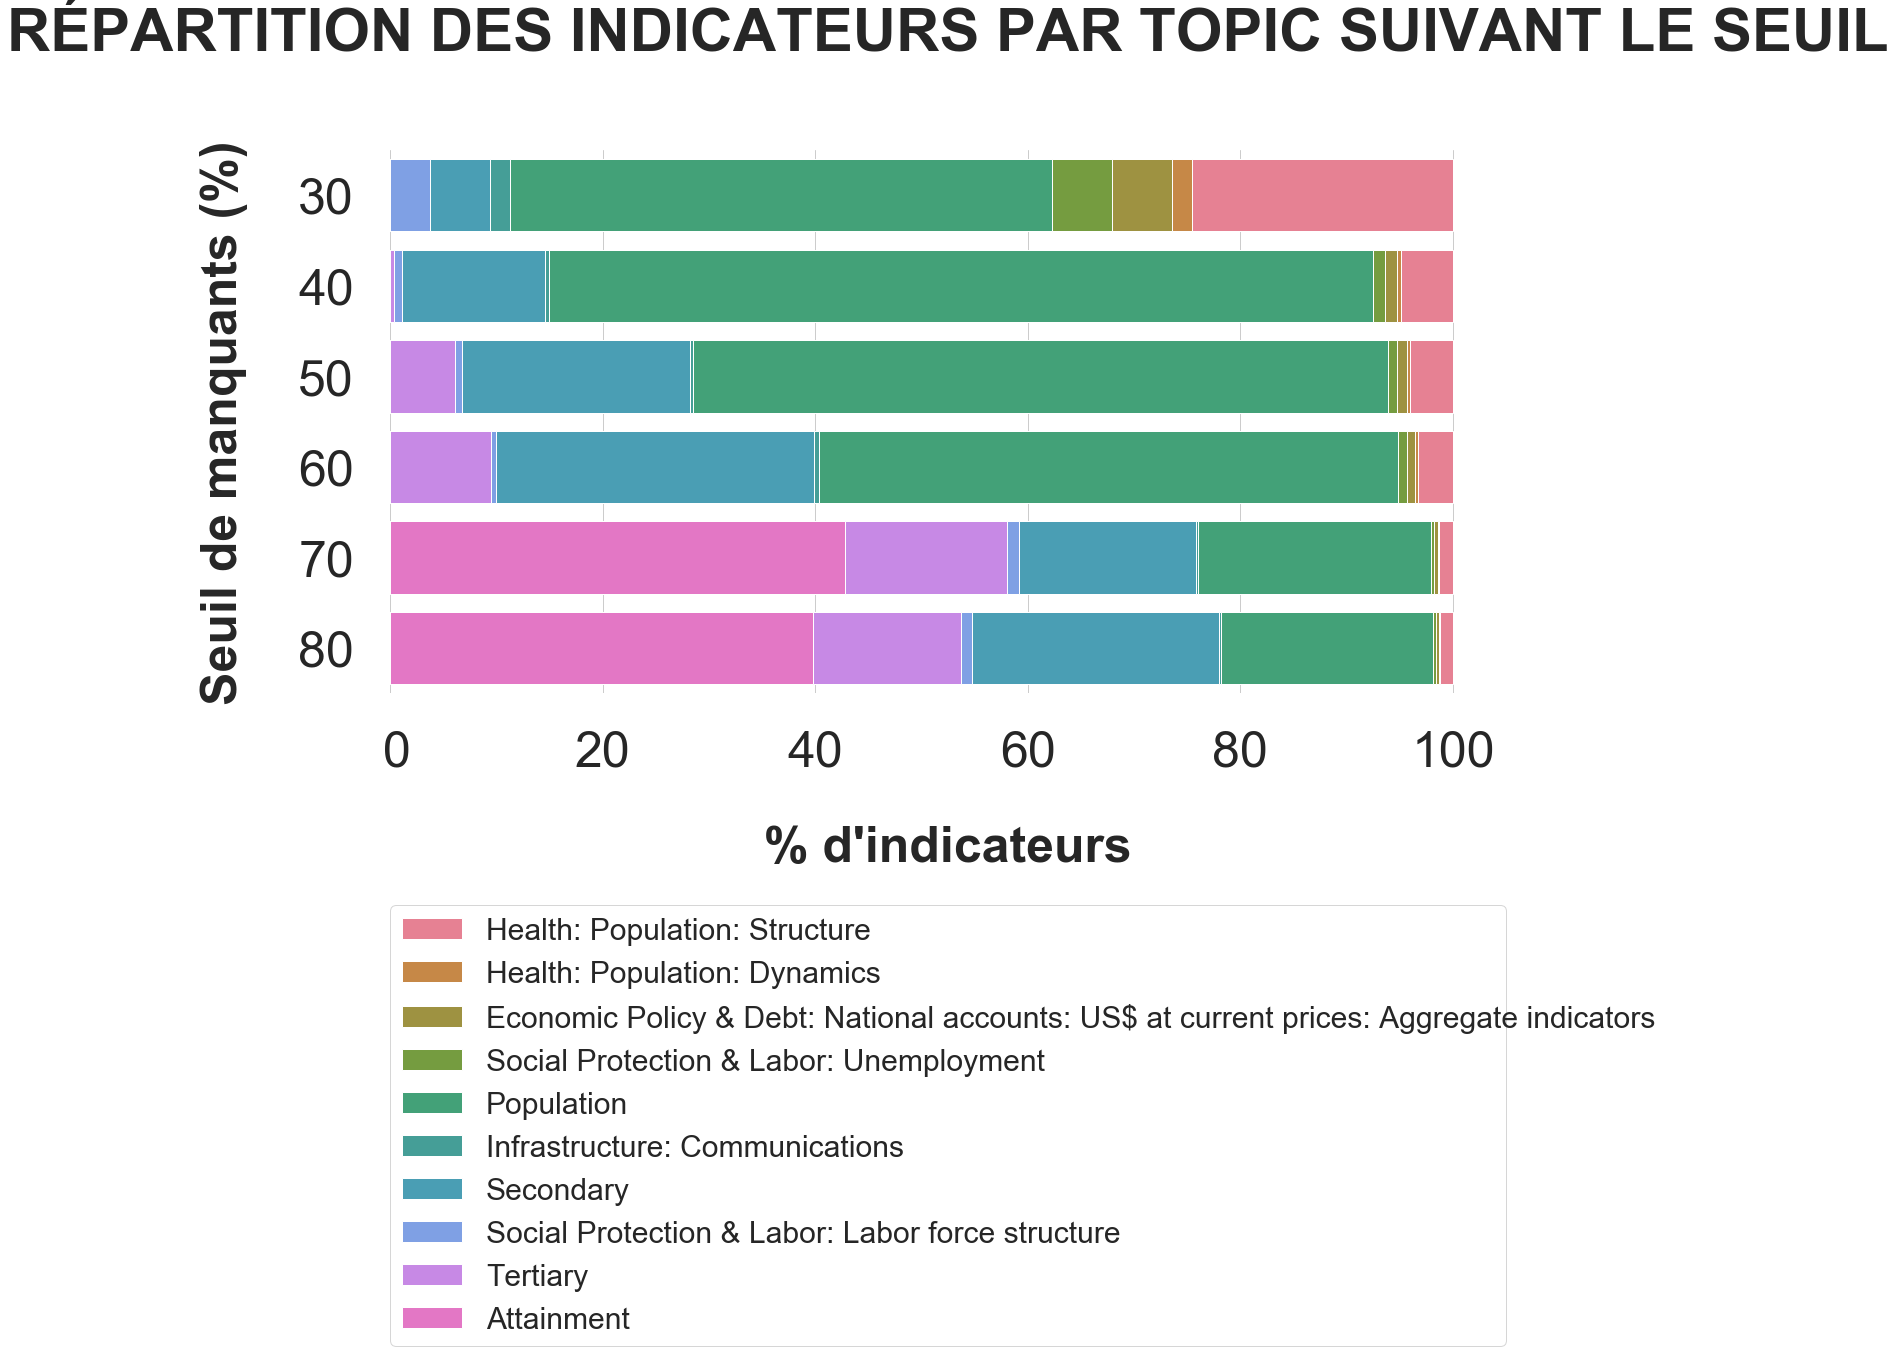

In [28]:
hf.plotIndicatorFrequencyForTopic(data_to_plot_df, 20, 10)

##### 2.2.1.2 **<u>Nombres d'indicateurs par seuil de manquants</u>**

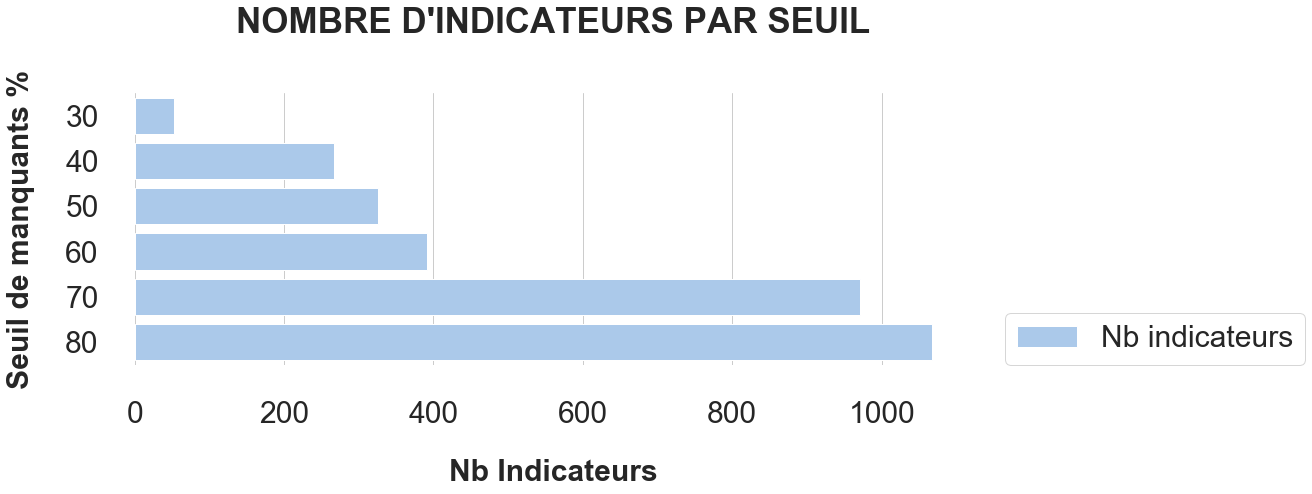

In [29]:
hf.plotHistogram(nb_indicators_per_seuil, 15,5)

On constate sur les deux graphiques que le seuil 60 constitue un vrai point pivot:
- Le premier graphe montre un déséquilibre important de la proportion d'indicateurs de la catégorie "Attainment" au-delà du seuil 60 (près de 50% de l'ensemble des indicateurs)
- Le nombre d'indicateurs total passe d'environ 400 à près de 1200, soit une augmentation de 300%. Des indicateurs qui ne sont remplis qu'à 30% ou moins.

> **Le meilleur seuil pour une bonne diversification des indicateurs tout en conservant des taux de remplissage intéressants sur l'ensemble des régions est de 60.**

In [30]:
SEUIL = 60

In [31]:
indicators_selected = common_valid_indicators[SEUIL]

___
#### 2.2.2 SÉLECTION DES INDICATEURS FINAUX

_**Rappel de la problématique : la cible potentielle est au lycée / à l'université, ou travaille, et a accès à internet.**_
    
Les indicateurs sélectionnés peuvent maintenant être examinés de plus près afin de déterminer leur pertinence vis à vis de la problématique.

Pour ce faire, l'ensemble des indicateurs sélectionnés et leur descriptif sont exportés dans un fichier .csv.

In [32]:
education_data_series[education_data_series['Indicator Code'].isin(indicators_selected)]\
                                                             .to_csv("tmp_selected_indicators.csv")

Après vérification des indicateurs sélectionnés exportés, il apparaît que :
- De nombreux indicateurs ne sont pas pertinents par rapport à la question (enfants en bas âge...) 
- Certains indicateurs sont des doublons d'autres indicateurs
- Certains indicateurs représentent des sous-ensembles d'autres indicateurs
   
**En affinant à nouveaux les indicateurs en conséquence, on obtient la liste des indicateurs finaux:**

In [33]:
# indicateurs descriptifs
final_inds_desc = [
    'IT.CMP.PCMP.P2',
    'IT.NET.USER.P2',
    'NY.GDP.PCAP.CD',
    'SE.SEC.ENRL',
    'SE.SEC.ENRR',
    'SE.SEC.PRIV.ZS',
    'SE.TER.ENRL',
    'SE.TER.ENRR',
    'SE.TER.PRIV.ZS',
    'SL.TLF.TOTL.IN',
    'SL.UEM.TOTL.ZS',
    'SP.POP.GROW',
    'SP.POP.TOTL',
    'SP.SEC.TOTL.IN',
    'SP.TER.TOTL.IN', 
]

# indicateurs de projection
final_inds_prj = [
    'PRJ.ATT.15UP.1.MF',
    'PRJ.ATT.15UP.3.MF',
    'PRJ.ATT.15UP.4.MF'
]

##### 2.2.2.1 <u>**Description des indicateurs finaux**</u>

**Indicateurs descriptifs**

In [34]:
education_data_series[education_data_series['Indicator Code'].isin(final_inds_desc)].iloc[:,:3]\
                     .reset_index(drop=True)\
                     .set_index('Indicator Code')

Topic  \
Indicator Code                                                      
IT.CMP.PCMP.P2                     Infrastructure: Communications   
IT.NET.USER.P2                     Infrastructure: Communications   
NY.GDP.PCAP.CD  Economic Policy & Debt: National accounts: US$...   
SE.SEC.ENRL                                             Secondary   
SE.SEC.ENRR                                             Secondary   
SE.SEC.PRIV.ZS                                          Secondary   
SE.TER.ENRL                                              Tertiary   
SE.TER.ENRR                                              Tertiary   
SE.TER.PRIV.ZS                                           Tertiary   
SL.TLF.TOTL.IN   Social Protection & Labor: Labor force structure   
SL.UEM.TOTL.ZS            Social Protection & Labor: Unemployment   
SP.POP.GROW                          Health: Population: Dynamics   
SP.POP.TOTL                         Health: Population: Structure   
SP.SEC.TOTL.IN                                         Population   
SP.TER.TOTL.IN                                         Population   

                                            Indicator Description  
Indicator Code                                                     
IT.CMP.PCMP.P2                Personal computers (per 100 people)  
IT.NET.USER.P2                    Internet users (per 100 people)  
NY.GDP.PCAP.CD                       GDP per capita (current US$)  
SE.SEC.ENRL     Enrolment in secondary education, both sexes (...  
SE.SEC.ENRR      Gross enrolment ratio, secondary, both sexes (%)  
SE.SEC.PRIV.ZS  Percentage of enrolment in secondary education...  
SE.TER.ENRL     Enrolment in tertiary education, all programme...  
SE.TER.ENRR       Gross enrolment ratio, tertiary, both sexes (%)  
SE.TER.PRIV.ZS  Percentage of enrolment in tertiary education ...  
SL.TLF.TOTL.IN                                 Labor force, total  
SL.UEM.TOTL.ZS  Unemployment, total (% of total labor force) (...  
SP.POP.GROW                          Population growth (annual %)  
SP.POP.TOTL                                     Population, total  
SP.SEC.TOTL.IN  Population of the official age for secondary e...  
SP.TER.TOTL.IN  Population of the official age for tertiary ed...

**Indicateurs de projection**

In [35]:
education_data_series[education_data_series['Indicator Code'].isin(final_inds_prj)].iloc[:,:3]\
                     .reset_index(drop=True)\
                     .set_index('Indicator Code')

Topic  \
Indicator Code                  
PRJ.ATT.15UP.1.MF  Attainment   
PRJ.ATT.15UP.3.MF  Attainment   
PRJ.ATT.15UP.4.MF  Attainment   

                                               Indicator Description  
Indicator Code                                                        
PRJ.ATT.15UP.1.MF  Projection: Percentage of the population age 1...  
PRJ.ATT.15UP.3.MF  Projection: Percentage of the population age 1...  
PRJ.ATT.15UP.4.MF  Projection: Percentage of the population age 1...

##### 2.2.2.2 <u>**Répartition des indicateurs finaux**</u>

On restreint les données à celles ayant trait aux seuls indicateurs finaux:

In [36]:
#-------------------------------------------------------------
# Restriction des données aux seuls indicateurs finaux
#-------------------------------------------------------------

data_final_inds_desc = topic_region_education_data
data_final_inds_desc = data_final_inds_desc[data_final_inds_desc['Indicator Code'].isin(final_inds_desc)]

data_final_inds_prj = prj_topic_reg_ed_data
data_final_inds_prj = data_final_inds_prj[data_final_inds_prj['Indicator Code'].isin(final_inds_prj)]

total_data = pd.concat([data_final_inds_desc, data_final_inds_prj])

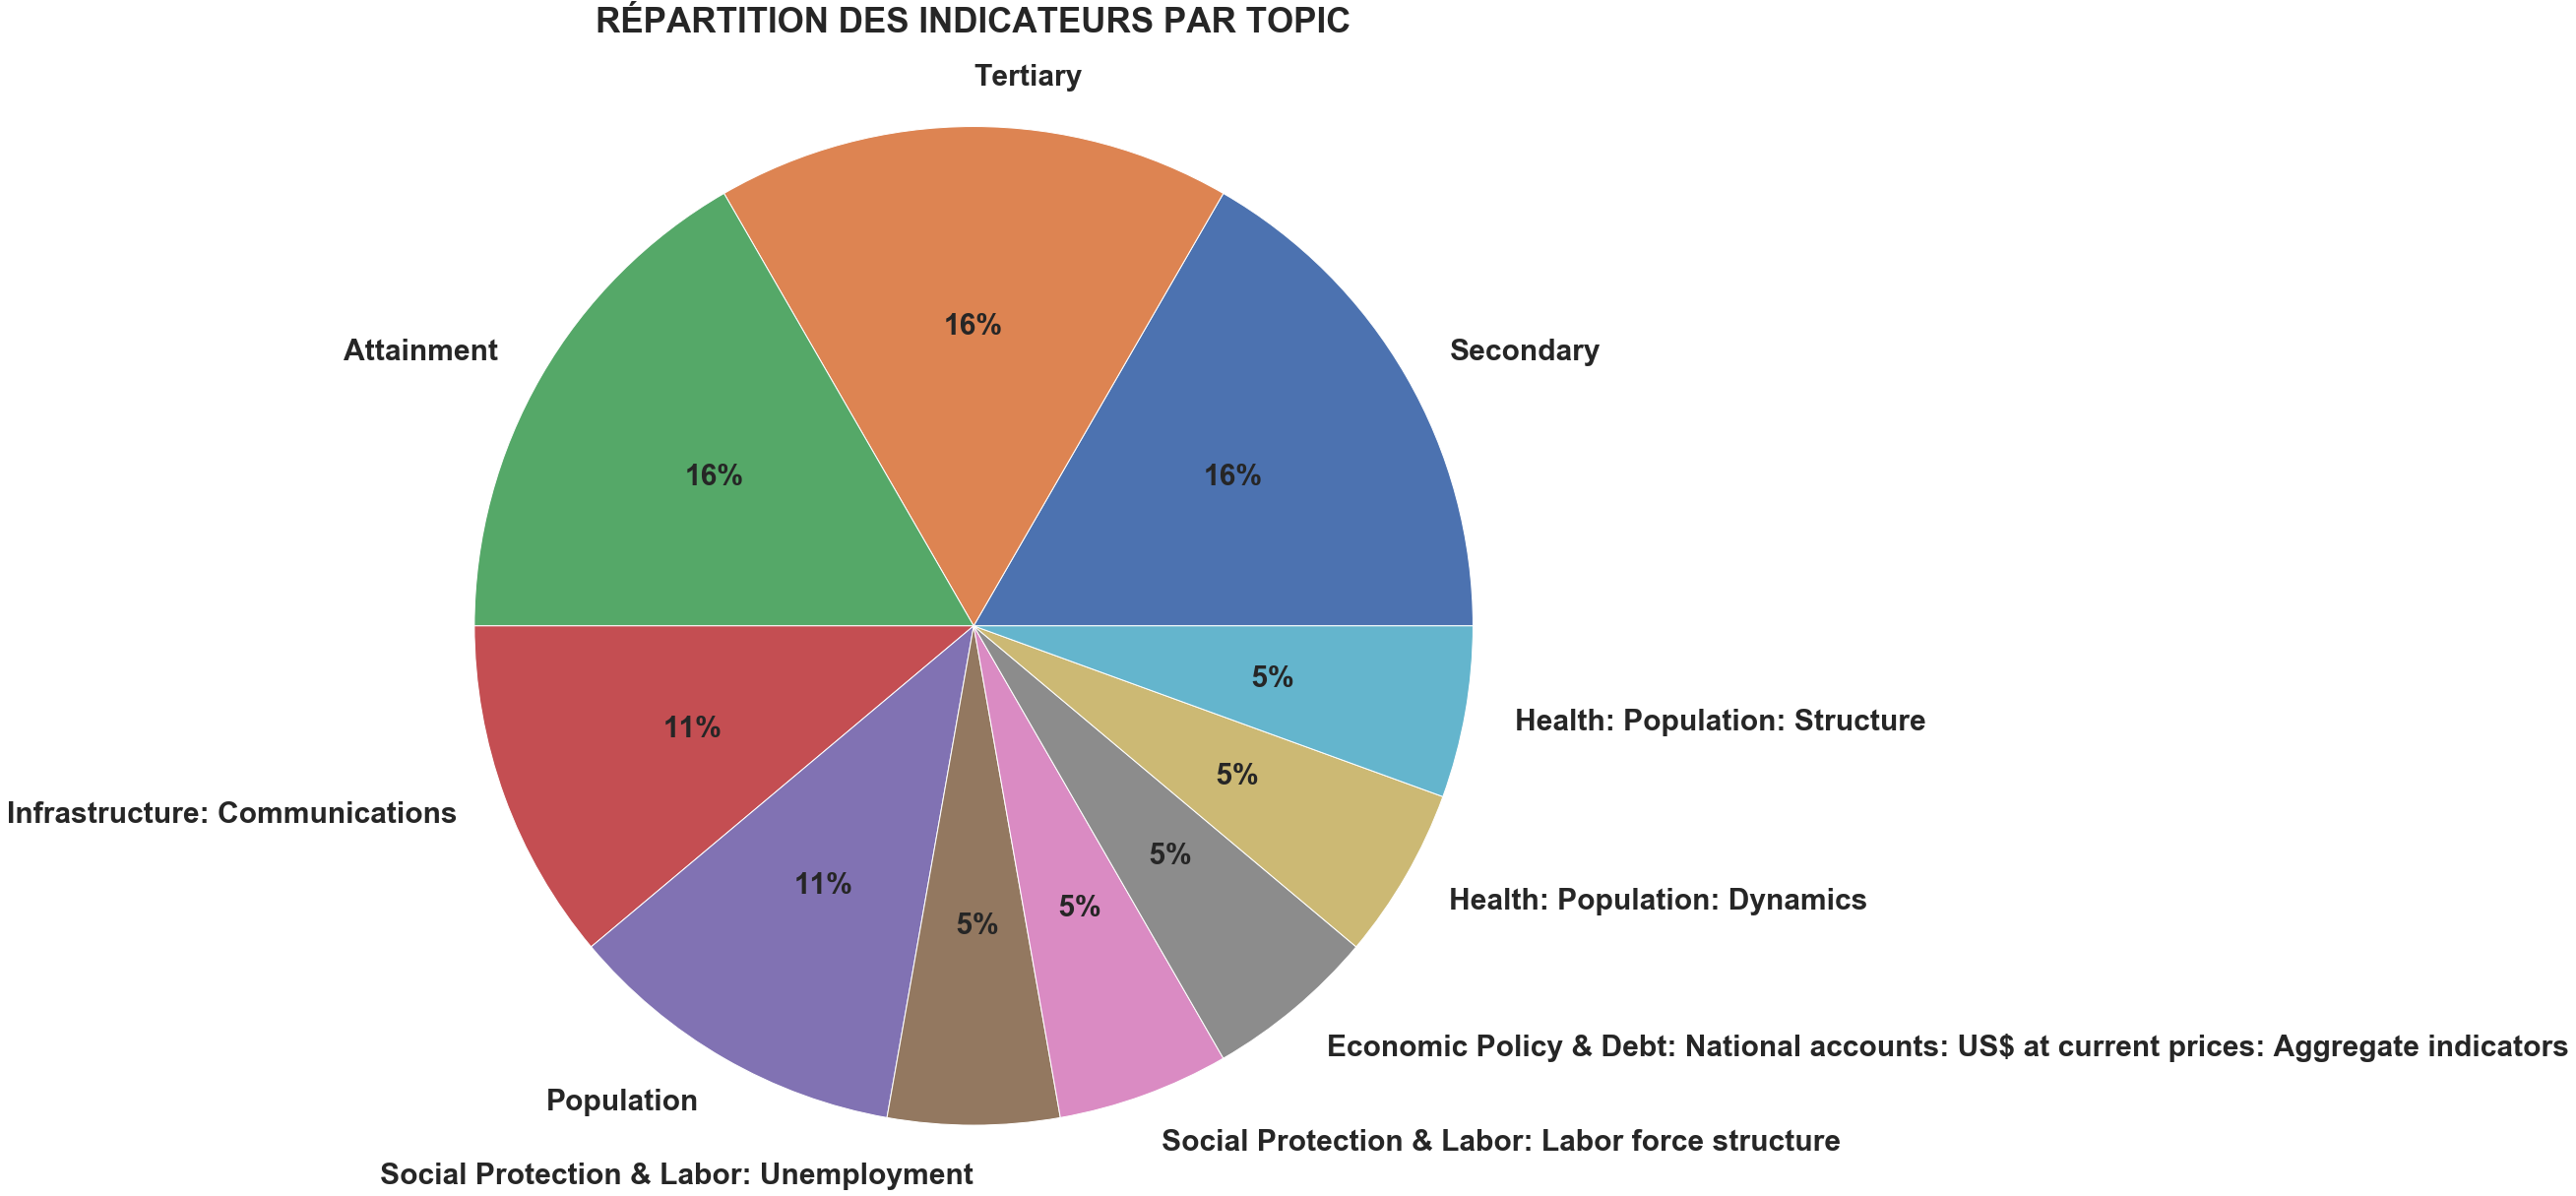

In [37]:
hf.plotRepartitionTopics(total_data, 20, 20)

##### 2.2.2.3 **<u>Proportion de manquants des indicateurs finaux</u>**

**Indicateurs descriptifs**

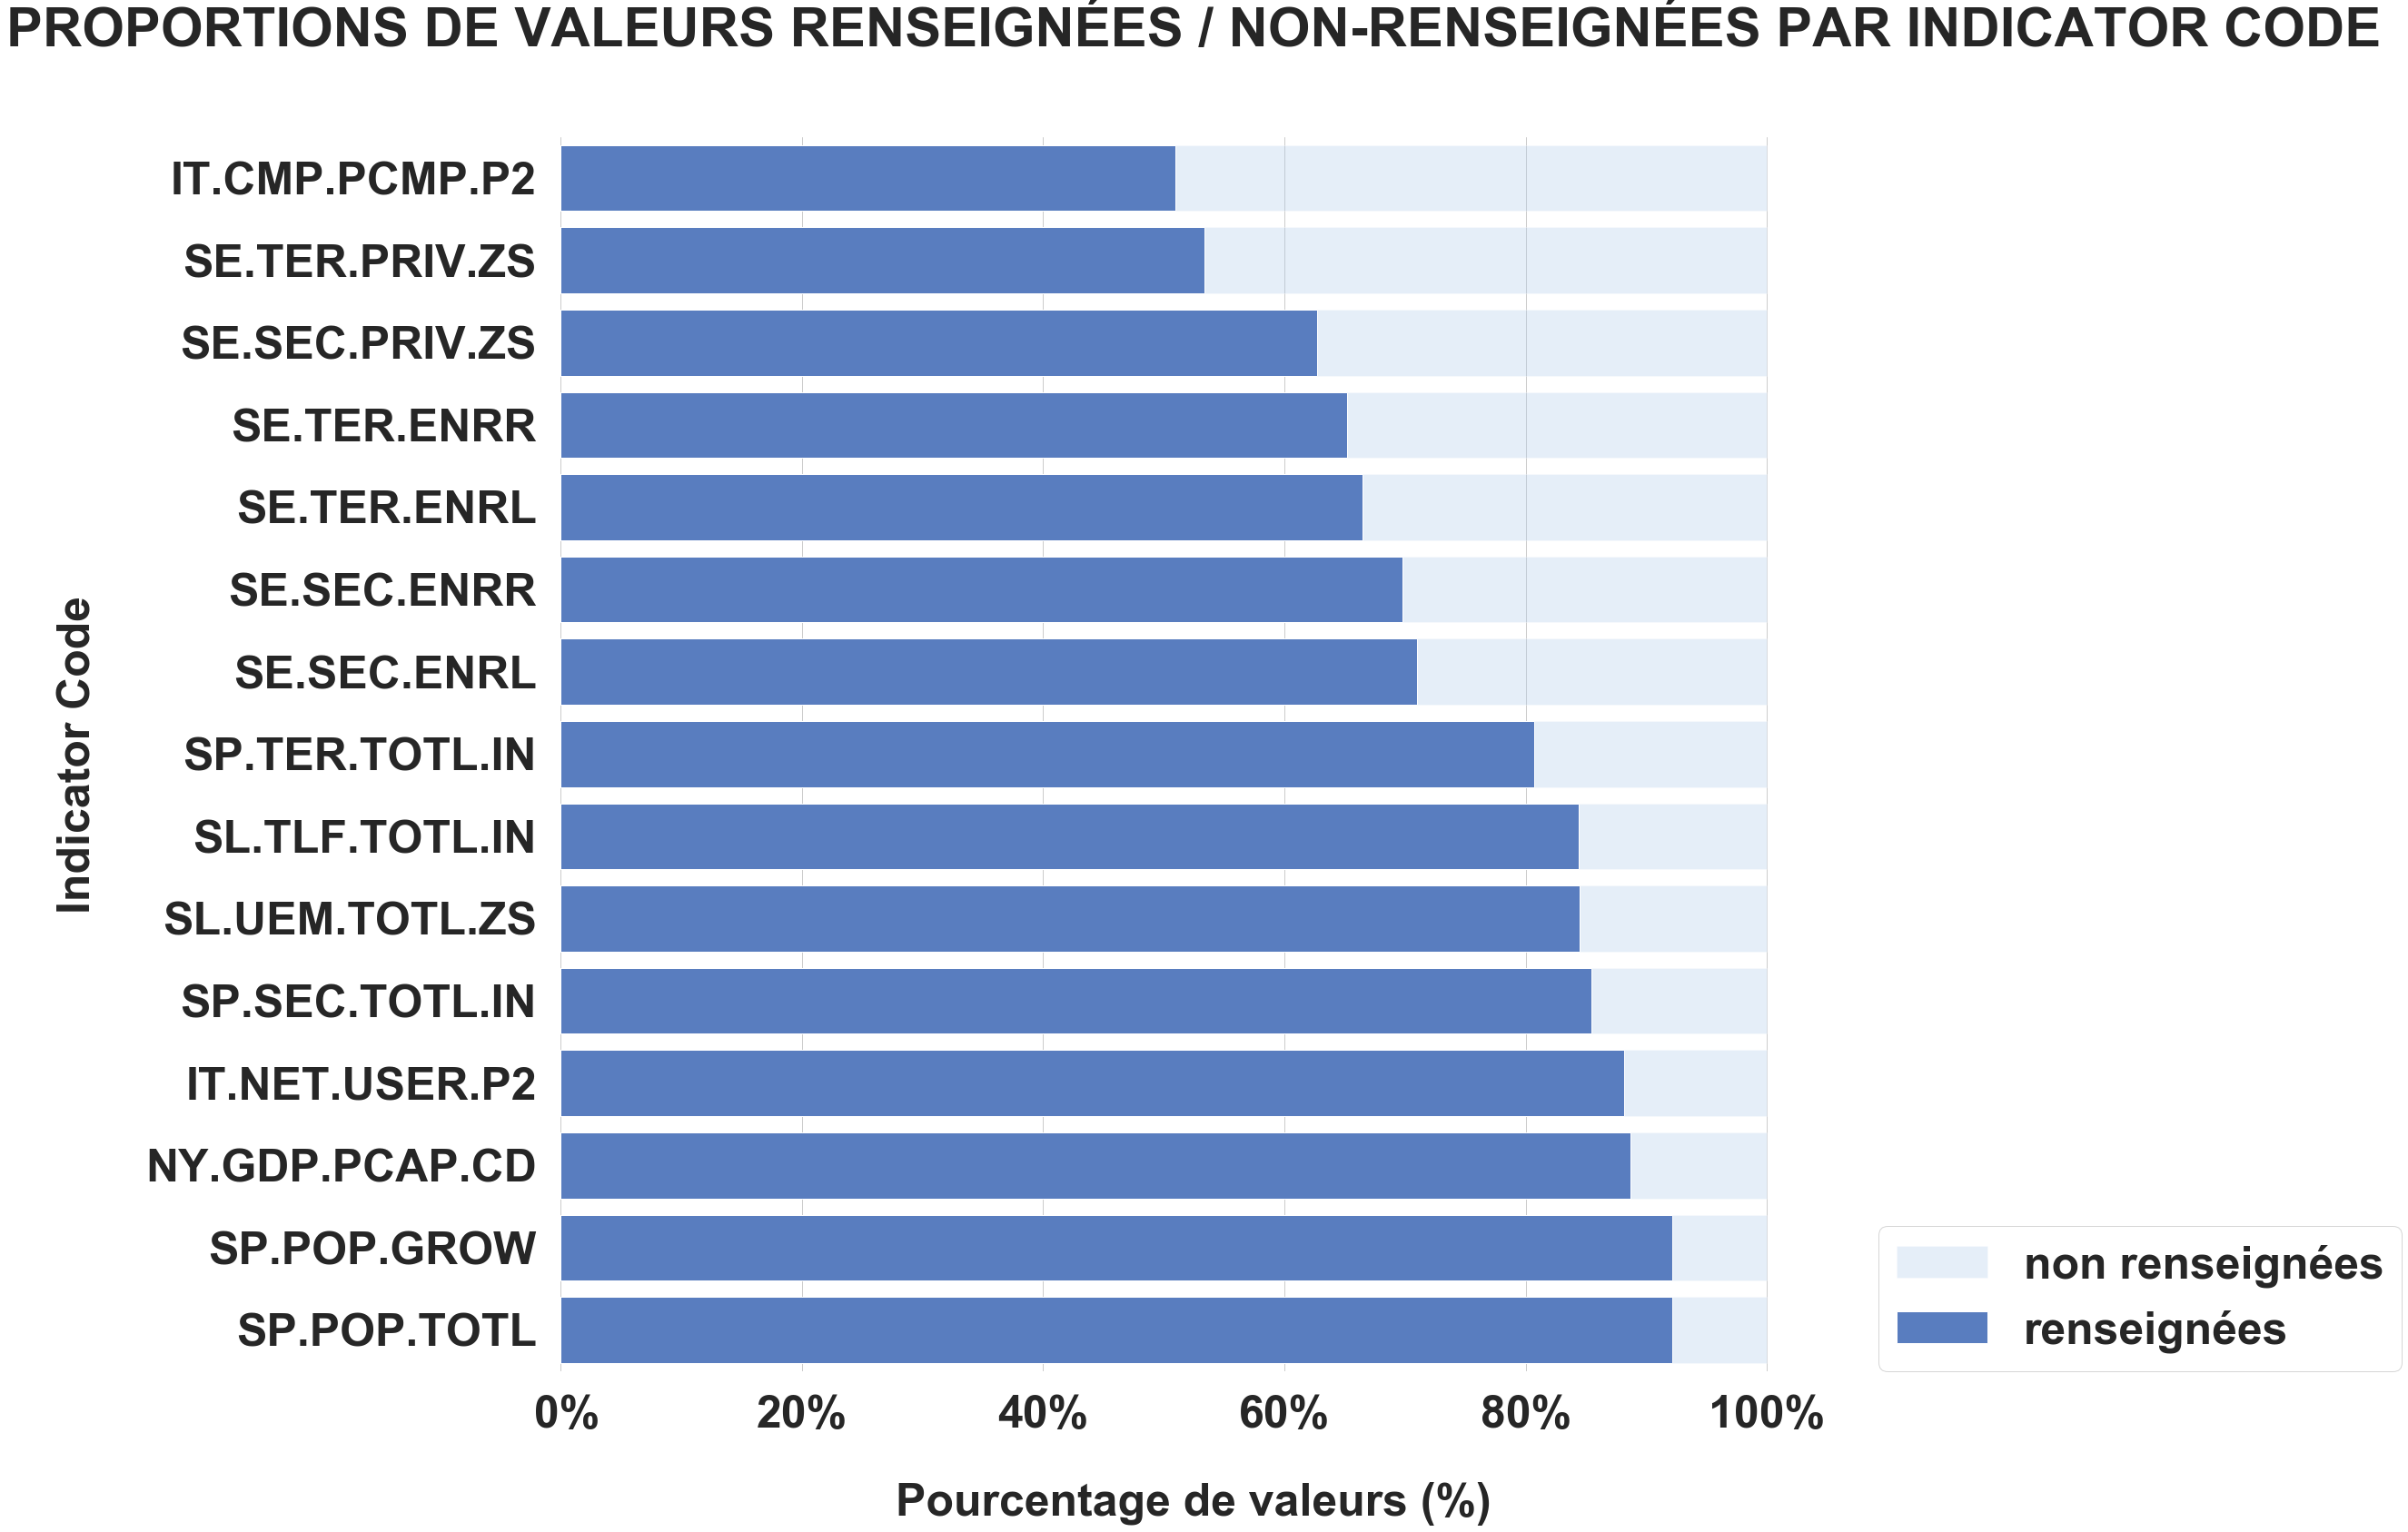

In [38]:
hf.plotPercentageMissingValuesFor(data_final_inds_desc, 'Indicator Code', 25, 25)

**Indicateurs de projection**

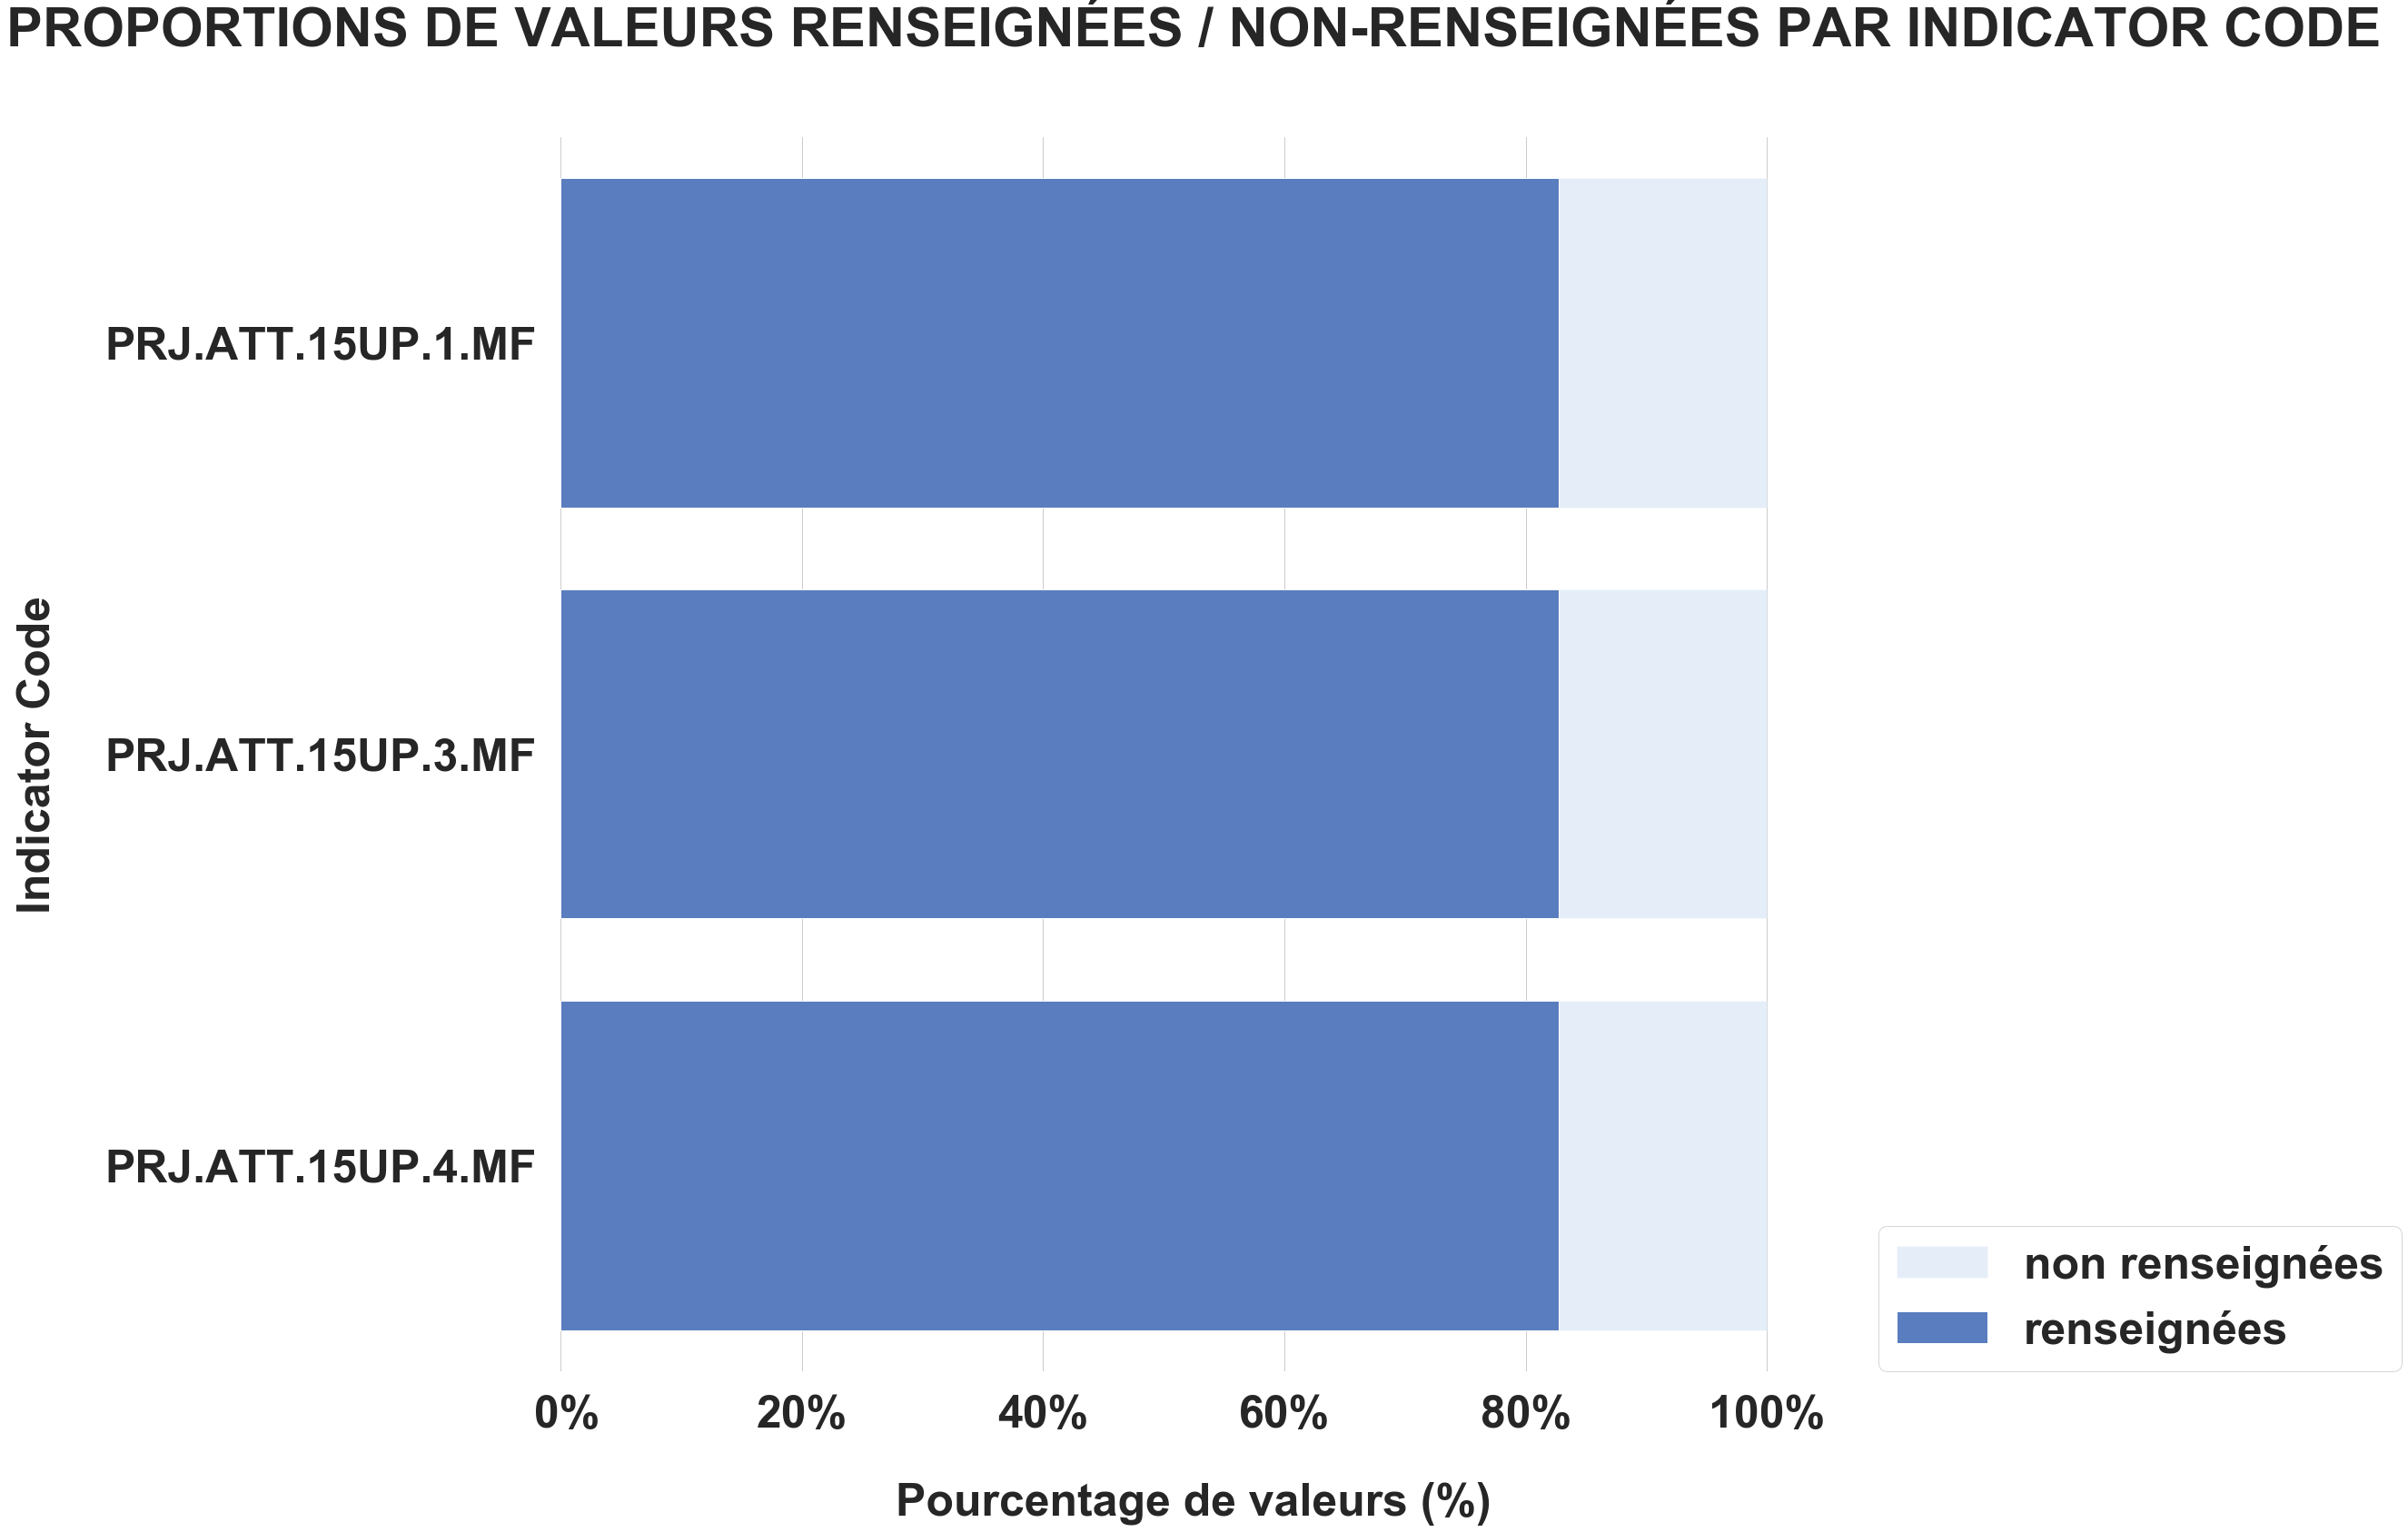

In [39]:
hf.plotPercentageMissingValuesFor(data_final_inds_prj, 'Indicator Code', 25, 25)

___
### Conclusion
> **Ces indicateurs couvrent l'ensemble des domaines d'intérêt pour la démarche et sont suffisamment renseignés pour pouvoir répondre aux problématiques posées.**

___
### 2.3 Détermination des zones géographiques d'intérêt

Afin de pouvoir réaliser des comparaisons pertinentes entre régions, l'analyse commencera par se focaliser sur les indicateurs en pourcents ou par personne.

In [40]:
final_inds_pct = [
    'IT.CMP.PCMP.P2',
    'IT.NET.USER.P2',
    'NY.GDP.PCAP.CD',
    'SE.SEC.ENRR',
    'SE.SEC.PRIV.ZS',
    'SE.TER.ENRR',
    'SE.TER.PRIV.ZS',
    'SP.POP.GROW'
]

___
#### 2.3.1 MISE EN PLACE

##### 2.3.1.1 **<u>Création d'un indicateur de proportion pour la population active</u>**

Deux indicateurs en nombres absolus ayant trait à la population active (15 ans et plus) peuvent être utilisés pour créer un nouvel indicateur en %.

In [41]:
#-------------------------------------------------------------
# Création d'un indicateur en % sur la population active 
# (15 ans et plus)
#
# Pop active % = pop active (nbre) / pop active totale (nbre)
# indicateur % SL.TLF.TOTL.PCT = SL.TLF.TOTL.IN / SP.POP.TOTL
#-------------------------------------------------------------

# Préparation des paramètres d'entrée de la fonction d'inser-
# -tion de l'indicateur
list_names_nums_denoms = [ ('SL.TLF.TOTL.PCT','SL.TLF.TOTL.IN','SP.POP.TOTL')]

columns_with_update = [
    {
        "Indicator Name" : "Labor force, total (% of total population)",
        "Topic" : "Composite ",
        "Indicator Description" : "Labor force, total (% of total population)",
        "Long definition" : "Labor force, total (% of total population) \
                                                    = SL.TLF.TOTL.IN / SP.POP.TOTL"
    }
]

# Appel fonction d'insertion et récupération de la dataframe mise à jour
data_final_inds_desc = hf.addCompositeRatioIndicators(list_names_nums_denoms, 
                                                    columns_with_update, 
                                                    'Country Code', 
                                                    data_final_inds_desc)

# Ajout du nouvel indicateur à la liste des indicateurs %
final_inds_pct.append('SL.TLF.TOTL.PCT')

**Les indicateurs proportionnels finaux sont donc:**

In [42]:
final_inds_pct

['IT.CMP.PCMP.P2',
 'IT.NET.USER.P2',
 'NY.GDP.PCAP.CD',
 'SE.SEC.ENRR',
 'SE.SEC.PRIV.ZS',
 'SE.TER.ENRR',
 'SE.TER.PRIV.ZS',
 'SP.POP.GROW',
 'SL.TLF.TOTL.PCT']

Le jeu de données est ensuite restreint aux données ayant trait aux seuls indicateurs proportionnels sélectionnés:

In [43]:
#-------------------------------------------------------------
# Restriction des données aux seuls indicateurs finaux en % 
# et suppression des lignes où l'ensemble des données sur les
# années 2000 à 2020 incluses sont vides
#-------------------------------------------------------------

# Masque indicateurs finaux
data_final_inds_desc_pct = data_final_inds_desc[data_final_inds_desc['Indicator Code']\
                                                      .isin(final_inds_pct)]

# Suppression des lignes où l'ensembles des données sur les années
# 2000 à 2020 incluses sont vides
data_final_inds_desc_pct = data_final_inds_desc_pct\
                                .dropna(subset=data_final_inds_desc_pct.loc[:, '2000':'2020']\
                                        .columns, how='all')

# convenience
data_fip = data_final_inds_desc_pct

##### 2.3.1.2 <u>**Notre référence : La France</u>**

Afin de pouvoir déterminer les zones géographiques d'intérêt, le profil de la France doit être comparé à celui des différentes zones géographiques.
Pour ce faire, la France doit être considérée comme sa propre région:
- afin de ne pas influer sur les calculs ayant trait à la zone Europe & Asie, et d'éviter ainsi un biais inhérent.
- pour plus de facilité pour les comparaisons

In [44]:
#-------------------------------------------------------------
# Assignation de la région "FRANCE" à toutes les données du 
# pays "France"
#-------------------------------------------------------------

data_fip.loc[data_fip['Country Name'] == 'France', 'Region'] = 'FRANCE'

___
#### 2.3.2 COMPARAISON DES PROFILS DES ZONES GÉOGRAPHIQUES

##### 2.3.2.1 <u>**Grandeurs statistiques pour les différentes zones géographiques**</u>

Nous pouvons maintenant afficher les grandeurs statistiques pour l'ensemble des régions, la région "FRANCE" incluse.

In [45]:
region_stats = hf.getStatsFor(data_fip, "Region")

region_stats

Indicator Code                                 IT.CMP.PCMP.P2  IT.NET.USER.P2  \
Region                     grandeur stat                                        
East Asia & Pacific        median                   14.948929       26.528860   
                           mean                     22.043301       28.597060   
                           standard deviation       13.359178       12.062296   
Europe & Central Asia      median                   27.122544       50.342414   
                           mean                     27.036001       49.281631   
                           standard deviation        6.376203       18.107551   
FRANCE                     median                   41.303444       70.680000   
                           mean                     44.224959       59.807078   
                           standard deviation       13.140562       24.046950   
Latin America & Caribbean  median                    7.738481       27.795254   
                           mean                      7.671467       29.191801   
                           standard deviation        1.395271       16.530583   
Middle East & North Africa median                    8.892166       26.431668   
                           mean                     10.448731       28.264026   
                           standard deviation        5.290343       18.569026   
North America              median                   54.693019       76.616662   
                           mean                     62.242071       71.565453   
                           standard deviation       14.750825       11.857311   
South Asia                 median                    2.221285        6.379647   
                           mean                      2.412377        9.532641   
                           standard deviation        1.245967        8.862557   
Sub-Saharan Africa         median                    2.421941        4.836989   
                           mean                      3.333780        7.183507   
                           standard deviation        2.234302        6.203607   

Indicator Code                                 NY.GDP.PCAP.CD  SE.SEC.ENRR  \
Region                     grandeur stat                                     
East Asia & Pacific        median                11487.195122    82.689149   
                           mean                  11811.116071    83.648910   
                           standard deviation     3570.493398     7.490766   
Europe & Central Asia      median                28111.176401   100.528291   
                           mean                  26549.822809   101.178669   
                           standard deviation     6276.542055     3.666003   
FRANCE                     median                36854.968280   111.178520   
                           mean                  36302.694924   110.350309   
                           standard deviation     7487.586686     1.716439   
Latin America & Caribbean  median                 9010.193428    87.820678   
                           mean                   8422.599802    87.396044   
                           standard deviation     1841.745496     6.788780   
Middle East & North Africa median                13455.164189    79.759917   
                           mean                  13145.687321    77.845770   
                           standard deviation     3824.589378     8.559479   
North America              median                53075.492846    92.644012   
                           mean                  51706.395069    91.885879   
                           standard deviation     7740.068138     6.292662   
South Asia                 median                 1619.490133    49.740962   
                           mean                   1616.570479    52.968153   
                           standard deviation      692.665028    10.289057   
Sub-Saharan Africa         median                 2024.071037    41.573192   
                     

##### 2.3.2.2 **<u>Comparaison des profils des zones géographiques avec celui de la France</u>**

Nous pouvons également afficher l'écart des profils des différentes régions par rapport à celui de la FRANCE, qui est donc 0 (ligne verte de référence) pour l'ensemble des indicateurs.

Dans ce premier graphique, nous comparons directement les valeurs au sein d'une région pour un indicateur donné.
L'amplitude correspond donc à la variation des valeurs au sein d'une même zone géographique (donnée par les valeurs pour chaque pays de la zone géographique)

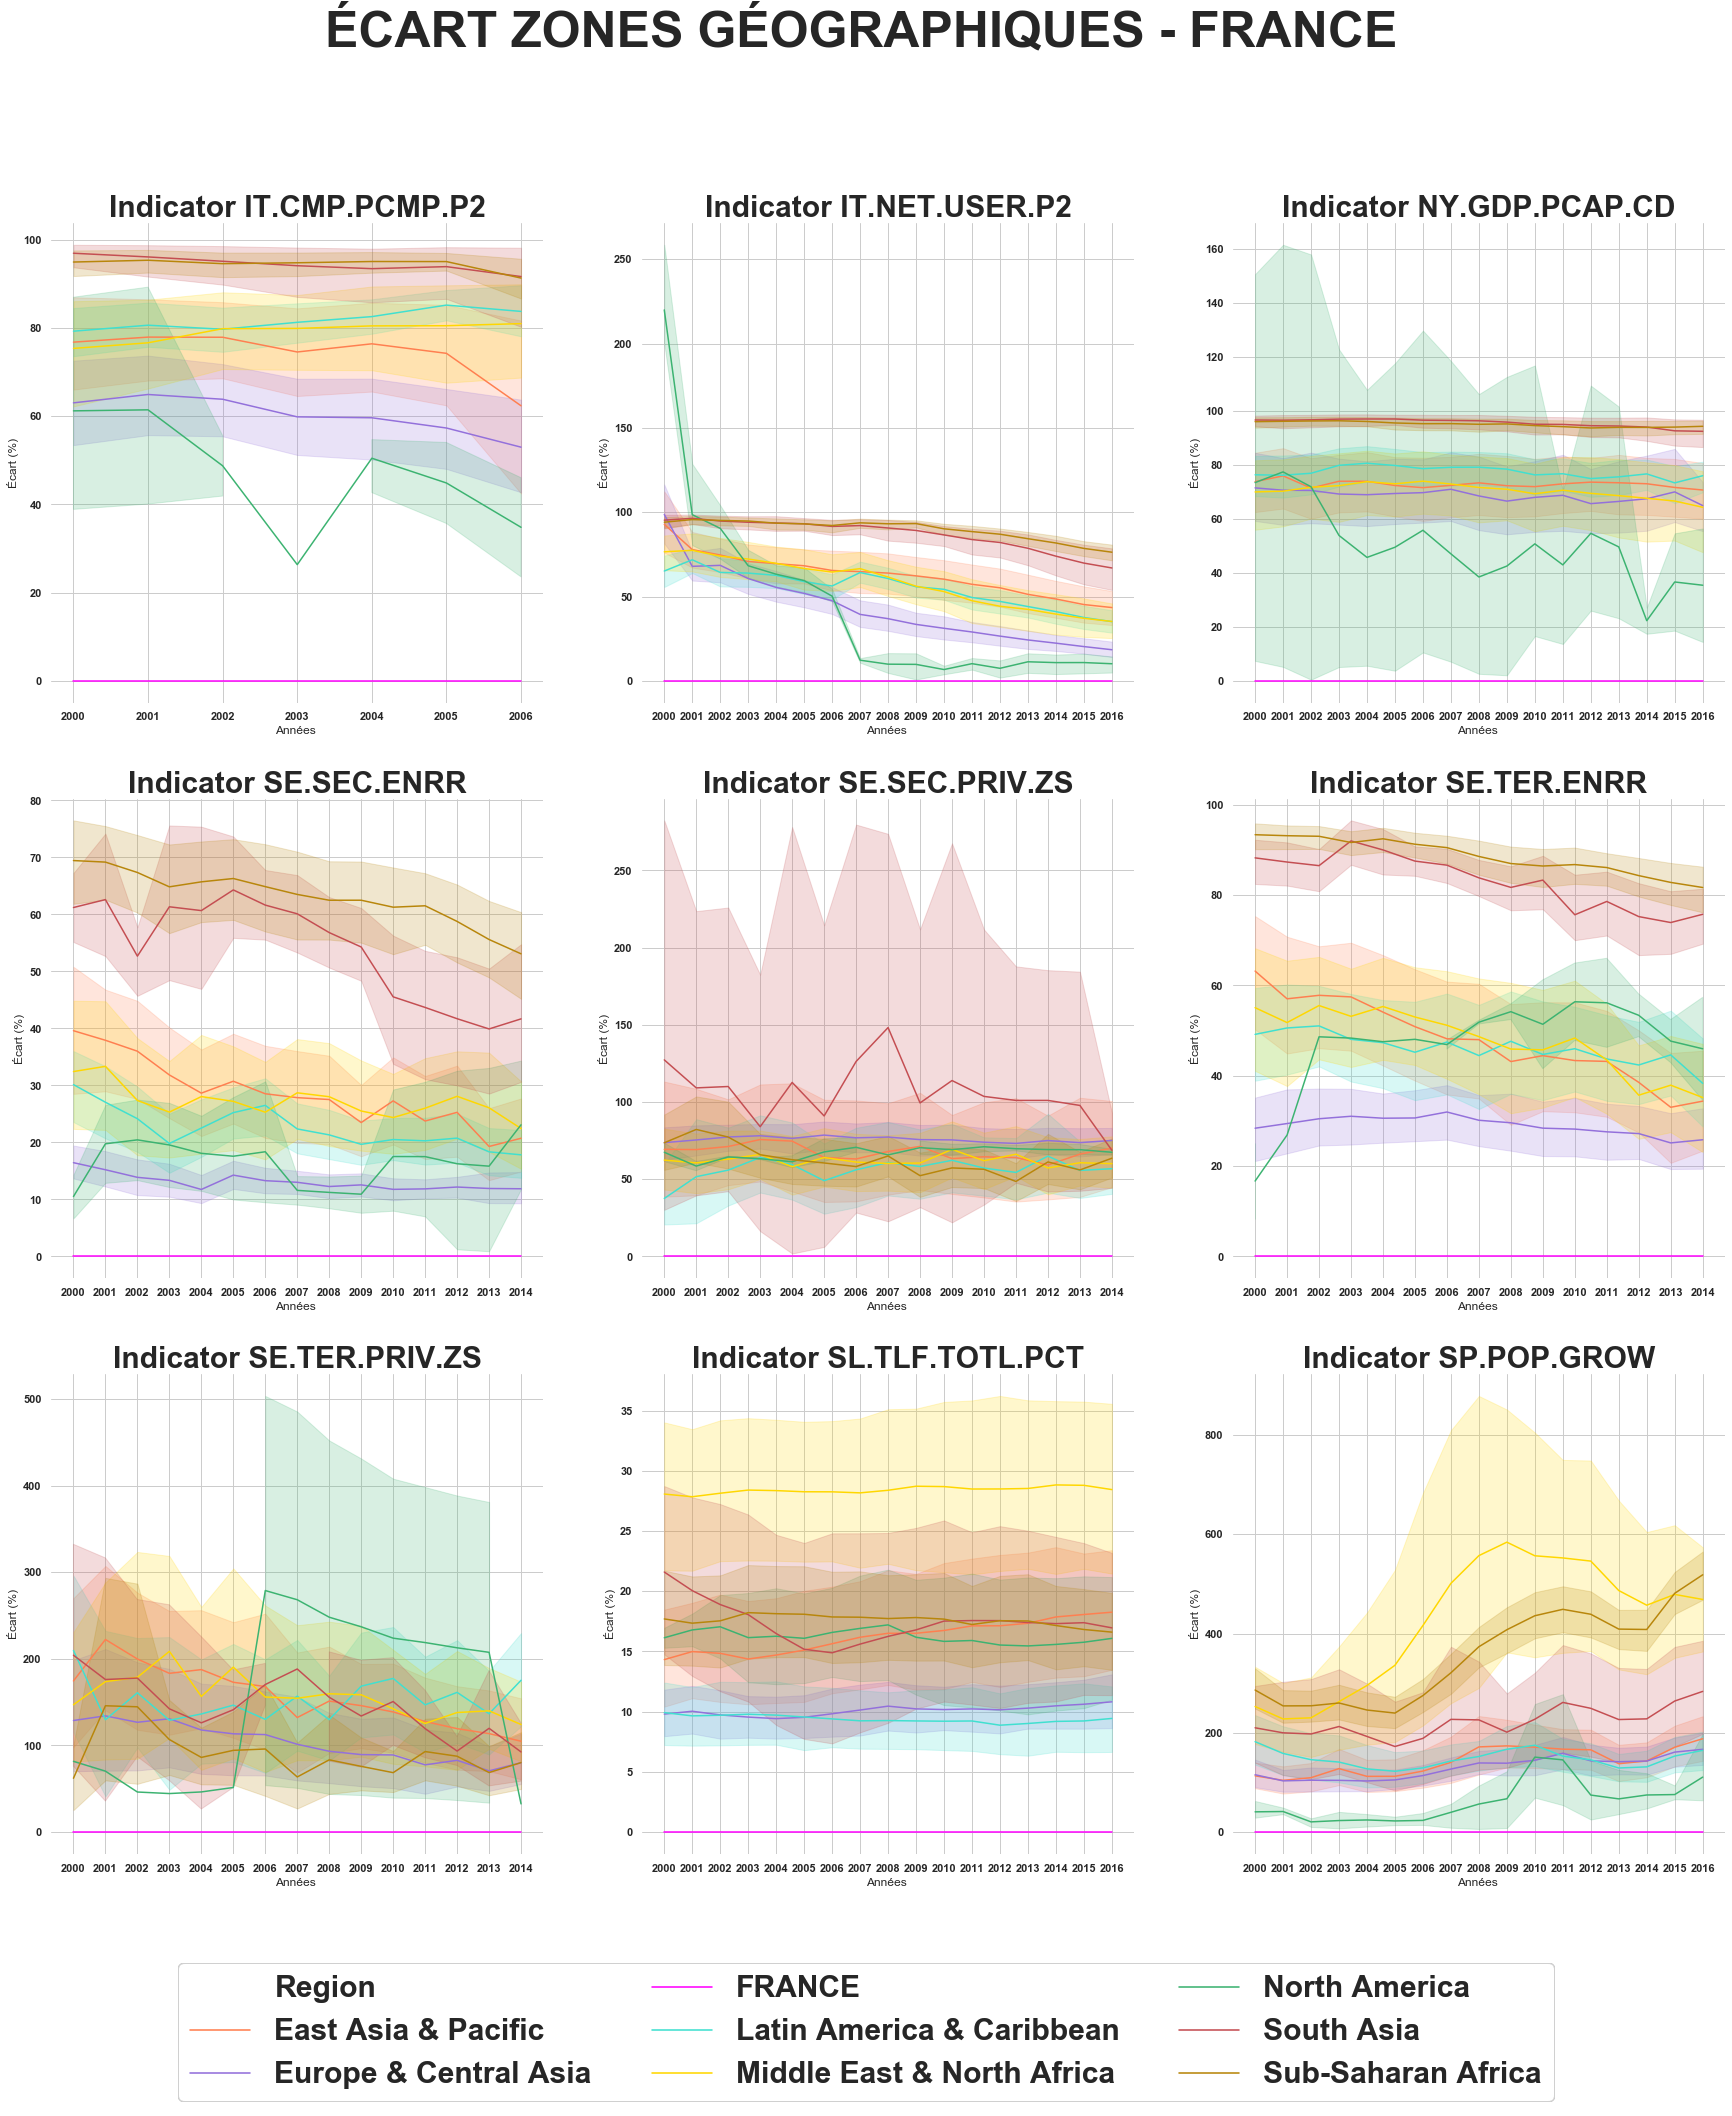

In [46]:
hf.plotTimeSeriesComparison(data_fip,'France', 30, 30)

Ce deuxième graphique présente la variation de la moyenne des valeurs pour chaque indicateur sur la zone géographique donnée.

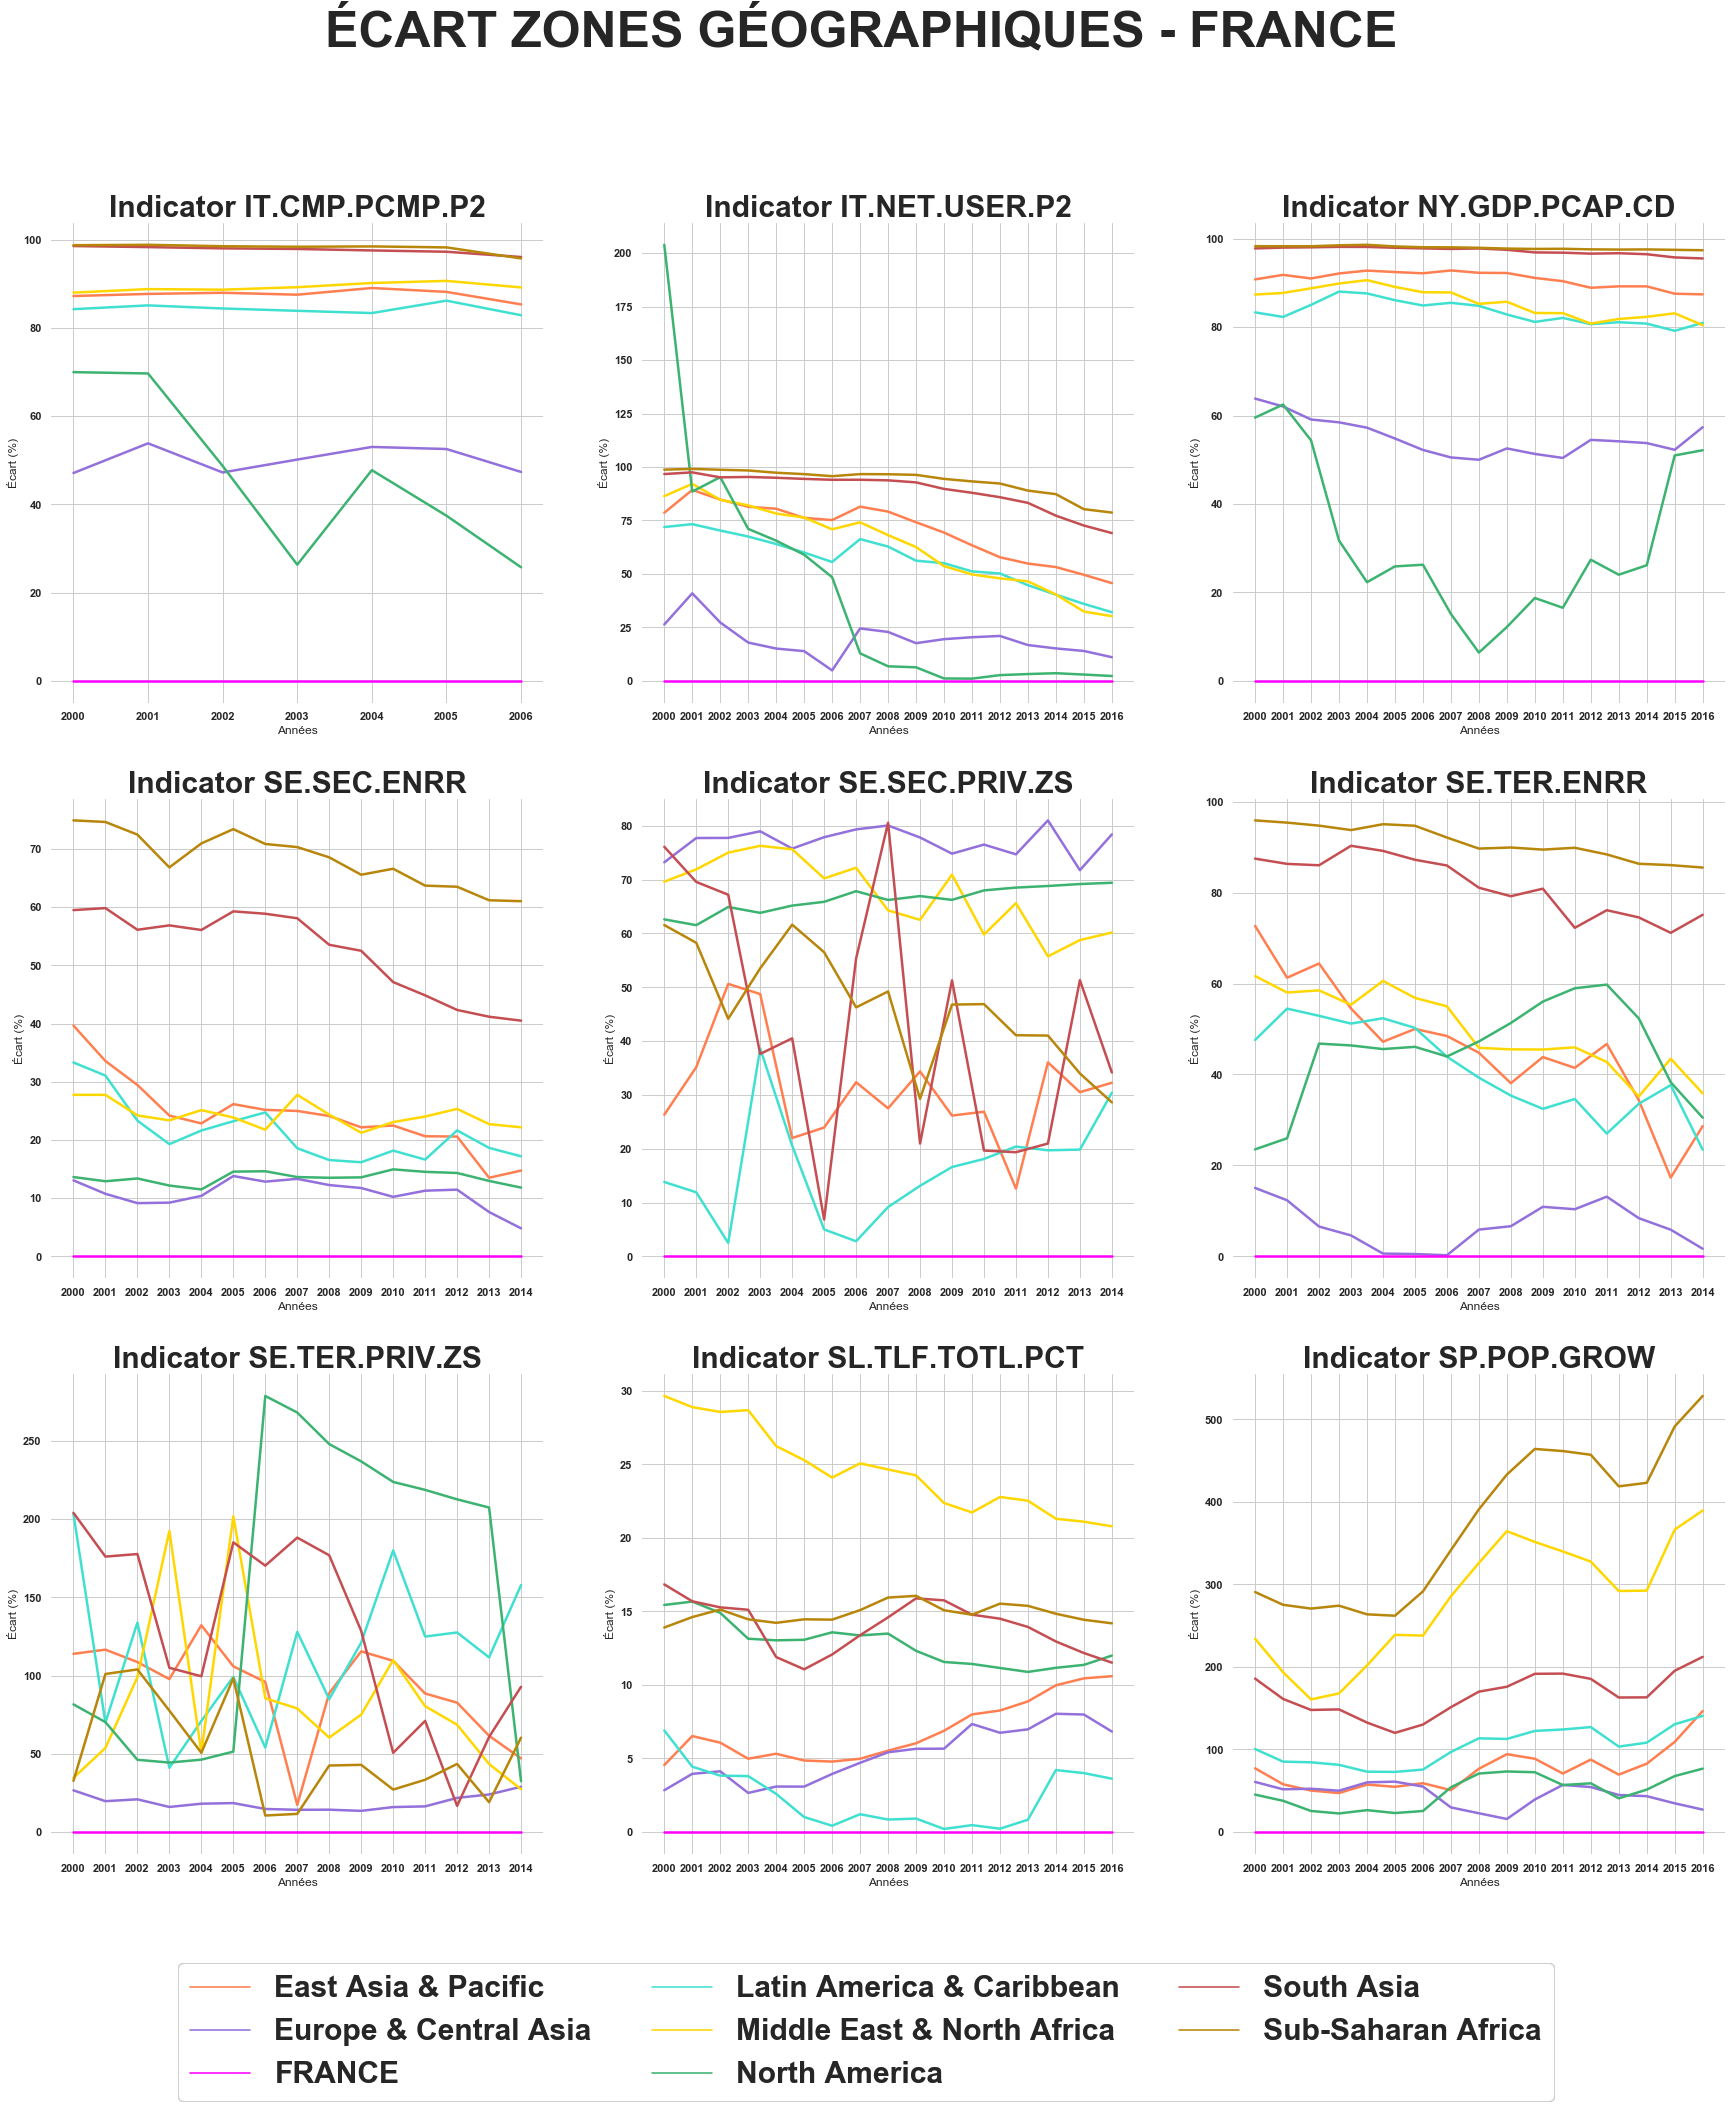

In [47]:
hf.plotLineplotComparisonCriteria(data_fip, 'Region', "FRANCE", 30, 30)

Nous pouvons afficher le classement des régions les plus proches via la médiane des écarts entre la valeur médiane pour une région et celle de la France:

In [48]:
region_stats = hf.getMedianOfTheAbsDifferenceFor(data_fip, 'Region', 'FRANCE')

region_stats

Region  Médianes Écarts Tous Indicateurs (%)
RANK                                                                  
1.0        Europe & Central Asia                             28.774174
2.0                North America                             32.417574
3.0    Latin America & Caribbean                             60.674513
4.0          East Asia & Pacific                             62.466242
5.0   Middle East & North Africa                             62.603752
6.0           Sub-Saharan Africa                             87.152982
7.0                   South Asia                             90.973901

#### 2.3.3 SÉLECTION DES ZONES GÉOGRAPHIQUES

In [49]:
# Conserver uniquement les régions du premier quartile
#-----------------------------------------------------

bins = 4  # Bin into quartiles.
ecarts_FR_selected_regions = region_stats[pd.qcut(region_stats['Médianes Écarts Tous Indicateurs (%)'], 
                                                     bins, labels=range(bins)).eq(0)]

selected_regions = ecarts_FR_selected_regions['Region'].tolist()

ecarts_FR_selected_regions

Region  Médianes Écarts Tous Indicateurs (%)
RANK                                                             
1.0   Europe & Central Asia                             28.774174
2.0           North America                             32.417574

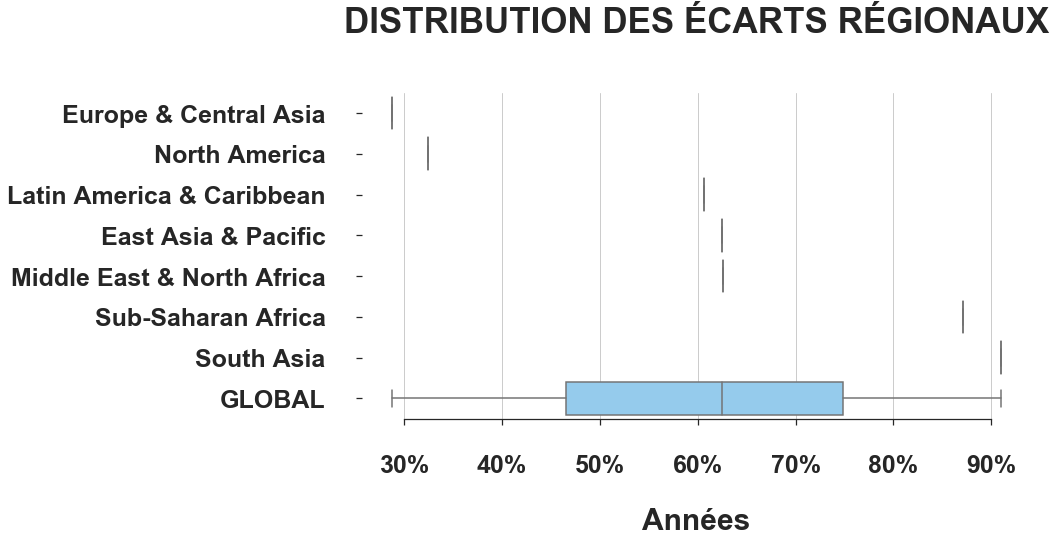

In [50]:
hf.plotBoxplot(region_stats, 'Region', 12, 6)

On va considérer uniquement les régions dont l'écart avec la valeur médiane se situe dans le premier quartile de la distribution.
> **Les régions les plus proches du profil de la France sont donc:**
- **l'Europe & l'Asie Centrale**
- **l'Amérique du Nord**

Le reste de l'analyse va donc se concentrer sur ces régions.

In [51]:
regions_of_interest = [
    'Europe & Central Asia',
    'North America', 
    'FRANCE' # Pour calculs comparatifs
]

___
### 2.4 Détermination des pays d'intérêt

Le jeu de données peut maintenant être restreint aux seules régions d'intérêt.

In [52]:
data_fip_countries = data_fip[data_fip['Region'].isin(regions_of_interest)\
                             &\
                             ~data_fip['Country Name'].isin(regions.values())
                             ]

Parmi tous ces pays, seuls ceux ayant plus de 80% des indicateurs nous intéressent.

In [53]:
x = int((len(final_inds_pct)*0.8))

countries_of_interest = [country for country, data_df in data_fip_countries.groupby('Country Name') \
                         if len(data_df)>x]


data_fip_countries_of_interest = data_fip_countries[data_fip_countries['Country Name']\
                                                    .isin(countries_of_interest)]

___
#### 2.4.1 GRANDEURS STATISTIQUES DES PAYS DES RÉGIONS D'INTÉRÊT

Comme pour les régions, nous pouvons obtenir les grandeurs statistiques pour l'ensemble des pays des régions d'intérêt, la France incluse.

In [54]:
stats_countries_of_interest = hf.getStatsFor(data_fip_countries_of_interest, "Country Name")

stats_countries_of_interest

Indicator Code                    IT.CMP.PCMP.P2  IT.NET.USER.P2  \
Country Name  grandeur stat                                        
Albania       median                    1.492446       23.860000   
              mean                      2.191607       29.149682   
              standard deviation        1.514903       26.083970   
Armenia       median                    2.680867        6.210000   
              mean                      3.963237       21.465141   
...                                          ...             ...   
United States mean                     70.281675       67.385319   
              standard deviation       10.363613        9.388976   
Uzbekistan    median                    2.558743        9.080115   
              mean                      2.466673       14.992001   
              standard deviation        0.694159       15.163418   

Indicator Code                    NY.GDP.PCAP.CD  SE.SEC.ENRR  SE.SEC.PRIV.ZS  \
Country Name  grandeur stat                                                     
Albania       median                 3934.895394    82.464893        6.614800   
              mean                   3288.017354    83.234796        6.646133   
              standard deviation     1216.935391     9.097995        1.181681   
Armenia       median                 3138.808703    91.058563        2.224055   
              mean                   2568.710877    91.540593        2.115173   
...                                          ...          ...             ...   
United States mean                  46988.555265    95.128294        8.690196   
              standard deviation     6602.794718     1.143239        0.521824   
Uzbekistan    median                 1082.286025    95.413498        0.036650   
              mean                   1145.605028    94.132302        0.029082   
              standard deviation      662.913435     3.274101        0.021902   

Indicator Code                    SE.TER.ENRR  SE.TER.PRIV.ZS  \
Country Name  grandeur stat                                     
Albania       median                31.365735       14.326970   
              mean                  35.442272       11.482800   
              standard deviation    17.875913        8.239419   
Armenia       median                43.612690       12.429290   
              mean                  42.096738       14.547613   
...                                       ...             ...   
United States mean                  84.165267       26.121035   
              standard deviation     7.958674        1.626017   
Uzbekistan    median                10.105720        1.929710   
              mean                  10.644446        1.800346   
              standard deviation     2.177824        1.102334   

Indicator Code                    SL.TLF.TOTL.PCT  SP.POP.GROW  
Country Name  grandeur stat                                     
Albania       median                    43.421932    -0.417931  
              mean                      43.527855    -0.457613  
              standard deviation         1.430846     0.242194  
Armenia       median                    45.102674    -0.550839  
              mean                      45.650867    -0.321302  
...                                           ...          ...  
United States mean                      51.076283     0.862893  
              standard deviation         0.658133     0.120085  
Uzbekistan    median                    44.397406     1.472100  
              mean                      43.975022     1.588384  
              standard deviation         2.568774     0.487143  

[144 rows x 9 columns]

___
#### 2.4.2 DÉTERMINATION DES MEILLEURS CANDIDATS

Le nombre de pays étant bien supérieur à celui des zones géographiues, il n'est pas opportun d'utiliser une analyse graphique des profils de chaque pays pour chaque indicateur.


Dans un premier temps, nous analyserons donc la similitude des marchés potentiels associés aux différents pays en étudiant:
- la valeur médiane du pays pour chaque indicateur: un pays sera considéré comme ayant un profil proche de celui de la France si cette dernière diffère en moyenne de moins de 33% de celle de la France sur l'ensemble des indicateurs.
- la taille de la population active du pays : nous conserverons les pays dont la population représente un marché de taille similaire ou supérieur à celui de la France.

##### 2.4.2.1 <u>**Focus profil global**</u>

In [55]:
countries_stats = hf.getMedianOfTheAbsDifferenceFor(data_fip_countries_of_interest, 'Country Name', 'France')

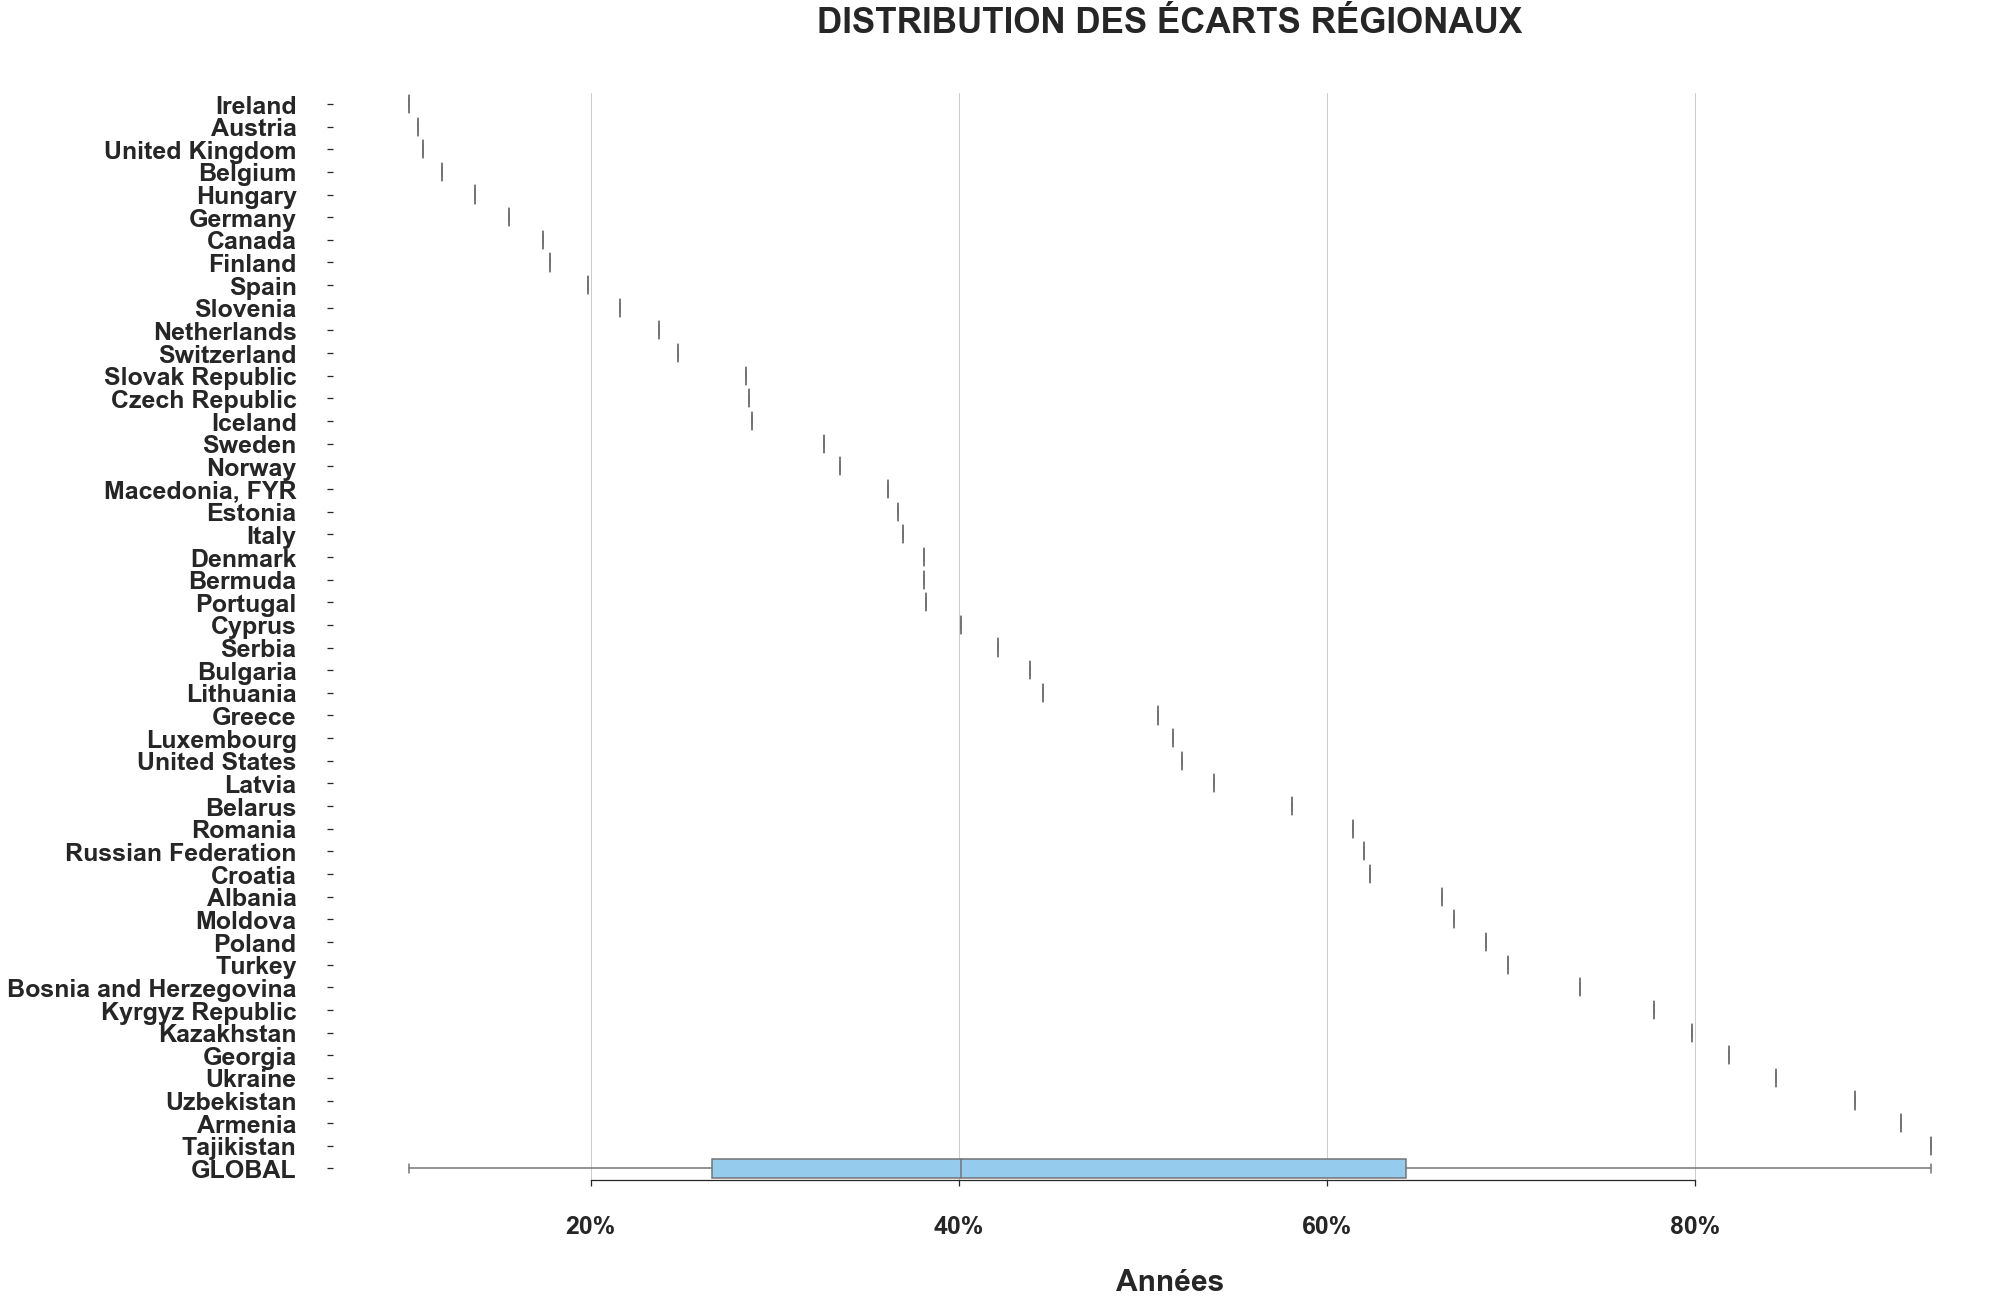

In [56]:
hf.plotBoxplot(countries_stats, 'Country Name', 30, 20)

In [57]:
# Conserver les pays du premier quintile
# --------------------------------------

bins = 5  # Bin into quartiles.
ecarts_FR_selected_countries = countries_stats[pd.qcut(countries_stats['Médianes Écarts Tous Indicateurs (%)'], 
                                                     bins, labels=range(bins)).eq(0)]

selected_countries = ecarts_FR_selected_countries['Country Name'].tolist()

Les pays des régions d'intérêt dont le profil se rapproche le plus de celui de la France sont présentés ci-dessous avec leurs statistiques:

In [58]:
ecarts_FR_selected_countries

Country Name  Médianes Écarts Tous Indicateurs (%)
RANK                                                      
1.0          Ireland                             10.109195
2.0          Austria                             10.632780
3.0   United Kingdom                             10.908319
4.0          Belgium                             11.887945
5.0          Hungary                             13.695529
6.0          Germany                             15.581789
7.0           Canada                             17.416045
8.0          Finland                             17.766655
9.0            Spain                             19.858626
10.0        Slovenia                             21.584049

In [59]:
stats_countries = selected_countries + ['France']

data_X = data_fip_countries_of_interest[data_fip_countries_of_interest['Country Name']\
                                        .isin(stats_countries)]

hf.getStatsFor(data_X, "Country Name")

Indicator Code                     IT.CMP.PCMP.P2  IT.NET.USER.P2  \
Country Name   grandeur stat                                        
Austria        median                   51.731853       72.870000   
               mean                     50.036888       65.150804   
               standard deviation        9.545937       17.709986   
Belgium        median                   29.429374       66.000000   
               mean                     29.487190       64.878216   
               standard deviation        6.219495       18.407306   
Canada         median                   52.181541       76.700000   
               mean                     63.038518       75.002310   
               standard deviation       21.221881       11.270344   
Finland        median                   45.180672       82.490000   
               mean                     45.084037       76.654376   
               standard deviation        3.812999       15.868760   
France         median                   41.303444       70.680000   
               mean                     44.224959       59.807078   
               standard deviation       13.140562       24.046950   
Germany        median                   47.739260       78.000000   
               mean                     48.376829       70.444952   
               standard deviation       11.556305       18.515204   
Hungary        median                   13.491464       61.000000   
               mean                     14.260671       50.228789   
               standard deviation        5.561120       24.296906   
Ireland        median                   45.478890       65.340000   
               mean                     46.117493       57.078669   
               standard deviation        8.073482       22.384922   
Slovenia       median                   33.968282       58.000000   
               mean                     34.594159       54.347213   
               standard deviation        6.024432       18.919159   
Spain          median                   23.949106       59.600000   
               mean                     26.265366       54.190566   
               standard deviation        7.929330       21.176395   
United Kingdom median                   43.755268       78.390000   
               mean                     53.034963       73.480179   
               standard deviation       18.927817       19.729868   

Indicator Code                     NY.GDP.PCAP.CD  SE.SEC.ENRR  \
Country Name   grandeur stat                                     
Austria        median                44676.345835    99.388783   
               mean                  41664.692098    99.342432   
               standard deviation     9613.080641     0.736483   
Belgium        median                41236.266589   108.428913   
               mean                  39037.679776   129.459890   
               standard deviation     8677.679273    26.712746   
Canada         median                42157.927991   102.297066   
               mean                  40057.668177   103.654748   
               standard deviation    10273.222528     3.465118   
Finland        median                43402.863264   111.792313   
               mean                  41477.852083   120.886916   
               standard deviation     9316.086711    15.076504   
France         median                36854.968280   111.178520   
               mean                  36302.694924   110.350309   
               standard deviation     7487.586686     1.716439   
Germany        median                41732.707253   102.508446   
               mean                  38126.850604   102.485036   
               standard deviation     8202.042231     1.080385   
Hungary        median                12814.949954    99.219707   
               mean                  11405.855193    99.914361   
               standard deviation     3280.110834     4.066384   
Ireland        median                52060.467861   112.889511   


##### 2.4.2.2 <u>**Focus taille population active**</u>

In [60]:
#-------------------------------------------------------------
# Restriction des données aux seuls pays sélectionnés et à
# l'indicateur en nombre de la taille de la population active
#-------------------------------------------------------------

# Ajout de la France aux pays sélectionnés pour poursuivre 
# l'analyse
selected_countries.append('France')

# indicateur étudié : la taille de la population active
indicator = ['SL.TLF.TOTL.IN']

# Restriction des données
data_selected_countries = data_final_inds_desc[
                                                    data_final_inds_desc['Country Name']\
                                                    .isin(selected_countries) \
                                                     & \
                                                    data_final_inds_desc['Indicator Code']\
                                                    .isin(indicator)
                                                ]

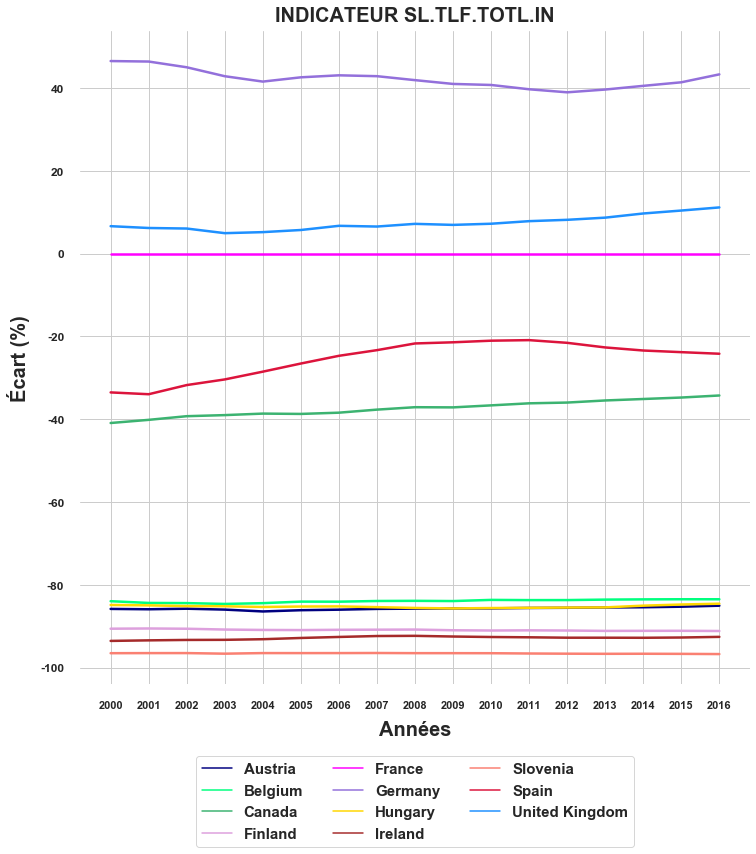

In [61]:
hf.plotLineplotComparisonCriteriaNoAbs(data_selected_countries, 'Country Name', "France", 12, 12)

In [62]:
hf.getMedianOfTheNoAbsDifferenceFor(data_selected_countries,'Country Name', 'France')

Country Name  Médianes Écarts Tous Indicateurs (%)
RANK                                                      
10.0         Germany                             41.572887
9.0   United Kingdom                              7.168535
8.0            Spain                            -22.126628
7.0           Canada                            -37.104625
6.0          Belgium                            -83.860435
5.0          Hungary                            -85.481966
4.0          Austria                            -85.745491
3.0          Finland                            -90.906925
2.0          Ireland                            -92.612128
1.0         Slovenia                            -96.558599

4 pays se détachent nettement du reste par la taille de la population, proche voire supérieure à celle de la France: 
>- L'Allemagne, population globalement supérieure à 41% de celle de la France sur la période
- Le Royaume-Uni, population globalement supérieure de 7% à celle de la France sur la période
- L'Espagne, population globalement inférieure de 22% à celle de la France sur la période
- Le Canada, population globalement inférieure de 37% à celle de la France sur la période

Les autres pays ont des tailles de population active nettement inférieures à celle de la France (+ de 80% ).

Le reste de l'analyse va donc se focaliser sur ces 4 pays.

In [63]:
selected_countries = ['Germany', 'United Kingdom', 'Spain', 'Canada']

##### 2.4.2.3 <u>**Focus pouvoir d'achat**</u>

In [64]:
#-------------------------------------------------------------
# Restriction des données aux seuls pays sélectionnés et à
# l'indicateur en nombre de la taille de la population active
#-------------------------------------------------------------

# Ajout de la France aux pays sélectionnés pour poursuivre 
# l'analyse
selected_countries.append('France')

# indicateur étudié : la taille de la population active
indicator = ['NY.GDP.PCAP.CD']

# Restriction des données
data_selected_countries = data_final_inds_desc[
                                                    data_final_inds_desc['Country Name']\
                                                    .isin(selected_countries) \
                                                     & \
                                                    data_final_inds_desc['Indicator Code']\
                                                    .isin(indicator)
                                                ]

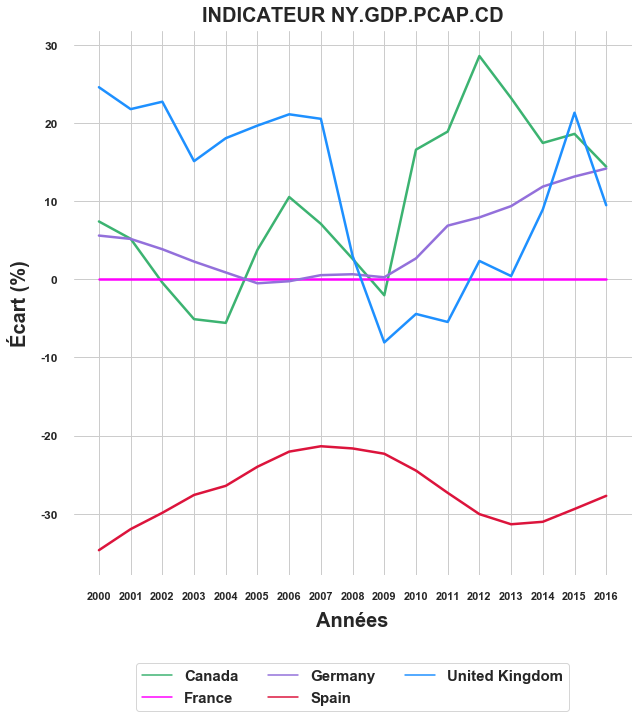

In [65]:
hf.plotLineplotComparisonCriteriaNoAbs(data_selected_countries, 'Country Name', "France", 10, 10)

In [66]:
hf.getMedianOfTheNoAbsDifferenceFor(data_selected_countries,'Country Name', 'France')

Country Name  Médianes Écarts Tous Indicateurs (%)
RANK                                                      
4.0           Canada                             14.388724
3.0          Germany                             13.234956
2.0   United Kingdom                             12.365717
1.0            Spain                            -22.717042

Un trio de tête se détache, Canada en tête.  
L'Espagne est le seul pays à avoir un pouvoir d'achat inférieur à celui de la France, de plus de 20%.

Nous conserverons donc maintenant uniquement ce trio de tête.

In [67]:
finalist_countries = ['Canada', 'Germany', 'United Kingdom']

##### 2.4.2.4 <u>**Focus taux de croissance**</u>

In [68]:
#-------------------------------------------------------------
# Restriction des données aux seuls pays sélectionnés et à
# l'indicateur en nombre de la taille de la population active
#-------------------------------------------------------------

# Ajout de la France aux pays sélectionnés pour poursuivre 
# l'analyse
finalist_countries.append('France')

# indicateur étudié : la taille de la population active
indicator = ['SP.POP.GROW']

# Restriction des données
data_finalist_countries = data_final_inds_desc[
                                                    data_final_inds_desc['Country Name']\
                                                    .isin(finalist_countries) \
                                                     & \
                                                    data_final_inds_desc['Indicator Code']\
                                                    .isin(indicator)
                                                ]

In [69]:
#-------------------------------------------------------------
# Remplacement d'un outlier en 2011 en Allemagne par la moyenne 
# des 2 valeurs précédentes
#-------------------------------------------------------------
data_g = data_finalist_countries.copy()
data_g = data_g[data_g['Country Name']=='Germany']
data_g.loc[:,'2011'] = data_g.loc[:, '2010'].sub(data_g.loc[:, '2012'])/2

data_finalist_countries = data_finalist_countries[data_finalist_countries['Country Name']!='Germany']\
                          .append(data_g)

**Écart taux de croissance avec celui de la France**

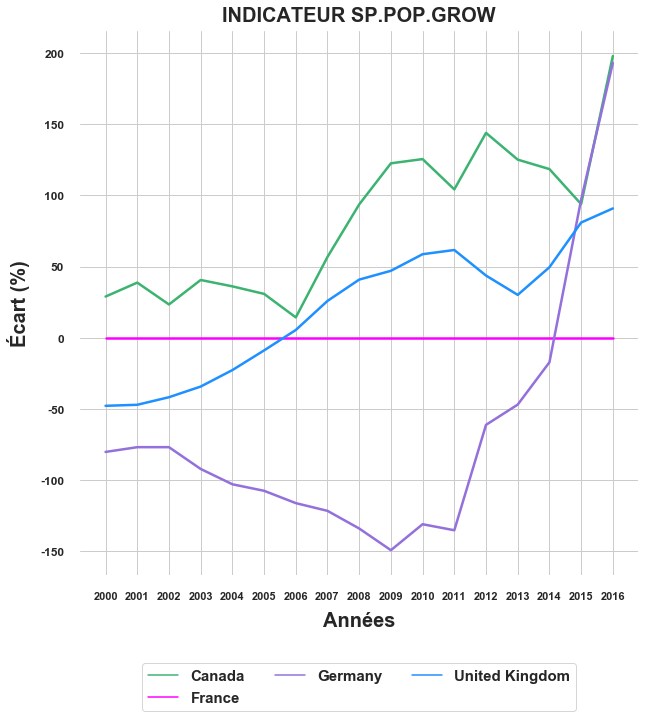

In [70]:
hf.plotLineplotComparisonCriteriaNoAbs(data_finalist_countries, 'Country Name', "France", 10, 10)

In [71]:
hf.getMedianOfTheNoAbsDifferenceFor(data_finalist_countries,'Country Name', 'France')

Country Name  Médianes Écarts Tous Indicateurs (%)
RANK                                                      
3.0           Canada                             79.300546
2.0   United Kingdom                             31.527048
1.0          Germany                            -90.093483

**Taux de croissance des populations avec régression linéaire**

In [72]:
data_finalist_countries['Taux de croissance (moyenne)'] = data_finalist_countries.mean(axis=1)

data_finalist_countries.loc[:,['Country Name', 'Taux de croissance (moyenne)']]\
                       .sort_values(['Taux de croissance (moyenne)'], ascending=False)\
                       .set_index('Country Name').drop('France')

Taux de croissance (moyenne)
Country Name                                
Canada                              1.022019
United Kingdom                      0.658837
Germany                             0.139531

In [73]:
data_finalist_countries = data_final_inds_desc[data_final_inds_desc['Country Name'].isin(finalist_countries)]

In [74]:
indicator = ['SP.POP.GROW']

data_indicator = data_finalist_countries[data_finalist_countries['Indicator Code'].isin(indicator)]

In [75]:
data = data_indicator.drop(columns='Indicator Code').set_index('Country Name').T.reset_index().loc[6:,:]\
                     .rename(columns={'index':'years'})

data['years']=data['years'].astype(float)

In [76]:
data_regplot = pd.DataFrame()

for country in finalist_countries:
    data_tmp = pd.DataFrame()
    data_tmp = pd.concat([data_tmp,data.set_index('years')[country]]).rename(columns={0:'Value'})
    data_tmp['Country']= country
    
    data_regplot = pd.concat([data_regplot, data_tmp])

data_regplot = data_regplot.reset_index().rename(columns={'index':'Years'})

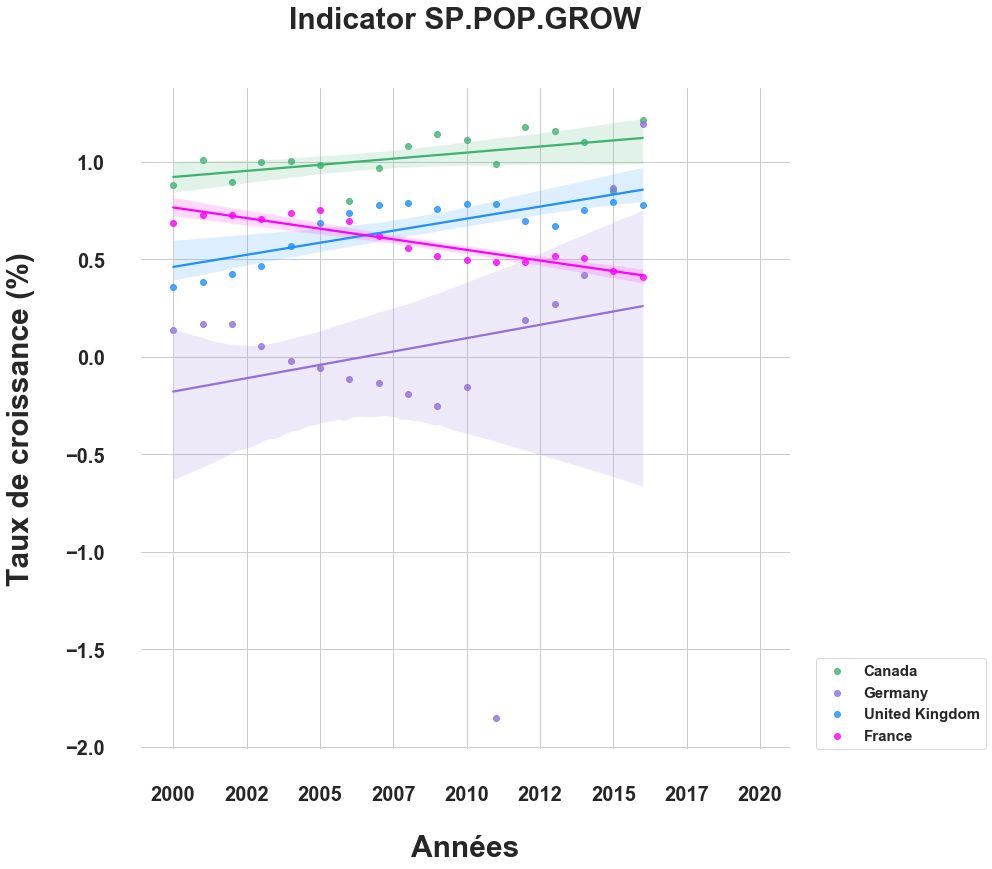

In [77]:
hf.plotLmplot(data_regplot, 10, 10)

>Le Canada possède un taux de croissance bien supérieur à tous les autres sur la période.

##### 2.4.2.5 <u>Focus Projections</u>

In [78]:
prj_data_final = prj_data[
                                 prj_data['Country Name'].isin(finalist_countries)
                                    &
                                 prj_data['Indicator Code'].isin(final_inds_prj)
                        ]

prj_data_final = prj_data_final.dropna(axis=0, how='all')

In [79]:
projected_ind_data = prj_data_final.copy()
projected_ind_data.set_index(['Country Name', 'Country Code', 'Indicator Name', 'Indicator Code'])
projected_ind_data.loc[:,'2020':'2100'] = projected_ind_data.loc[:,:]*100

prj_data_final = projected_ind_data

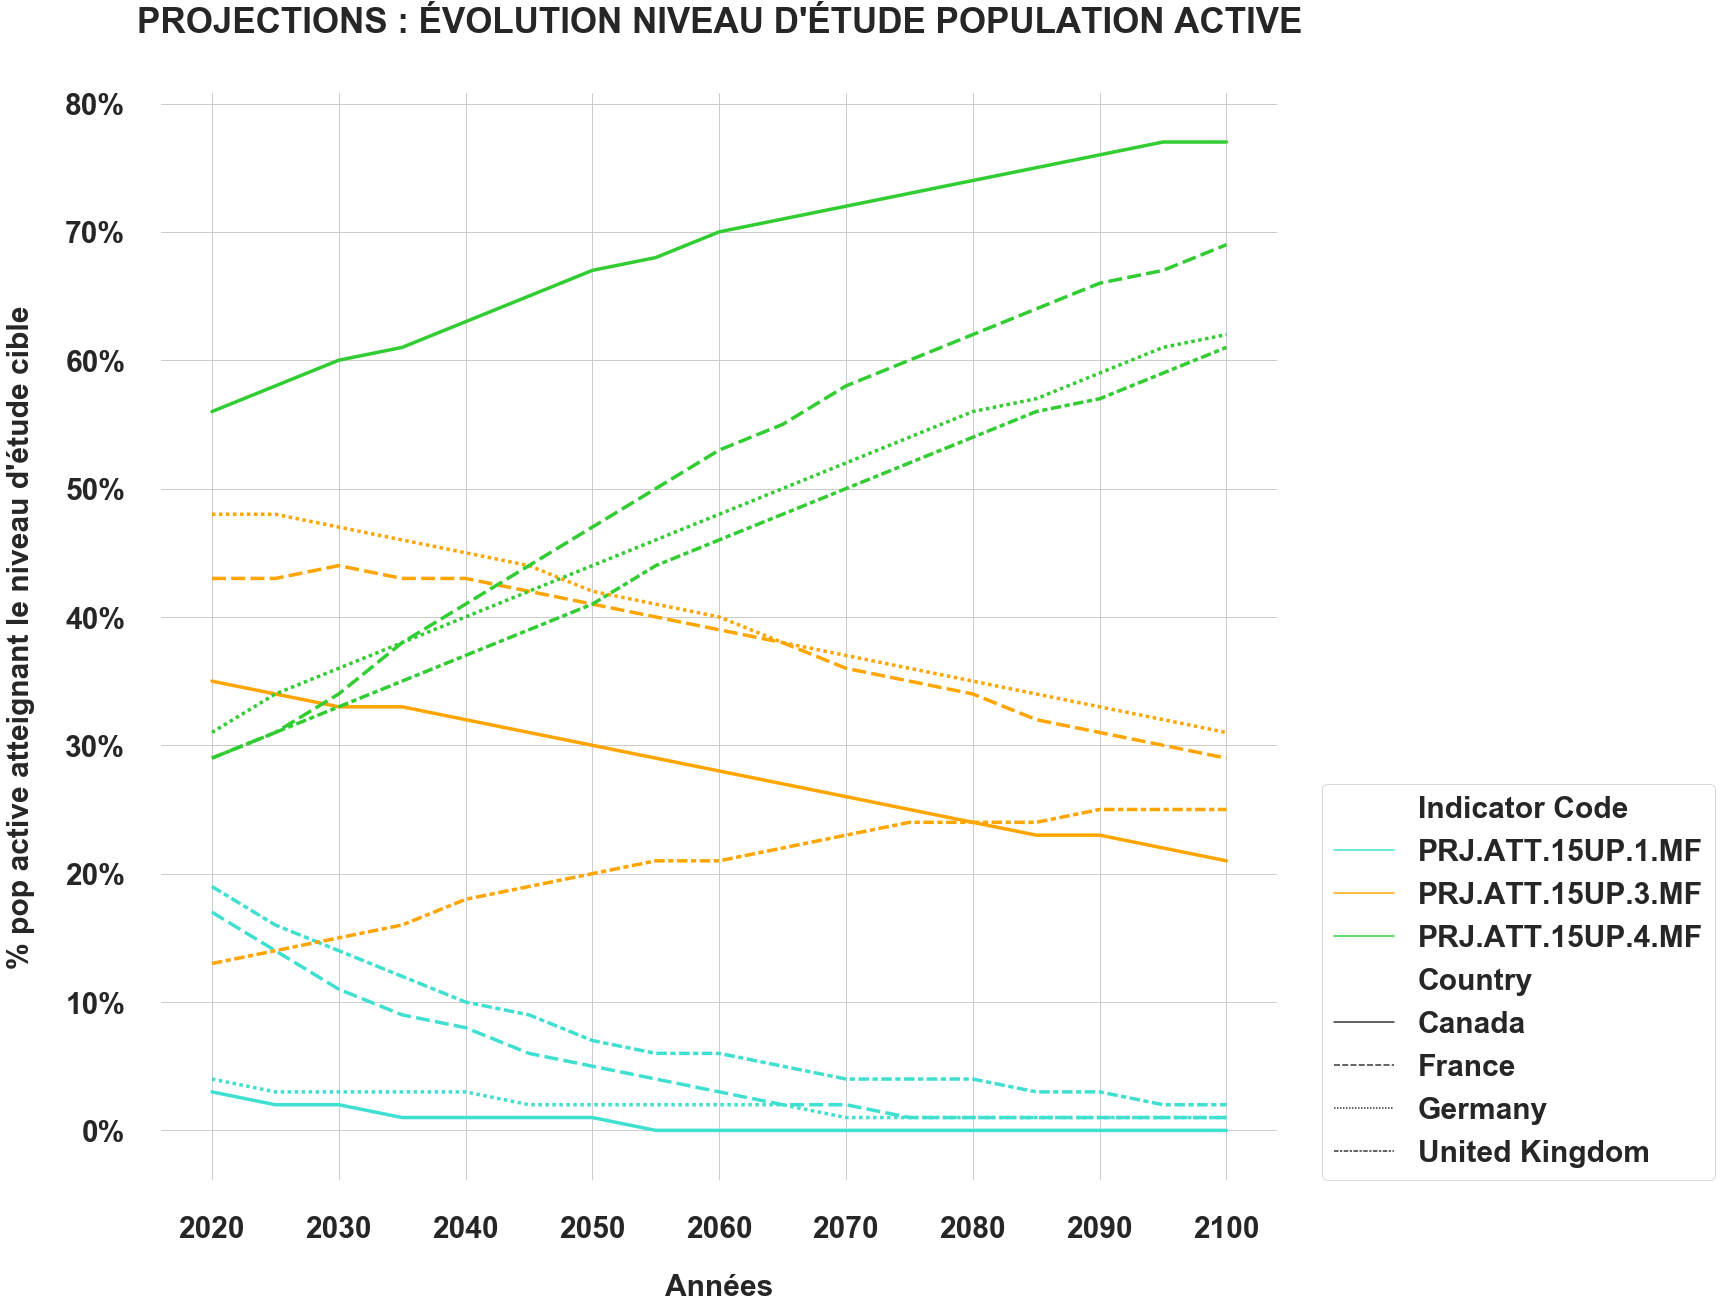

In [80]:
hf.plotLineplotIndicators(prj_data_final, final_inds_prj, 20, 20)

In [81]:
replace_att_with=['PRJ.ATT.15UP.1234.MF'] * len(final_inds_prj)

prj_data_final['Indicator Code'] = prj_data_final['Indicator Code'].replace(final_inds_prj, replace_att_with)

prj_data_final = prj_data_final.groupby(['Country Name', 'Indicator Code']).agg('sum').reset_index()

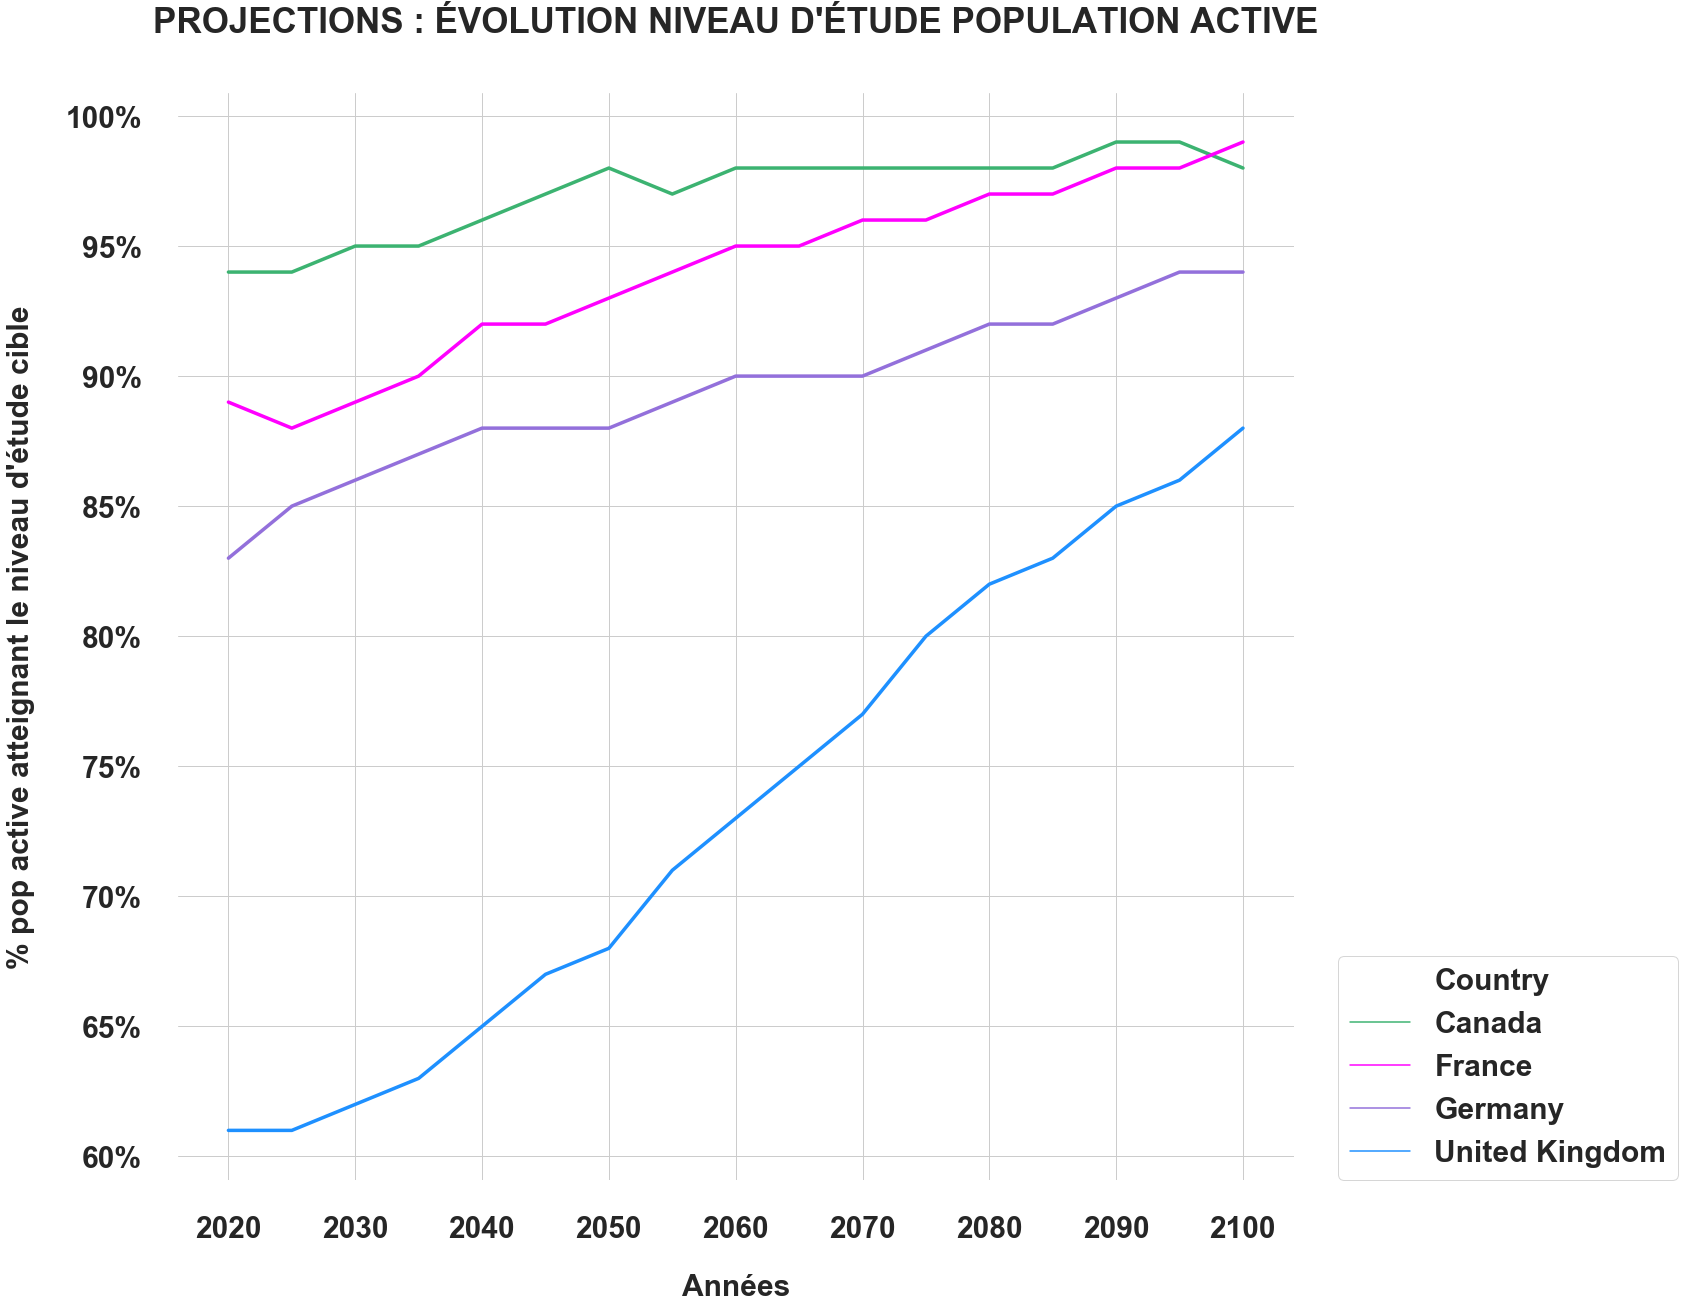

In [82]:
hf.plotLineplotIndicators(prj_data_final, ['PRJ.ATT.15UP.1234.MF'], 20, 20)

In [83]:
data_interest = prj_data_final[prj_data_final['Indicator Code']=='PRJ.ATT.15UP.1234.MF'].copy()

data_interest['pop cible (% de la pop active) - moyenne'] = data_interest.loc[:,'2020':'2100'].mean(axis=1)

data_interest.loc[:,['Country Name', 'pop cible (% de la pop active) - moyenne']]\
                       .sort_values(['pop cible (% de la pop active) - moyenne'], ascending=False)\
                       .set_index('Country Name').drop('France')

pop cible (% de la pop active) - moyenne
Country Name                                            
Canada                                         97.058824
Germany                                        89.411765
United Kingdom                                 73.352941

> - On observe pour l’ensemble des pays qu’un pourcentage de plus en plus important de la population poursuivra ses études au niveau université => une probabilité plus importante de devenir client de la société.
- Le Canada est largement en tête sur ces observations, tandis que le Royaume-Uni et l’Allemagne sont au coude à coude.


___
### 3. CONCLUSIONS

#### Validation du jeu de données
Le jeu de données montre un grand nombre d'indicateurs, mais peu sont remplis sur l'ensemble des pays.

Toutefois, un nombre suffisant d'indicateurs bien renseignés et répartis sur plusieurs catégories permettent de peindre un profil suffisamment complet des différents pays et régions du monde pour pouvoir répondre aux problématiques posées.

#### Analyse Exploratoire
##### Similarité de profil
Une première analyse a permis d'identifier deux régions au profil similaire à la France :
>- l'Europe & l'Asie Centrale
- l'Amérique du Nord.

Au sein de ces régions, 10 pays au profil particulièrement proche de celui de la France ont pu être identifiés :
>- Le Royaume-Uni
- L'Espagne
- Le Canada
- L'Allemagne
- La Belgique
- La Hongrie
- L'Autriche 
- La Finlande
- L'Irelande
- La Slovénie

##### Similarité de taille de marché potentiel
Une deuxième partie de l'analyse s'est ensuite concentrée sur les pays précédemment identifiés afin de conserver uniquement les pays dont la taille du marché potentiel associé soit semblable, voire supérieure, à celui de la France. 

Quatre pays se sont nettement détachés des autres:
>- L'Allemagne
- Le Royaume-Uni
- Le Canada
- L'Espagne

Afin de pouvoir classer ces pays et trouver les plus intéressants, un focus a été réalisé sur deux aspects:
- Le pouvoir d'achat
- Le taux de croissance
- L'évolution potentielle

**Focus pouvoir d'achat**<br>
Le trio Canada, Allemagne, Royaume-Uni s'est nettement distingué de l'Espagne, seul pays à présenter un pouvoir d'achat inférieur à celui de la France, et d'une proportion importante de plus de 20%.

**Focus taux de croissance**<br>
Le Canada sort largement en tête sur cette comparaison, avec un taux de croissance supérieur à celui de la France de plus de 79%, suivi loin derrière par le Royaume-Uni, 31% supérieur à celui de la France.

**Focus évolution**<br>
Avec la proportion de personnes poursuivant leurs études à l'université la plus élevée du groupe, le Canada reste en tête des projections, cette proportion étant donnée comme continuant à s'accroître dans les années futures.

#### Recommandations
Le Canada étant le pays qui ressort en tête de l'analyse, il sera ainsi possible d'établir une stratégie basée sur la langue:

- Un tiers du Canada étant francophone, il est possible de cibler ce marché à moindre coup, avec presqu'exclusivement des dépenses marketing.


- Une fois la société établie sur le marché Canadien francophone, les contenus peuvent alors être traduits en anglais pour conquérir l'ensemble du marché canadien. 


- Ce test sur une population anglophone pourra également servir à faciliter une expansion future vers le reste de l'Amérique du Nord, voire le Royaume-Uni, pour lequel l'analyse a mis en évidence un profil et une taille de marché prometteurs, en particulier si l'on considère la tendance haussière de leur taux de croissance.


- Enfin, suivant le budget, il serait éventuellement possible de cibler simultanément la Belgique, dont le profil prometteur lui avait permis de se classer parmi les pays d'intérêr. En effet, les coûts de traduction qui auraient été impliqués dans une expansion vers un pays non francophone pouvant potentiellement être réaffectés vers une campagne marketing pour faire connaître la plateforme dans ce pays.

- Un mot sur l'Allemagne : Bien que ce pays soit ressorti parmis le trio de tête, nous ne recommandons pas une expansion vers ce pays. En effet, l'allemand est une langue peu parlée à travers le monde, mis à part en Allemagne. Les coûts de traduction devraient donc être amortis sur ce seul pays. 

#### Discussions

Pour des raisons de simplicité, l'analyse s'est basée sur un accès égal à l'éducation entre hommes et femmes.

Toutefois, ce postulat est malheureusement faux pour un certain nombre de pays dans le monde. 

Afin d'obtenir une analyse plus fine, il serait possible d'exploiter les indicateurs de population homme /femme en les pondérant grâce aux indicateurs de parité également présents dans la base. On obtiendrait alors pour ces pays une image plus proche de la réalité de l'ampleur réelle de la base client potentielle représentée par ces pays.

Néanmoins, le profil de référence étant celui de la France, où l'égalité des sexes est une valeur fondamentale, il est douteux que les pays concernés par ces inégalités seraient apparus comme candidats pertinents d'expansion dans les résultats de l'analyse. 

La portée de cette analyse affinée serait donc a priori peu significative quant aux résultats finaux de l'analyse.

___
### 4. ANNEXES

In [84]:
##########################################
#                                        #
# Fonctions de calcul et de descriptions #
#                                        #
##########################################

def getMissingValuesPercentPer(data, column):
    ''' 
        Calculates the mean percentage of missing values
        in a given pandas dataframe per unique value 
        of a given column
        
        Parameters
        ----------------
        data   : pandas dataframe
                 The dataframe to be analyzed
                 
        column : str
                 The column in data to be analyzed
        
        Returns
        ---------------
        A pandas dataframe containing:
            - a column "column"
            - a column "Percent Missing" containing the percentage of 
              missing value for each value of column     
    '''
    
    percent_missing = data.isnull().sum(axis=1) * 100 / len(data.columns)
    
    return pd.DataFrame({column: data[column], 'Percent Missing': percent_missing})\
                        .groupby([column])\
                        .agg('mean')


#------------------------------------------

def descriptionJeuDeDonnees(sourceFiles):
    ''' 
        Outputs a presentation pandas dataframe for the dataset.
        
        Parameters
        ----------------
        A dictionary with:
        - keys : the names of the files
        - values : a list containing two values : 
            - the dataframe for the data
            - a brief description of the file
        
        Returns
        ---------------
        A pandas dataframe containing:
            - a column "Nom du fichier" : the name of the file
            - a column "Nb de lignes"   : the number of rows per file 
            - a column "Nb de colonnes" : the number of columns per file
            - a column "Description"    : a brief description of the file     
    '''

    print("Les données se décomposent en {} fichiers: \n".format(len(sourceFiles)))

    filenames = []
    files_nb_lines = []
    files_nb_columns = []
    files_descriptions = []

    for filename, file_data in sourceFiles.items():
        filenames.append(filename)
        files_nb_lines.append(len(file_data[0]))
        files_nb_columns.append(len(file_data[0].columns))
        files_descriptions.append(file_data[1])

        
    # Create a dataframe for presentation purposes
    presentation_df = pd.DataFrame({'Nom du fichier':filenames, 
                                    'Nb de lignes':files_nb_lines, 
                                    'Nb de colonnes':files_nb_columns, 
                                    'Description': files_descriptions})

    presentation_df.index += 1

    
    return presentation_df

#------------------------------------------

def addCompositeRatioIndicators(list_names_nums_denoms, columns_with_update, 
                                groupbyCriteria, data):
    ''' 
        Adds ratio indicators in % to a pandas dataframe
        
        Parameters
        ----------------
        list_names_nums_denoms : {(new indicator nameA, numeratorA, denominatorA), 
                                  (new indicator nameB, numeratorB, denominatorB)}
                                 a dictionary of tuples containing the name, numerator 
                                 and denominator for each new ratio indicator
                                 
        columns_with_update.   : [{column name x : information to add for A,
                                   column name y : information to add for A},
                                  {column name x : information to add for B,
                                   column name z : information to add for B}]
                                 list of dictionaries containing column name and the information 
                                 that needs to be added regarding the new indicators
                                 
        groupbyCriteria        : str
                                 the grouping criteria
                                  
        data                   : pandas dataframe 
                                 used to calculate and add the new ratio indicator

        
        Returns
        ---------------
        The pandas dataframe given in parameter with an added row for each new indicator   
    '''
    
    # Grouping data by criteria
    data_per_criteria = {k: v for k, v in data.groupby(groupbyCriteria)}
    
    data_info_per_criteria = {}

    for criteria, criteria_df in data_per_criteria.items():
        data_per_criteria[criteria] = criteria_df.iloc[:,3:23].set_index('Indicator Code')
        data_info_per_criteria[criteria] = pd.concat([criteria_df.iloc[:,0:4],
                                                      criteria_df.iloc[:,23:]], axis=1)\
                                                    .set_index(['Indicator Code'])
        
    # Adding infos for the new indicators
    for criteria, criteria_info_df in data_info_per_criteria.items(): 
        
        new_info_rows = []
        
        for i, (name, num, denom) in enumerate(list_names_nums_denoms):
            
            new_info_row = criteria_info_df.xs('SE.SEC.ENRL').copy()
            new_info_row.name = name
            
            for col_name, val in columns_with_update[i].items():
                new_info_row[col_name] = val
                
            new_info_rows.append(new_info_row)
            
        data_info_per_criteria[criteria] = criteria_info_df.append(new_info_rows)
        
    # Calculating the values for the new indicators
    for criteria, criteria_df in data_per_criteria.items():   
        
        new_rows = []
            
        for name, num, denom in list_names_nums_denoms:
            new_row = (criteria_df.loc[num] / criteria_df.loc[denom]) * 100
            new_row.name = name
            
            new_rows.append(new_row)
            
        data_per_criteria[criteria] = criteria_df.append(new_rows)
        
    # Grouping the data back into a single dataframe
    data = pd.DataFrame()

    for criteria, criteria_df in data_per_criteria.items():
        info_df = data_info_per_criteria[criteria]\
                  .reset_index()\
                  .rename(columns={'index':'Indicator Code'})

        criteria_df = criteria_df.reset_index(drop=True)

        criteria_data = pd.concat([info_df, criteria_df], axis=1)

        data = pd.concat([data, criteria_data])

    return data

#------------------------------------------

def getStatsFor(data, criterion):
    ''' 
        Calculate the median, the mean and the standard deviation for each mean
        value of the critierion column.
        
        Parameters
        ----------------
        data      : pandas dataframe
                    The data for each value of the criterion column.
        
        criterion : str
                    The column name to calculate the statistics for.
                                  
        
        Returns
        ---------------
        data_per_criterion : pandas dataframe
                             For presentation of the calculated statistics
    '''
    
    data_per_criterion = {}
    data_criterion_totale = pd.DataFrame()
    
    # Group data by the given criterion
    for criterion_idx, criterion_df in data.groupby(criterion):         
        criterion_df = criterion_df.drop(columns=['Country Name', 'Country Code', 'Indicator Name', 
                                            'Region', 'Topic', 'Indicator Description', 'Long definition'])
        
        # Calculate the mean on a given indicator for the region, all countries included, per year
        tmp_data_df = criterion_df.groupby(['Indicator Code']).agg('mean').T
        
        # Calculate the median, mean, std for a given indicator for the region, on all years
        median = tmp_data_df.median()
        mean = tmp_data_df.mean()
        std = tmp_data_df.std()

        # Create a dataframe to hold the data for a given criterion
        # and store it inside a dictionary with the criterion as key
        data_per_criterion[criterion_idx] = pd.concat([median, mean, std], axis=1,
                                              keys=['median', 'mean', 'standard deviation'])

        data_per_criterion[criterion_idx].columns = pd.MultiIndex.from_product([[criterion_idx], 
                                                                      ['median', 'mean', 'standard deviation']],
                                                                     names=[criterion, 'grandeur stat'])
        
    # Create a final presentation dataframe containing all the stats
    for criterion_idx, criterion_df in data_per_criterion.items():
        data_criterion_totale = pd.concat([data_criterion_totale, criterion_df.T])
            
    return data_criterion_totale

#------------------------------------------

def getMedianOfTheAbsDifferenceFor(data, criterion, ref_criterion):
    ''' 
        Ranks the given values of a criterion in terms of least 
        absolute mean difference in median values compared to that 
        of a reference criterion.
        
        Parameters
        ----------------
        data          : pandas dataframe
                        The data for each value of the criterion column and
                        the reference criterion.
        
        criterion     : str
                        The column name to calculate the statistics for.
        
        ref_criterion : str
                        The value of criterion to serve as reference.
                                  
        
        Returns
        ---------------
        ranked_df : pandas dataframe
                    For presentation of the ranked values
    '''
    
    # Calculate the mean, median, standard deviation for each value 
    # of the criterion
    criterion_stats = getStatsFor(data, criterion)
    
    # Keep only the median
    criterion_stats.drop(index=['mean','standard deviation'], level=1, inplace=True)

    # Isolate median value for ref_criterion
    row_ref_criterion = criterion_stats.loc[ref_criterion,:]

    # Calculate for each value of the criterion the difference in %
    # between the median value for the criterion and the reference
    # criterion
    criterion_stats = (criterion_stats.sub(row_ref_criterion).abs().div(row_ref_criterion)*100)

    # Remove the ref_criterion row from dataframe
    criterion_stats.drop(index=[ref_criterion], inplace=True)

    # Create new presentation dataframe
    ranked_df = pd.DataFrame()

    # Calculate the mean difference on all indicators
    #ranked_df['Écart Moyen Tous Indicateurs (%)'] = criterion_stats.mean(axis=1)
    ranked_df['Médianes Écarts Tous Indicateurs (%)'] = criterion_stats.median(axis=1)


    # Assemble for presentation
    ranked_df = ranked_df.sort_values(['Médianes Écarts Tous Indicateurs (%)'])\
                         .reset_index()\
                         .drop(columns=['grandeur stat'])

    # Add Rank column and set it as index
    ranked_df['RANK']=ranked_df['Médianes Écarts Tous Indicateurs (%)'].rank()
    ranked_df.set_index('RANK', inplace=True)
    
    return ranked_df

#------------------------------------------

def getMedianOfTheNoAbsDifferenceFor(data, criterion, ref_criterion):
    ''' 
        Ranks the given values of a criterion in terms of least 
        mean difference in median values compared to that of a 
        reference criterion.
        
        Parameters
        ----------------
        data          : pandas dataframe
                        The data for each value of the criterion column and
                        the reference criterion.
        
        criterion     : str
                        The column name to calculate the statistics for.
        
        ref_criterion : str
                        The value of criterion to serve as reference.
                                  
        
        Returns
        ---------------
        ranked_df : pandas dataframe
                    For presentation of the ranked values
    '''
    
    # Calculate the mean, median, standard deviation for each value 
    # of the criterion
    criterion_stats = getStatsFor(data, criterion)
    
    # Keep only the median
    criterion_stats.drop(index=['mean','standard deviation'], level=1, inplace=True)

    # Isolate median value for ref_criterion
    row_ref_criterion = criterion_stats.loc[ref_criterion,:]

    # Calculate for each value of the criterion the difference in %
    # between the median value for the criterion and the reference
    # criterion
    criterion_stats = (criterion_stats.sub(row_ref_criterion).div(row_ref_criterion)*100)

    # Remove the ref_criterion row from dataframe
    criterion_stats.drop(index=[ref_criterion], inplace=True)

    # Create new presentation dataframe
    ranked_df = pd.DataFrame()

    # Calculate the mean difference on all indicators
    ranked_df['Médianes Écarts Tous Indicateurs (%)'] = criterion_stats.median(axis=1)

    # Assemble for presentation
    
    ranked_df = ranked_df.sort_values(['Médianes Écarts Tous Indicateurs (%)'], ascending=False)\
                         .reset_index()\
                         .drop(columns=['grandeur stat'])

    # Add Rank column and set it as index
    ranked_df['RANK']=ranked_df['Médianes Écarts Tous Indicateurs (%)'].rank()
    ranked_df.set_index('RANK', inplace=True)
    
    return ranked_df

#------------------------------------------

def getDifferenceWithCriterionPercent(data, ref_criterion):
    ''' 
        Calculate the difference in % with a reference row.
        
        Parameters
        ----------------
        data          : pandas dataframe
                        The data for each value of the criterion column.
                    
        ref_criterion : str
                        The reference to calculate the difference against.
                                  
        
        Returns
        ---------------
        data_per_criterion : pandas dataframe containing the difference in 
                             % compared with the criterion
    '''
    
    x = pd.DataFrame()
    
    # Group data by indicator
    for ind, data_df in data.groupby(['Indicator Code']):
        # Récupère le row FR
        row_ref_criterion = data_df.loc[data_df['Country Name'] == ref_criterion].loc[:,'2000':]
        
        # Obtenir écarts en % avec les valeurs des autres régions / pays                
        y = pd.concat([data_df.loc[:,'Indicator Code':'Long definition'],
                       data_df.loc[:,'2000':].sub(row_ref_criterion).abs().div(row_ref_criterion)*100],
                       axis=1)
        
        x = pd.concat([x, y])  
        
    # x contient la dataframe des écarts en % par pays par rapport au pays ref_criterion
    
    return x

#------------------------------------------

def getRankByMedianOfTheAbsDifferenceWith(data, criterion, ref_criterion):
    ''' 
        Ranks the given values of a criterion in terms of least 
        absolute mean difference in median values compared to that 
        of a reference criterion.
        
        Parameters
        ----------------
        data          : pandas dataframe
                        The data for each value of the criterion column and
                        the reference criterion.
        
        criterion     : str
                        The column name to calculate the statistics for.
        
        ref_criterion : str
                        The value of criterion to serve as reference.
                                  
        
        Returns
        ---------------
        ranked_df : pandas dataframe
                    For presentation of the ranked values
    '''
    
    # Calculate the difference for each country with the country of reference
    criterion_stats = getDifferenceWithCriterionPercent(data, ref_criterion)

    # Remove the ref_criterion row from dataframe
    criterion_stats = criterion_stats[criterion_stats['Country Name']!=ref_criterion]

    # Create new presentation dataframe
    ranked_df = pd.DataFrame()

    # Calculate the mean difference on all indicators
    for country, data_df in criterion_stats.groupby(['Country Name']):
        tmp_data = data_df.copy()
        tmp_data['Médiane de la médiane des écarts (%)'] = tmp_data.loc[:, '2000':].median(axis=1).median()
                
        tmp_data.loc[:,['Country Name', 'Médiane de la médiane des écarts (%)', 'Region']]
        ranked_df = pd.concat([ranked_df, tmp_data.iloc[0,:]], axis=1)
        
    ranked_df = ranked_df.T.sort_values(by='Médiane de la médiane des écarts (%)').reset_index(drop=True)
        
    return ranked_df

#------------------------------------------

def getDataReadyForMissingValuesPlot(data, criterion):
    criterion_percent_missing_df = pd.DataFrame()

    for column, data_df in data.groupby(criterion):
        
        tmp_df = pd.DataFrame()

        tmp_df['Percent Missing'] = [getMissingValuesPercentPer(data_df, 'Indicator Code')\
                                     ['Percent Missing'].mean()]
        
        tmp_df['Percent Filled'] = 100 - tmp_df['Percent Missing']
        tmp_df['Total'] = 100
        tmp_df[criterion] = column
        
        criterion_percent_missing_df = pd.concat([criterion_percent_missing_df, tmp_df])

    return criterion_percent_missing_df


##########################################
#                                        #
# Fonctions de graphiques                #
#                                        #
##########################################

def plotPercentageMissingValuesFor(data, column, long, larg):
    ''' 
        Plots the proportions of filled / missing values for each unique value
        in column as a stacked horizontal bar chart.
        
        Parameters
        ----------------
        data   : pandas dataframe with: 
                   - a column column
                   - a column "Percent Filled"
                   - a column "Percent Missing"
                   - a column "Total"
                                 
        column : str
                 The column to serve as the y axis for the plot
                                 
        long   : int 
                 The length of the figure for the plot
        
        larg   : int
                 The width of the figure for the plot
                                  
        
        Returns
        ---------------
        -
    '''
    
    data_to_plot = getDataReadyForMissingValuesPlot(data, column)\
                   .sort_values("Percent Missing", ascending=False).reset_index()

    TITLE_SIZE = 60
    TITLE_PAD = 100
    TICK_SIZE = 50
    TICK_PAD = 20
    LABEL_SIZE = 50
    LABEL_PAD = 50
    LEGEND_SIZE = 50


    sns.set(style="whitegrid")

    # Initialize the matplotlib figure
    f, ax = plt.subplots(figsize=(long, larg))
    
    plt.title("PROPORTIONS DE VALEURS RENSEIGNÉES / NON-RENSEIGNÉES PAR " + column.upper(),
              fontweight="bold",
              fontsize=TITLE_SIZE, pad=TITLE_PAD)
        
    # Plot the Total values
    sns.set_color_codes("pastel")
    
    b = sns.barplot(x="Total", y=column, data=data_to_plot,label="non renseignées", color="b", alpha=0.3)
    b.set_xticklabels(b.get_xticks(), size = TICK_SIZE)
    _, ylabels = plt.yticks()
    _, xlabels = plt.xticks()
    b.set_yticklabels(ylabels, size=TICK_SIZE)


    # Plot the Percent Filled values
    sns.set_color_codes("muted")

    c = sns.barplot(x="Percent Filled", y=column, data=data_to_plot,label="renseignées", color="b")
    c.set_xticklabels(c.get_xticks(), size = TICK_SIZE)
    c.set_yticklabels(ylabels, size=TICK_SIZE)
    

    # Add a legend and informative axis label
    ax.legend(bbox_to_anchor=(1.04,0), loc="lower left", borderaxespad=0, ncol=1, frameon=True,
             fontsize=LEGEND_SIZE)
    
    ax.set(ylabel=column,xlabel="Pourcentage de valeurs (%)")
    
    lx = ax.get_xlabel()
    ax.set_xlabel(lx, fontsize=LABEL_SIZE, labelpad=LABEL_PAD, fontweight="bold")
    
    ly = ax.get_ylabel()
    ax.set_ylabel(ly, fontsize=LABEL_SIZE, labelpad=LABEL_PAD, fontweight="bold")
    
    ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: '{:2d}'.format(int(x)) + '%'))
    ax.tick_params(axis='both', which='major', pad=TICK_PAD)
    
    sns.despine(left=True, bottom=True)

    # Export the figure
    plt.savefig('valeursRenseignees_'+column+'.png')
    
    # Display the figure
    plt.show()

#------------------------------------------

def plotIndicatorFrequencyForTopic(data, long, larg):
    ''' 
        Plots the proportions of indicators per topic in % for each threshold
        as a stacked horizontal bar chart
        
        Parameters
        ----------------
        data   : pandas dataframe with:
                    - an index "Seuil" containing the different threshold 
                      values
                    - a column per topic containing the cumulated % of 
                      indicators (the current topic + the value for the previous
                      column) for that topic for each threshold value
                 
                                 
        long   : int 
                 The length of the figure for the plot
        
        larg   : int
                 The width of the figure for the plot
                                  
        
        Returns
        ---------------
        -
    '''
    
    TITLE_SIZE = 60
    TITLE_PAD = 100
    TICK_SIZE = 50
    TICK_PAD = 30
    LABEL_SIZE = 50
    LABEL_PAD = 50
    LEGEND_SIZE = 30
    
    # Reset index to access the Seuil as a column
    data_to_plot = data.reset_index()
    
    sns.set(style="whitegrid")
    palette = sns.husl_palette(len(data.columns))
    
    # Initialize the matplotlib figure
    f, ax = plt.subplots(figsize=(long, larg))

    plt.title("RÉPARTITION DES INDICATEURS PAR TOPIC SUIVANT LE SEUIL",
              fontweight="bold",fontsize=TITLE_SIZE, pad=TITLE_PAD)

    # Get the list of topics from the columns of data
    column_list = list(data.columns)
    
    # Create a barplot with a distinct color for each topic
    for idx, column in enumerate(reversed(column_list)):        
        color = palette[idx]
        b = sns.barplot(x=column, y="Seuil", data=data_to_plot, label=str(column), orient="h", color=color)
        
        b.set_xticklabels(b.get_xticks(), size = TICK_SIZE)
        _, ylabels = plt.yticks()
        b.set_yticklabels(ylabels, size=TICK_SIZE)

        
    # Add a legend and informative axis label    
    
    ax.legend(bbox_to_anchor=(0,-1.2,1,0.2), loc="lower left", mode="expand", 
              borderaxespad=0, ncol=1, frameon=True, fontsize=LEGEND_SIZE)

    ax.set(ylabel="Seuil de manquants (%)",xlabel="% d'indicateurs")
    
    lx = ax.get_xlabel()
    ax.set_xlabel(lx, fontsize=LABEL_SIZE, labelpad=LABEL_PAD, fontweight="bold")
    
    ly = ax.get_ylabel()
    ax.set_ylabel(ly, fontsize=LABEL_SIZE, labelpad=LABEL_PAD, fontweight="bold")
    
    ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: '{:2d}'.format(int(x))))

    ax.tick_params(axis='both', which='major', pad=TICK_PAD)
    
    sns.despine(left=True, bottom=True)

    # Export the figure
    plt.savefig('repartitionIndicateursTopicSeuil.png')
    
    # Display the figure
    plt.show()

#------------------------------------------

def plotHistogram(data_to_plot, long, larg):
    ''' 
        Plots a vertical bar chart of the number of indicators per topic 
        for each threshold
        
        Parameters
        ----------------
        data   : pandas dataframe with: 
                   - a column "Seuil" containing the different threshold 
                     values
                   - a column "Total" containing the total number of 
                     indicators for each threshold value
                                 
        long   : int 
                 The length of the figure for the plot
        
        larg   : int
                 The width of the figure for the plot
                                  
        
        Returns
        ---------------
        -
    '''
    
    TITLE_SIZE = 35
    TITLE_PAD = 60
    TICK_SIZE = 30
    TICK_PAD = 30
    LABEL_SIZE = 30
    LABEL_PAD = 30
    LEGEND_SIZE = 30
    
    sns.set(style="whitegrid")

    # Initialize the matplotlib figure
    f, ax = plt.subplots(figsize=(long, larg))

    plt.title("NOMBRE D'INDICATEURS PAR SEUIL",fontweight="bold",
              fontsize=TITLE_SIZE, pad=TITLE_PAD)

    # Create bar chart for each threshold
    sns.set_color_codes("pastel")
    b = sns.barplot(x="Total", y="Seuil", data=data_to_plot,
                label="Nb indicateurs", color="b", orient='h')
    
    b.set_xticklabels(b.get_xticks(), size = TICK_SIZE)
    
    _, ylabels = plt.yticks()
    b.set_yticklabels(ylabels, size=TICK_SIZE)
    
    
    # Add a legend and informative axis label
    ax.legend(bbox_to_anchor=(1.04,0), loc="lower left", borderaxespad=0, ncol=1, 
                              frameon=True, fontsize=LEGEND_SIZE)
    
    ax.set(ylabel="Seuil de manquants %", xlabel="Nb Indicateurs")
    
    lx = ax.get_xlabel()
    ax.set_xlabel(lx, fontsize=LABEL_SIZE, labelpad=LABEL_PAD, fontweight="bold")
    ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: '{:d}'.format(int(x))))

    ly = ax.get_ylabel()
    ax.set_ylabel(ly, fontsize=LABEL_SIZE, labelpad=LABEL_PAD, fontweight="bold")

    ax.tick_params(axis='both', which='major', pad=TICK_PAD)
    
    sns.despine(left=True, bottom=True)
    
    # Export the figure
    plt.savefig('nombreIndicateursSeuil.png')
    
    # Display the figure
    plt.show()

#------------------------------------------

def plotRepartitionTopics(data, long, larg):
    ''' 
        Plots a pie chart of the proportion of indicators per topic 
        in data
        
        Parameters
        ----------------
        data   : pandas dataframe with at least:
                     - a column "Topic"
                                  
        long   : int 
                 The length of the figure for the plot
        
        larg   : int
                 The width of the figure for the plot
                 
        Returns
        ---------------
        -
    '''
    
    TITLE_SIZE = 35
    TITLE_PAD = 60

    # Initialize the figure
    f, ax = plt.subplots(figsize=(long, larg))


    # Set figure title
    plt.title("RÉPARTITION DES INDICATEURS PAR TOPIC", fontweight="bold",
              fontsize=TITLE_SIZE, pad=TITLE_PAD)
       
    # Put everything in bold
    plt.rcParams["font.weight"] = "bold"


    # Create pie chart for topics
    a = data["Topic"].value_counts(normalize=True).plot(kind='pie', 
                                                        autopct=lambda x:'{:2d}'.format(int(x)) + '%', 
                                                        fontsize =30)
    # Remove y axis label
    ax.set_ylabel('')
    
    # Make pie chart round, not elliptic
    plt.axis('equal') 
    
    # Save the figure 
    plt.savefig('indicateursParTopic.png')
    
    # Display the figure
    plt.show()

#------------------------------------------

def prepareForComparisonPlot(data):
    ''' 
        Divide the data by indicator
        
        Parameters
        ----------------
        data   : pandas dataframe with at least:
                   - a column "Indicator Code"
                                  
        
        Returns
        ---------------
        data_indicator : dictionary with indicators as keys and
                         pandas dataframe as values
                         
    '''
    
    data_indicator = {}

    # Group data by indicator and rearrange inside a dictionary
    for indicator, data_df in data.groupby(['Indicator Code']):  
        if indicator not in data_indicator:
            data_indicator[indicator] = data_df
        else:
            data_indicator[indicator] = pd.concat([data_indicator[indicator], data_df])
    
    return data_indicator

#------------------------------------------

def plotTimeSeriesComparison(data, region, long, larg):
    ''' 
        Displays, for each indicator in data, a timeseries plot with error bands 
        of the difference in % of the values for each region compared to a region 
        of reference.
        
        Parameters
        ----------------
        data   : pandas dataframe
                 The data for each region and region of reference for
                 each indicator
        
        region : str
                 The name of the region of reference
                                 
        long   : int 
                 The length of the figure for the plot
        
        larg   : int
                 The width of the figure for the plot
                                  
        
        Returns
        ---------------
        -
    '''
    
    TITLE_SIZE = 50
    SUBTITLE_SIZE = 30
    LEGEND_SIZE = 30
    
    REGION = region.upper()

    #--------------------------------------------------------------
    # Arange the data in a dictionary with indicators as keys
    # and dataframe as values
    #--------------------------------------------------------------
    
    data_indicator = prepareForComparisonPlot(data)
    
    
    #-------------------------------------------------------------
    # Calculate for each indicator and each (region, country) the 
    # difference in % between the values and the values of the
    # region of reference and arrange the data for plotting.
    #-------------------------------------------------------------
    
    data_final = {}

    for indicator, data_ind_df in data_indicator.items():
        
        #---------------------------------------------------------
        # 0. Get data for the region of reference and rearrange it 
        #    for the future calculations.  
        #---------------------------------------------------------
        
        FR_data = data_ind_df[data_ind_df['Region'] == REGION].copy()
        
        ## Keep only the years columns and arrange to have them as a column
        FR_data = FR_data.loc[:, '2000':'2020'].T.reset_index().rename(columns={"index":"Years"})
        
        ## Add "Region" and "Country Name" columns
        FR_data["Region"] = REGION
        FR_data["Country Name"] = region
        
        # Rename the value column "Value"
        FR_data.columns.values[1] = "Value"
        
        
        
        #----------------------------------------------------------
        # 1. For each (region, country), rearrange the rows and 
        #    columns for the plot function.
        #----------------------------------------------------------
        
        for (region, country), data_df in data_ind_df.groupby(['Region', 'Country Name']):
            
            # Get data for each (region, country)
            tmp_df = data_df.copy()
            
            # Keep only the years columns and arrange to have them as a column
            tmp_df = tmp_df.loc[:, '2000':'2020'].T.reset_index().rename(columns={"index":"Years"})
            
            # Add "Region" and "Country Name" columns
            tmp_df["Region"] = region
            tmp_df["Country Name"] = country
            
            # Rename the value column "Value"
            tmp_df.columns.values[1] = "Value"
            
            #-------------------------------------------------------
            # 2. Calculate the difference in % between the values 
            #    for the region and the region of reference
            #-------------------------------------------------------
            
            tmp_df["Value"] = tmp_df["Value"].sub(FR_data["Value"]).abs().div(FR_data["Value"])*100
            
            #-------------------------------------------------------
            # 3. Assemble a dataframe for all the (region, country) 
            #    for a given indicator and store it in a dictionary 
            #    with the indicator code as key
            #-------------------------------------------------------
            
            if indicator not in data_final:
                data_final[indicator] = tmp_df
            else:
                data_final[indicator] = pd.concat([data_final[indicator], tmp_df])
                
                
                
    #--------------------------------------------------------------
    # Create for each indicator a timeseries plot with the values 
    # for all the regions and the region of reference.
    #--------------------------------------------------------------

    sns.set(style="whitegrid")
    
    f, axes = plt.subplots(figsize=(long, larg), ncols=3, nrows=3)    
    
    f.suptitle("ÉCART ZONES GÉOGRAPHIQUES - FRANCE",fontweight="bold",
               fontsize=TITLE_SIZE)

    # For each indicator
    for (indicator, data_to_plot), ax in zip(data_final.items(), axes.flat):
                    
        # Set title of the subplot
        ax.set_title("Indicator " + indicator, fontsize=SUBTITLE_SIZE, fontweight="bold")

        # Create lineplot with all  regions
        color_palette = {'East Asia & Pacific':'coral',
                         'Europe & Central Asia': 'mediumpurple',
                         'North America': 'mediumseagreen',
                         'Latin America & Caribbean':'turquoise',
                         'Middle East & North Africa': 'gold',
                         'Sub-Saharan Africa': 'darkgoldenrod',
                         'South Asia': 'r',
                         'FRANCE':'fuchsia'}
        
        sns.lineplot(x="Years", y="Value", hue="Region", 
                     data=data_to_plot, ax=ax, 
                     palette=color_palette)
        
        # Add a legend and informative axis label
        ax.get_legend().remove()

        ax.set(ylabel="Écart (%)",
               xlabel="Années ")
        sns.despine(left=True, bottom=True)
    
        handles, labels = ax.get_legend_handles_labels()

        f.legend(handles, labels, loc="lower center", ncol=3, frameon=True, prop={'size': LEGEND_SIZE})
        
    # Display the plots
    plt.show()

#------------------------------------------


def plotLineplotComparisonCriteria(data, criterion, ref_criterion, long, larg):
    ''' 
        Displays, for each indicator in data, a line plot of the absolute mean 
        difference in % of the values for each unique criterion compared to a 
        reference value for the criterion.
        
        Parameters
        ----------------
        data          : pandas dataframe
                        The data for each region and region of reference for
                        each indicator
        
        criterion     : str
                        The name of the column by which to group by
                    
        ref_criterion : str
                        The value of the reference criterion
                                 
        long          : int 
                        The length of the figure for the plot
        
        larg          : int
                        The width of the figure for the plot
                                  
        
        Returns
        ---------------
        -
    '''
    
    
    #--------------------------------------------------------------
    # Arrange the data in a dictionary with indicators as keys
    # and dataframe as values
    #--------------------------------------------------------------
    
    data_indicator = prepareForComparisonPlot(data)  
    
    # Rearrange the rows and columns for the plotting function
    data_lineplot_indicator = {}

    
    for indicator, data_df in data_indicator.items():
        
        #----------------------------------------------------------
        # Calculate the mean difference in % between the values for 
        # the region and the region of reference, and store the new 
        # dataframe in a dictionary with the indicator as key.
        #----------------------------------------------------------
        
        tmp_df = data_df.groupby([criterion]).agg("median").T
        
        col_criterion = tmp_df[ref_criterion]
        
        
        data_lineplot_indicator[indicator] = tmp_df.sub(col_criterion, axis=0)\
                                                   .abs().div(col_criterion, axis=0)*100
     
    
    #--------------------------------------------------------------
    # Create for each indicator a line plot with the values 
    # for all the regions and the region of reference.
    #--------------------------------------------------------------    
    
    sns.set(style="whitegrid")
    
    nb_of_rows = int(len(data_indicator)/3) if int(len(data_indicator)/3)>0 else 1
    nb_of_cols = int(3 if nb_of_rows > 1 else 1)
    
    f, axes = plt.subplots(figsize=(long, larg), ncols=nb_of_cols, nrows=nb_of_rows)
    
    if nb_of_rows == 1:
        # For each indicator
        for indicator, data_to_plot in data_lineplot_indicator.items():
            
            TITLE_SIZE = 20
            TITLE_PAD = 10
            LEGEND_SIZE = 15

            TICK_SIZE = 12
            TICK_PAD = 10
            LABEL_SIZE = 20
            LABEL_PAD = 10
    
            # Set title
            plt.title("INDICATEUR " + indicator, fontweight="bold", 
                      fontsize=TITLE_SIZE, pad=TITLE_PAD)

            # Create lineplot for each region
            color_palette = {'Austria':'navy',
                         'United Kingdom': 'dodgerblue',
                         'Canada': 'mediumseagreen',
                         'Belgium':'springgreen',
                         'Hungary': 'gold',
                         'Germany': 'mediumpurple',
                         'Spain': 'crimson',
                         'Finland': "plum",
                         'Slovenia':'salmon',
                         'Ireland':'brown',
                         'France':'fuchsia'}
            
            b = sns.lineplot(data=data_to_plot, palette=color_palette, linewidth=2.5, dashes=False)
            
            b.set_yticklabels(b.get_yticks(), size = TICK_SIZE)

            
            # Add legend and informative axis label
            axes.legend(bbox_to_anchor=(0,-0.5,1,0.2), loc="lower center", borderaxespad=0, ncol=3, 
                              frameon=True, fontsize=LEGEND_SIZE)
            
            axes.set(ylabel="Écart (%)", xlabel="Années")
            
            lx = axes.get_xlabel()
            axes.set_xlabel(lx, fontsize=LABEL_SIZE, labelpad=LABEL_PAD, fontweight="bold")

            ly = axes.get_ylabel()
            axes.set_ylabel(ly, fontsize=LABEL_SIZE, labelpad=LABEL_PAD, fontweight="bold")
            axes.yaxis.set_major_formatter(ticker.FuncFormatter(lambda y, pos: '{:d}'.format(int(y))))

            axes.tick_params(axis='both', which='major', pad=TICK_PAD)
            
            sns.despine(left=True, bottom=True)   
            
    else:
        
        TITLE_SIZE = 50
        TITLE_PAD = 40
        SUBTITLE_SIZE = 30
        LEGEND_SIZE = 30

        TICK_SIZE = 30
        TICK_PAD = 30
        LABEL_SIZE = 30
        LABEL_PAD = 30
    
        f.suptitle("ÉCART ZONES GÉOGRAPHIQUES - FRANCE",fontweight="bold",fontsize=TITLE_SIZE)

        # For each indicator
        for (indicator, data_to_plot), ax in zip(data_lineplot_indicator.items(), axes.flat):

            # Set title
            ax.set_title("Indicator " + indicator, fontsize=SUBTITLE_SIZE, fontweight="bold")

            # Create lineplot for each region
            color_palette = {'East Asia & Pacific':'coral',
                             'Europe & Central Asia': 'mediumpurple',
                             'North America': 'mediumseagreen',
                             'Latin America & Caribbean':'turquoise',
                             'Middle East & North Africa': 'gold',
                             'Sub-Saharan Africa': 'darkgoldenrod',
                             'South Asia': 'r',
                             'FRANCE':'fuchsia'}
            
            sns.lineplot(data=data_to_plot, palette=color_palette, linewidth=2.5, dashes=False, ax=ax)

            # Add legend and informative axis label
            ax.get_legend().remove()

            ax.set(ylabel="Écart (%)",
                   xlabel="Années")
            sns.despine(left=True, bottom=True)
            
            handles, labels = ax.get_legend_handles_labels()

            f.legend(handles, labels, loc="lower center", ncol=3, frameon=True, prop={'size': LEGEND_SIZE})

    plt.show()

#------------------------------------------

def plotLineplotComparisonCriteriaNoAbs(data, criterion, ref_criterion, long, larg):
    ''' 
        Displays, for each indicator in data, a line plot of the mean difference 
        in % of the values for each region compared to a region of reference.
        
        Input
        ----------------
        data          : pandas dataframe
                        The data for each region and region of reference for
                        each indicator
        
        criterion     : str
                        The name of the column by which to group by
                    
        ref_criterion : str
                        The value of the reference criterion
                                 
        long          : int 
                        The length of the figure for the plot
        
        larg          : int
                        The width of the figure for the plot
                                  
        
        Output
        ---------------
        -
    '''
    
    
    #--------------------------------------------------------------
    # Arrange the data in a dictionary with indicators as keys
    # and dataframe as values
    #--------------------------------------------------------------
    
    data_indicator = prepareForComparisonPlot(data)  
    
    # Rearrange the rows and columns for the plotting function
    data_lineplot_indicator = {}

    
    for indicator, data_df in data_indicator.items():
        
        #----------------------------------------------------------
        # Calculate the mean difference in % between the values for 
        # the region and the region of reference, and store the new 
        # dataframe in a dictionary with the indicator as key.
        #----------------------------------------------------------
        
        tmp_df = data_df.groupby([criterion]).agg("mean").T
        
        col_criterion = tmp_df[ref_criterion]
        
        
        data_lineplot_indicator[indicator] = tmp_df.sub(col_criterion, axis=0)\
                                                   .div(col_criterion, axis=0)*100
     
    
    #--------------------------------------------------------------
    # Create for each indicator a line plot with the values 
    # for all the regions and the region of reference.
    #--------------------------------------------------------------    
    
    sns.set(style="whitegrid")
    
    nb_of_rows = int(len(data_indicator)/3) if int(len(data_indicator)/3)>0 else 1
    nb_of_cols = int(3 if nb_of_rows > 1 else 1)
    
    f, axes = plt.subplots(figsize=(long, larg), ncols=nb_of_cols, nrows=nb_of_rows)
    
    if nb_of_rows == 1:
        # For each indicator
        for indicator, data_to_plot in data_lineplot_indicator.items():

            TITLE_SIZE = 20
            TITLE_PAD = 10
            LEGEND_SIZE = 15

            TICK_SIZE = 12
            TICK_PAD = 10
            LABEL_SIZE = 20
            LABEL_PAD = 10
    
            # Set title
            plt.title("INDICATEUR " + indicator, fontweight="bold", 
                      fontsize=TITLE_SIZE, pad=TITLE_PAD)

            # Create lineplot for each region
            color_palette = {'Austria':'navy',
                         'United Kingdom': 'dodgerblue',
                         'Canada': 'mediumseagreen',
                         'Belgium':'springgreen',
                         'Hungary': 'gold',
                         'Germany': 'mediumpurple',
                         'Spain': 'crimson',
                         'Finland': "plum",
                         'Slovenia':'salmon',
                         'Ireland':'brown',
                         'France':'fuchsia'}
            
            b = sns.lineplot(data=data_to_plot, palette=color_palette, linewidth=2.5, dashes=False)
            
            b.set_yticklabels(b.get_yticks(), size = TICK_SIZE)

            
            # Add legend and informative axis label
            axes.legend(bbox_to_anchor=(0,-0.25,1,0.2), loc="lower center", borderaxespad=0, ncol=3, 
                              frameon=True, fontsize=LEGEND_SIZE)
            #axes.legend(ncol=2, loc="upper right", frameon=True, fontsize=LEGEND_SIZE)
            
            axes.set(ylabel="Écart (%)", xlabel="Années")
            
            lx = axes.get_xlabel()
            axes.set_xlabel(lx, fontsize=LABEL_SIZE, labelpad=LABEL_PAD, fontweight="bold")

            ly = axes.get_ylabel()
            axes.set_ylabel(ly, fontsize=LABEL_SIZE, labelpad=LABEL_PAD, fontweight="bold")
            axes.yaxis.set_major_formatter(ticker.FuncFormatter(lambda y, pos: '{:d}'.format(int(y))))

            axes.tick_params(axis='both', which='major', pad=TICK_PAD)
            
            sns.despine(left=True, bottom=True)   
            
    else:
        
        TITLE_SIZE = 40
        TITLE_PAD = 40
        SUBTITLE_SIZE = 30
        LEGEND_SIZE = 30

        TICK_SIZE = 30
        TICK_PAD = 30
        LABEL_SIZE = 30
        LABEL_PAD = 30
    
        f.suptitle("ÉCART ZONES GÉOGRAPHIQUES - FRANCE",fontweight="bold",fontsize=TITLE_SIZE)

        # For each indicator
        for (indicator, data_to_plot), ax in zip(data_lineplot_indicator.items(), axes.flat):

            # Set title
            ax.set_title("Indicator " + indicator, fontsize=SUBTITLE_SIZE, fontweight="bold")

            # Create lineplot for each region
            color_palette = {'East Asia & Pacific':'coral',
                             'Europe & Central Asia': 'mediumpurple',
                             'North America': 'mediumseagreen',
                             'Latin America & Caribbean':'turquoise',
                             'Middle East & North Africa': 'gold',
                             'Sub-Saharan Africa': 'darkgoldenrod',
                             'South Asia': 'r',
                             'FRANCE':'fuchsia'}
            
            sns.lineplot(data=data_to_plot, palette=color_palette, linewidth=2.5, dashes=False, ax=ax)

            # Add legend and informative axis label
            ax.get_legend().remove()

            ax.set(ylabel="Écart (%)",
                   xlabel="Années")
            sns.despine(left=True, bottom=True)
            
            handles, labels = ax.get_legend_handles_labels()

            f.legend(handles, labels, loc="lower center", ncol=3, frameon=True, prop={'size': LEGEND_SIZE})

    plt.show()

#------------------------------------------

def plotLmplot(data, long, larg):
    ''' 
        Displays, for the indicator in data, a lmplot of the value
        for each country.
        
        Parameters
        ----------------
        data          : pandas dataframe
                        The data for each region and region of reference for
                        the indicator
                                 
        long          : int 
                        The length of the figure for the plot
        
        larg          : int
                        The width of the figure for the plot
                                  
        
        Returns
        ---------------
        -
    '''
    
     
    TITLE_SIZE = 30
    TITLE_PAD = 60
    TICK_SIZE = 20
    TICK_PAD = 30
    LABEL_SIZE = 30
    LABEL_PAD = 30
    LEGEND_SIZE = 15
    
    sns.set(style="whitegrid")

    # Create bar chart for each threshold
    color_palette = {'Austria':'navy',
                     'United Kingdom': 'dodgerblue',
                     'Canada': 'mediumseagreen',
                     'Belgium':'springgreen',
                     'Hungary': 'gold',
                     'Germany': 'mediumpurple',
                     'Spain': 'crimson',
                     'Finland': "plum",
                     'Slovenia':'salmon',
                     'Ireland':'brown',
                     'France':'fuchsia'}
    
    b = sns.lmplot(x="Years", y="Value", hue="Country", data=data, height=10, legend=False, palette=color_palette)
    
    ax = plt.gca()
    ax.set_title("Indicator SP.POP.GROW", fontweight="bold", fontsize=TITLE_SIZE, pad=TITLE_PAD)
    sns.despine(left=True, bottom=True)
    
    ax.set(ylabel="Taux de croissance (%)", xlabel="Années")
    lx = ax.get_xlabel()
    ax.set_xlabel(lx, fontsize=LABEL_SIZE, labelpad=LABEL_PAD, fontweight="bold")

    ly = ax.get_ylabel()
    ax.set_ylabel(ly, fontsize=LABEL_SIZE, labelpad=LABEL_PAD, fontweight="bold")
    
    ax.tick_params(axis='both', which='major', pad=TICK_PAD)

    ax.legend(bbox_to_anchor=(1.04,0), loc="lower left", borderaxespad=0, ncol=1, 
                              frameon=True, fontsize=LEGEND_SIZE)
    
    _, xlabels = plt.xticks()
    b.set_xticklabels(xlabels, size=TICK_SIZE)
    
    _, ylabels = plt.yticks()
    b.set_yticklabels(ylabels, size=TICK_SIZE)
    
    ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: '{:d}'.format(int(x))))

    sns.despine(left=True, bottom=True)   

#------------------------------------------

def plotLineplotIndicators(data, indicators, long, larg):
    ''' 
        Displays, for the indicators in indicators, a lineplot of 
        the values for each country.
        
        Parameters
        ----------------
        data          : pandas dataframe
                        The data for each region and region of reference for
                        the indicator
                                 
        long          : int 
                        The length of the figure for the plot
        
        larg          : int
                        The width of the figure for the plot
                                  
        
        Returns
        ---------------
        -
    '''
    
    data_to_plot = pd.DataFrame()
    
    projected_data_country_ind = pd.DataFrame()

    for country, data_country in data.groupby(['Country Name']):

        for indicator in indicators:
            
            projected_data_country_ind = data_country[data_country['Indicator Code']==indicator]\
                                         .loc[:,'2020':'2100'].reset_index()

            projected_data_country_ind = projected_data_country_ind.T.reset_index().iloc[1:,:]\
                                         .rename(columns={'index':'Years', 0:'Value'}) 
            
            projected_data_country_ind['Country']= country
            projected_data_country_ind['Indicator Code'] = indicator

            data_to_plot = pd.concat([data_to_plot, projected_data_country_ind])

    data_to_plot['Years']=data_to_plot['Years'].astype(float)
    data_to_plot['Value']=data_to_plot['Value'].astype(float)
    
    # Plot the responses for different events and regions
    TITLE_SIZE = 35
    TITLE_PAD = 60
    TICK_SIZE = 30
    TICK_PAD = 30
    LABEL_SIZE = 30
    LABEL_PAD = 30
    LEGEND_SIZE = 30
    LINE_WIDTH = 3.5
    
    f, ax = plt.subplots(figsize=(long, larg))

    plt.title("PROJECTIONS : ÉVOLUTION NIVEAU D'ÉTUDE POPULATION ACTIVE",fontweight="bold",
              fontsize=TITLE_SIZE, pad=TITLE_PAD)
    
    if len(indicators)==1:
        color_palette = {'Austria':'navy',
                         'United Kingdom': 'dodgerblue',
                         'Canada': 'mediumseagreen',
                         'Belgium':'springgreen',
                         'Hungary': 'gold',
                         'Germany': 'mediumpurple',
                         'Spain': 'crimson',
                         'Finland': "plum",
                         'Slovenia':'salmon',
                         'Ireland':'brown',
                         'France':'fuchsia'}
        
        b = sns.lineplot(x="Years", y="Value",
                         hue="Country",data=data_to_plot, 
                         palette=color_palette, linewidth=LINE_WIDTH)
    else:
        color_palette = {'PRJ.ATT.15UP.1.MF':'turquoise',
                         'PRJ.ATT.15UP.3.MF': 'orange',
                         'PRJ.ATT.15UP.4.MF':'limegreen'}
        
        b = sns.lineplot(x="Years", y="Value", 
                         hue="Indicator Code", style='Country',
                         data=data_to_plot, palette=color_palette, linewidth=LINE_WIDTH)
    
    b.set_yticklabels(b.get_yticks(), size = TICK_SIZE)
    b.set_xticklabels(b.get_xticks(), size = TICK_SIZE)
    
    ax.set(ylabel="% pop active atteignant le niveau d'étude cible", xlabel="Années")
    
    lx = ax.get_xlabel()
    ax.set_xlabel(lx, fontsize=LABEL_SIZE, labelpad=LABEL_PAD, fontweight="bold")
    ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: '{:d}'.format(int(x))))
    
    ly = ax.get_ylabel()
    ax.set_ylabel(ly, fontsize=LABEL_SIZE, labelpad=LABEL_PAD, fontweight="bold")
    ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda y, pos: '{:d}'.format(int(y)) + '%'))

    ax.tick_params(axis='both', which='major', pad=TICK_PAD)
            
    ax.legend(bbox_to_anchor=(1.04,0), loc="lower left", borderaxespad=0, ncol=1, 
                              frameon=True, fontsize=LEGEND_SIZE)
    
    sns.despine(left=True, bottom=True)   
    
    plt.show()

#------------------------------------------

def plotBoxplot(data, criterion, long, larg):
    ''' 
        Displays a boxplot of the values for the criterion.
        
        Parameters
        ----------------
        data          : pandas dataframe
                        The data for each region and region of reference for
                        the indicator
                                 
        long          : int 
                        The length of the figure for the plot
        
        larg          : int
                        The width of the figure for the plot
                                  
        
        Returns
        ---------------
        -
    '''
    b = data.copy()
    b[criterion] = 'GLOBAL'

    data_to_plot = pd.concat([data,b])
    
    TITLE_SIZE = 35
    TITLE_PAD = 60
    TICK_SIZE = 25
    TICK_PAD = 30
    LABEL_SIZE = 30
    LABEL_PAD = 30
    LEGEND_SIZE = 30
    LINE_WIDTH = 3.5
    
    sns.set(style="ticks")

    # Initialize the figure with a logarithmic x axis
    f, ax = plt.subplots(figsize=(long, larg))
    
    plt.title("DISTRIBUTION DES ÉCARTS RÉGIONAUX",fontweight="bold",
              fontsize=TITLE_SIZE, pad=TITLE_PAD)
    
    #ax.set_xscale("log")

    # Plot the orbital period with horizontal boxes
    b = sns.boxplot(x="Médianes Écarts Tous Indicateurs (%)", y=criterion, data=data_to_plot,
                whis=[0, 100], color="lightskyblue")

    _, ylabels = plt.yticks()
    b.set_yticklabels(ylabels, size=TICK_SIZE)
    b.set_xticklabels(b.get_xticks(), size = TICK_SIZE)
    
    ax.set(ylabel="Pop Cible (% de la pop active)", xlabel="Années")
    
    lx = ax.get_xlabel()
    ax.set_xlabel(lx, fontsize=LABEL_SIZE, labelpad=LABEL_PAD, fontweight="bold")
    ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: '{:d}'.format(int(x)) + '%'))
    
    ly = ax.get_ylabel()
    ax.set_ylabel(ly, fontsize=LABEL_SIZE, labelpad=LABEL_PAD, fontweight="bold")

    ax.tick_params(axis='both', which='major', pad=TICK_PAD)

    # Tweak the visual presentation
    ax.xaxis.grid(True)
    ax.set(ylabel="")
    sns.despine(trim=True, left=True)

